In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iterative-stratification/iterative-stratification-master/.gitignore
/kaggle/input/iterative-stratification/iterative-stratification-master/LICENSE
/kaggle/input/iterative-stratification/iterative-stratification-master/setup.py
/kaggle/input/iterative-stratification/iterative-stratification-master/setup.cfg
/kaggle/input/iterative-stratification/iterative-stratification-master/.travis.yml
/kaggle/input/iterative-stratification/iterative-stratification-master/README.md
/kaggle/input/iterative-stratification/iterative-stratification-master/tests/__init__.py
/kaggle/input/iterative-stratification/iterative-stratification-master/tests/test_ml_stratifiers.py
/kaggle/input/iterative-stratification/iterative-stratification-master/iterstrat/ml_stratifiers.py
/kaggle/input/iterative-stratification/iterative-stratification-master/iterstrat/__init__.py
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/test_features.csv
/kaggle/inpu

In [2]:
# !pip install iterative-stratification
import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')

# Part 1: Package Importing
iterstrat: MultilabelstratifiedKFold

In [3]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from sklearn.metrics import log_loss
import random
import os
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
tf.__version__

'2.3.1'

In [5]:
FOLDS = 10
# Number of epochs to train each model
EPOCHS = 80
# Batch size
BATCH_SIZE = 124
# Learning rate
LR = 0.001
# Verbosity
VERBOSE = 1

In [6]:
# Function to seed everything 
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

# Part 2: Feature Engineering 
- categorical variables: (cp_type, cp_dose) -> label encoding 
- numerical variables: 1. scaling (MinMaxScaler, RobustScaler); 2. dimension reduciton (PCA); 3.polynomial features 

### Label

In [7]:
# Function to map an filter out control group 
def mapping_and_filter(train, train_targets, test):
    cp_type = {'trt_cp': 0, 'ctl_vehicle': 1}
    cp_dose = {'D1': 0, 'D2': 1}
    for df in [train, test]:
        df['cp_type'] = df['cp_type'].map(cp_type)
        df['cp_dose'] = df['cp_dose'].map(cp_dose)
    train_targets = train_targets[train['cp_type'] == 0].reset_index(drop=True)
    train = train[train['cp_type'] == 0].reset_index(drop=True)
    train_targets.drop(['sig_id'], inplace=True, axis=1)
    return train, train_targets, test 

### Scaling 

In [8]:
# Function to scale our data 
def scaling(train, test):
    features = train.columns[2:]
    scaler = RobustScaler()
    scaler.fit(pd.concat([train[features], test[features]], axis=0))
    train[features] = scaler.transform(train[features])
    test[features] = scaler.transform(test[features])
    return train, test, features 

### PCA

In [9]:
# Function to extract pca features 
def fe_pca(train, test, n_components_g=70, n_components_c=10, SEED=123):
    
    features_g = list(train.columns[4:776])
    features_c = list(train.columns[776:876])
    
    def create_pca(train, test, features, kind='g', n_components=n_components_g):
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis=0)
        pca = PCA(n_components=n_components, random_state=SEED)
        data = pca.fit_transform(data)
        columns = [f'pca_{kind}{i+1}' for i in range(n_components)]
        data = pd.DataFrame(data, columns=columns)
        train_ = data.iloc[:train.shape[0]]
        test_ = data.iloc[train.shape[0]:].reset_index(drop=True)
        train = pd.concat([train, train_], axis=1)
        test = pd.concat([test, test_], axis=1)
        return train, test 
    
    train, test = create_pca(train, test, features_g, kind='g', n_components=n_components_g)
    train, test = create_pca(train, test, features_c, kind='c', n_components=n_components_c)
    return train, test 

### basic stats 

In [10]:
# Function to extract common stats features 
def fe_stats(train, test):
    
    features_g = list(train.columns[4:776])
    features_c = list(train.columns[776:876])
    
    for df in [train, test]:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1)
        df['g_skew'] = df[features_g].skew(axis = 1)
        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)
        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
    
    return train, test

### polynomial features 

In [11]:
def c_squared(train, test):
    
    features_c = list(train.columns[776:876])
    for df in [train, test]:
        for feature in features_c:
            df[f'{feature}_squared'] = df[feature] ** 2
    return train, test 

### help function: metric 

In [12]:
# Function to calcualte the mean log loss of the targets including clipping 
def mean_log_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    metrics = []
    for target in range(206):
        metrics.append(log_loss(y_true[:, target], y_pred[:, target], labels=[0, 1]))
    return np.mean(metrics)

# Part 3: Neural Network models 
- model with different layers 
- model with different structure: (may try: CNN, RNN)



In [13]:
def create_residual_model(shape1, shape2):
    input_1 = tf.keras.layers.Input(shape=(shape1))
    input_2 = tf.keras.layers.Input(shape=(shape2))
    
    head_1 = tf.keras.layers.BatchNormalization()(input_1)
    # original:0.2
    head_1 = tf.keras.layers.Dropout(0.3)(head_1)
    head_1 = tf.keras.layers.Dense(512, activation="elu")(head_1)
    head_1 = tf.keras.layers.BatchNormalization()(head_1)
    input_3 = tf.keras.layers.Dense(256, activation='elu')(head_1)
    
    input_3_concat = tf.keras.layers.Concatenate()([input_2, input_3])
    
    head_2 = tf.keras.layers.BatchNormalization()(input_3_concat)
    head_2 = tf.keras.layers.Dropout(0.3)(head_2)
    head_2 = tf.keras.layers.Dense(512, "relu")(head_2)
    head_2 = tf.keras.layers.BatchNormalization()(head_2)
    head_2 = tf.keras.layers.Dense(512, "elu")(head_2)
    head_2 = tf.keras.layers.BatchNormalization()(head_2)
    head_2 = tf.keras.layers.Dense(256, "relu")(head_2)
    head_2 = tf.keras.layers.BatchNormalization()(head_2)
    input_4 = tf.keras.layers.Dense(256, "elu")(head_2)
    
    input_4_avg = tf.keras.layers.Average()([input_3, input_4])
    
    head_3 = tf.keras.layers.BatchNormalization()(input_4_avg)
    head_3 = tf.keras.layers.Dense(256, kernel_initializer='lecun_normal', activation="selu")(head_3)
    head_3 = tf.keras.layers.BatchNormalization()(head_3)
    head_3 = tf.keras.layers.Dense(206, kernel_initializer='lecun_normal', activation='selu')(head_3)
    head_3 = tf.keras.layers.BatchNormalization()(head_3)
    output = tf.keras.layers.Dense(206, activation="sigmoid")(head_3)
    
    model = tf.keras.models.Model(inputs=[input_1, input_2], outputs=output)
    opt = tf.optimizers.Adam(learning_rate=LR)
    model.compile(optimizer=opt,
                 loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0015),
                  metrics = tf.keras.metrics.BinaryCrossentropy()
                 )
    
    return model 

### Five layers 

In [14]:
# Function to create our 5 layer dnn model 
def create_five_layers_model(shape):
    inp = tf.keras.layers.Input(shape=(shape))
    x = tf.keras.layers.BatchNormalization()(inp)
    # original: dropout: 0.4, here we all change them to be 0.3 
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(2560, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(2048, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    # original: 1524
    x = tf.keras.layers.Dense(1536, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    # original: 1012
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    # original: 780
    x = tf.keras.layers.Dense(768, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    out = tf.keras.layers.Dense(206, activation = 'sigmoid')(x)
    model = tf.keras.models.Model(inputs = inp, outputs = out)
    opt = tf.optimizers.Adam(learning_rate = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(optimizer = opt, 
                  loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0020),
                  metrics = tf.keras.metrics.BinaryCrossentropy())
    return model

### Four Layers 

In [15]:
# Function to create our 4 layer dnn model
def create_four_layers_model(shape):
    inp = tf.keras.layers.Input(shape = (shape))
    x = tf.keras.layers.BatchNormalization()(inp)
    # original: dropout: 0.4, here we all change them to be 0.3
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(2048, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    # original: 1524
    x = tf.keras.layers.Dense(1536, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    # original: 1012
    x = tf.keras.layers.Dense(1028, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    # original: 1012
    x = tf.keras.layers.Dense(1028, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    out = tf.keras.layers.Dense(206, activation = 'sigmoid')(x)
    model = tf.keras.models.Model(inputs = inp, outputs = out)
    opt = tf.optimizers.Adam(learning_rate = LR)
    model.compile(optimizer = opt, 
                  loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0020),
                  metrics = tf.keras.metrics.BinaryCrossentropy())
    return model

### Three Layers

In [16]:
# Function to create our 3 layer dnn model
def create_three_layers_model(shape):
    inp = tf.keras.layers.Input(shape = (shape))
    x = tf.keras.layers.BatchNormalization()(inp)
    x = tf.keras.layers.Dropout(0.4914099166744246)(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Dense(1159, activation = 'relu'))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.18817607797795838)(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Dense(960, activation = 'relu'))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.12542057776853896)(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Dense(1811, activation = 'relu'))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.20175242230280122)(x)
    out = tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, activation = 'sigmoid'))(x)
    model = tf.keras.models.Model(inputs = inp, outputs = out)
    opt = tf.optimizers.Adam(learning_rate = LR)
    opt = tfa.optimizers.Lookahead(opt, sync_period = 10)
    model.compile(optimizer = opt, 
                  loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0015),
                  metrics = tf.keras.metrics.BinaryCrossentropy())
    return model

### Two Layers

In [17]:
# Function to create our 2 layer dnn model
def create_two_layers_model(shape):
    inp = tf.keras.layers.Input(shape = (shape))
    x = tf.keras.layers.BatchNormalization()(inp)
    x = tf.keras.layers.Dropout(0.2688628097505064)(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Dense(1292, activation = 'relu'))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4598218403250696)(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Dense(983, activation = 'relu'))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4703144018483698)(x)
    out = tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, activation = 'sigmoid'))(x)
    model = tf.keras.models.Model(inputs = inp, outputs = out)
    opt = tf.optimizers.Adam(learning_rate = LR)
    opt = tfa.optimizers.Lookahead(opt, sync_period = 10)
    model.compile(optimizer = opt, 
                  loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0015),
                  metrics = tf.keras.metrics.BinaryCrossentropy())
    return model

## Model train & evaluation 

In [18]:
# Function to train our dnn 
def train_and_evaluate(train, test, train_targets, features, start_predictors, SEED=123, MODEL='3l', PATH='/kaggle/working'):
    seed_everything(SEED)
    oof_pred = np.zeros((train.shape[0], 206))
    test_pred = np.zeros((test.shape[0], 206))
    kfold_splitter = MultilabelStratifiedKFold(n_splits=FOLDS, random_state=SEED, shuffle=True)
    for fold, (trn_ind, val_ind) in enumerate(kfold_splitter.split(train, train_targets)):
        print(f'start fold {fold}')
        K.clear_session()
        if MODEL == '5l':
            model = create_five_layers_model(len(features))
        elif MODEL == '4l':
            model = create_four_layers_model(len(features))
        elif MODEL == '3l':
            model = create_three_layers_model(len(features))
        elif MODEL == '2l':
            model = create_two_layers_model(len(features))
        elif MODEL == 'rs':
            model = create_residual_model(len(features), len(start_predictors))
            
        # print network structure 
        tf.keras.utils.plot_model(model, to_file=f"{MODEL}_model.png", show_shapes=True)
        
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy',
                                                          mode='min',
                                                          patience=10,
                                                          restore_best_weights=False,
                                                          verbose=VERBOSE
                                                         )
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_crossentorpy',
                                                         mode='min',
                                                         factor=0.3,
                                                         patience=3,
                                                         verbose=VERBOSE
                                                        )
        checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{MODEL}_{fold}_{SEED}.h5',
                                                        monitor='val_binary_crossentorpy',
                                                        verbose=VERBOSE,
                                                        save_best_only=True, 
                                                        save_weights_only=True
                                                       )
        
        x_train, x_val = train[features].values[trn_ind], train[features].values[val_ind]
        y_train, y_val = train_targets.values[trn_ind], train_targets.values[val_ind]
        
        if MODEL == 'rs':
            x_train_, x_val_ = train[start_predictors].values[trn_ind], train[start_predictors].values[val_ind]
            
            history = model.fit(
                [x_train, x_train_],
                y_train, 
                validation_data=([x_val, x_val_], y_val),
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE,
                callbacks=[early_stopping, reduce_lr, checkpoint],
                verbose=VERBOSE
            )
            # restore best weights from file
            model.save_weights(f'{PATH}/{MODEL}_{fold}_{SEED}.h5')
            
            oof_pred[val_ind] = model.predict([x_val, x_val_])
            test_pred += model.predict([test[features].values, test[start_predictors].values]) / FOLDS 
        else:
            history = model.fit(x_train, 
                                y_train, 
                                validation_data=(x_val, y_val), 
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE,
                                callbacks=[early_stopping, reduce_lr, checkpoint], 
                                verbose=VERBOSE
                               )
            # restore best weights from file 
            model.save_weights(f'{PATH}/{MODEL}_{fold}_{SEED}.h5')
            
            oof_pred[val_ind] = model.predict(x_val)
            test_pred += model.predict(test[features].values) / FOLDS
        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
    oof_score = mean_log_loss(train_targets.values, oof_pred)
    print(f'Our out of folds mean log loss score is {oof_score}')
    
    return test_pred, oof_pred

In [19]:
!ls /kaggle/working

__notebook__.ipynb


In [20]:
# Function to train our dnn 
def inference(train, test, train_targets, features, start_predictors, SEED=123, MODEL='3l', PATH='/kaggle/working'):
    seed_everything(SEED)
    oof_pred = np.zeros((train.shape[0], 206))
    test_pred = np.zeros((test.shape[0], 206))
    kfold_splitter = MultilabelStratifiedKFold(n_splits = FOLDS, random_state = SEED, shuffle = True)
    for fold, (trn_ind, val_ind) in enumerate(kfold_splitter.split(train_targets, train_targets)):
        K.clear_session()
        if MODEL == '5l':
            model = create_five_layers_model(len(features))
        elif MODEL == '4l':
            model = create_four_layers_model(len(features))
        elif MODEL == '3l':
            model = create_three_layers_model(len(features))
        elif MODEL == '2l':
            model = create_two_layers_model(len(features))
        elif MODEL == "rs":
            model = create_residual_model(len(features), len(start_predictors))
        

        x_train, x_val = train[features].values[trn_ind], train[features].values[val_ind]
        y_train, y_val = train_targets.values[trn_ind], train_targets.values[val_ind]
        # restore best weights
        model.load_weights(f'{PATH}/{MODEL}_{fold}_{SEED}.h5')
        
        if MODEL == 'rs':
            x_train_, x_val_ = train[start_predictors].values[trn_ind], train[start_predictors].values[val_ind]
            oof_pred[val_ind] = model.predict([x_val, x_val_])
            test_pred += model.predict([test[features].values, test[start_predictors].values]) / FOLDS
        else:
            oof_pred[val_ind] = model.predict(x_val)
            test_pred += model.predict(test[features].values) / FOLDS 
            
    oof_score = mean_log_loss(train_targets.values, oof_pred)
    print(f'Our out of folds mean log loss score is {oof_score}')
    
    return test_pred, oof_pred 

### Model Ensemble：

train multiple model iwth different seeds -> reduce NN variance 

In [21]:
# Function to train out model with multiple seeds and average the predictions 
def run_multiple_seeds(train, test, train_targets, features, start_predictors, SEEDS=[123], MODEL='3l', PATH='/kaggle/working'):
    
    test_pred = []
    oof_pred = []
    
    for SEED in SEEDS:
        print(f'Using model {MODEL} with seed {SEED} for inference')
        print(f'Trained with {len(features)} features')
        test_pred_, oof_pred_ = inference(train, test, train_targets, features, start_predictors=start_predictors, SEED=SEED, MODEL=MODEL, PATH=PATH)
        test_pred.append(test_pred_)
        oof_pred.append(oof_pred_)
        print('-'*50)
        print('\n')
        
    test_pred = np.average(test_pred, axis=0)
    oof_pred = np.average(oof_pred, axis=0)
    
    seed_log_loss = mean_log_loss(train_targets.values, oof_pred)
    print(f'Our out of folds log loss for our seed blend model is {seed_log_loss}')
    
    return test_pred, oof_pred

In [22]:
# Got this predictors from public kernels for the resnet type model
start_predictors = ["g-0", "g-7", "g-8", "g-10", "g-13", "g-17", "g-20", "g-22", "g-24", "g-26", "g-28", "g-29", "g-30", "g-31", "g-32", "g-34", "g-35", "g-36", "g-37", "g-38",
                    "g-39","g-41", "g-46", "g-48", "g-50", "g-51", "g-52", "g-55", "g-58", "g-59", "g-61", "g-62", "g-63", "g-65", "g-66", "g-67", "g-68", "g-70", "g-72", "g-74", 
                    "g-75", "g-79", "g-83", "g-84", "g-85", "g-86", "g-90", "g-91", "g-94", "g-95", "g-96", "g-97", "g-98", "g-100", "g-102", "g-105", "g-106", "g-112", "g-113", 
                    "g-114", "g-116", "g-121", "g-123", "g-126", "g-128", "g-131", "g-132", "g-134", "g-135", "g-138", "g-139", "g-140", "g-142", "g-144", "g-145", "g-146", 
                    "g-147", "g-148", "g-152", "g-155", "g-157", "g-158", "g-160", "g-163", "g-164", "g-165", "g-170", "g-173", "g-174", "g-175", "g-177", "g-178", "g-181", 
                    "g-183", "g-185", "g-186", "g-189", "g-192", "g-194", "g-195", "g-196", "g-197", "g-199", "g-201", "g-202", "g-206", "g-208", "g-210", "g-213", "g-214", 
                    "g-215", "g-220", "g-226", "g-228", "g-229", "g-235", "g-238", "g-241", "g-242", "g-243", "g-244", "g-245", "g-248", "g-250", "g-251", "g-254", "g-257", 
                    "g-259", "g-261", "g-266", "g-270", "g-271", "g-272", "g-275", "g-278", "g-282", "g-287", "g-288", "g-289", "g-291", "g-293", "g-294", "g-297", "g-298",
                    "g-301", "g-303", "g-304", "g-306", "g-308", "g-309", "g-310", "g-311", "g-314", "g-315", "g-316", "g-317", "g-320", "g-321", "g-322", "g-327", "g-328", 
                    "g-329", "g-332", "g-334", "g-335", "g-336", "g-337", "g-339", "g-342", "g-344", "g-349", "g-350", "g-351", "g-353", "g-354", "g-355", "g-357", "g-359", 
                    "g-360", "g-364", "g-365", "g-366", "g-367", "g-368", "g-369", "g-374", "g-375", "g-377", "g-379", "g-385", "g-386", "g-390", "g-392", "g-393", "g-400", 
                    "g-402", "g-406", "g-407", "g-409", "g-410", "g-411", "g-414", "g-417", "g-418", "g-421", "g-423", "g-424", "g-427", "g-429", "g-431", "g-432", "g-433", 
                    "g-434", "g-437", "g-439", "g-440", "g-443", "g-449", "g-458", "g-459", "g-460", "g-461", "g-464", "g-467", "g-468", "g-470", "g-473", "g-477", "g-478", 
                    "g-479", "g-484", "g-485", "g-486", "g-488", "g-489", "g-491", "g-494", "g-496", "g-498", "g-500", "g-503", "g-504", "g-506", "g-508", "g-509", "g-512", 
                    "g-522", "g-529", "g-531", "g-534", "g-539", "g-541", "g-546", "g-551", "g-553", "g-554", "g-559", "g-561", "g-562", "g-565", "g-568", "g-569", "g-574", 
                    "g-577", "g-578", "g-586", "g-588", "g-590", "g-594", "g-595", "g-596", "g-597", "g-599", "g-600", "g-603", "g-607", "g-615", "g-618", "g-619", "g-620", 
                    "g-625", "g-628", "g-629", "g-632", "g-634", "g-635", "g-636", "g-638", "g-639", "g-641", "g-643", "g-644", "g-645", "g-646", "g-647", "g-648", "g-663", 
                    "g-664", "g-665", "g-668", "g-669", "g-670", "g-671", "g-672", "g-673", "g-674", "g-677", "g-678", "g-680", "g-683", "g-689", "g-691", "g-693", "g-695", 
                    "g-701", "g-702", "g-703", "g-704", "g-705", "g-706", "g-708", "g-711", "g-712", "g-720", "g-721", "g-723", "g-724", "g-726", "g-728", "g-731", "g-733", 
                    "g-738", "g-739", "g-742", "g-743", "g-744", "g-745", "g-749", "g-750", "g-752", "g-760", "g-761", "g-764", "g-766", "g-768", "g-770", "g-771", "c-0", 
                    "c-1", "c-2", "c-3", "c-4", "c-5", "c-6", "c-7", "c-8", "c-9", "c-10", "c-11", "c-12", "c-13", "c-14", "c-15", "c-16", "c-17", "c-18", "c-19", "c-20", 
                    "c-21", "c-22", "c-23", "c-24", "c-25", "c-26", "c-27", "c-28", "c-29", "c-30", "c-31", "c-32", "c-33", "c-34", "c-35", "c-36", "c-37", "c-38", "c-39", 
                    "c-40", "c-41", "c-42", "c-43", "c-44", "c-45", "c-46", "c-47", "c-48", "c-49", "c-50", "c-51", "c-52", "c-53", "c-54", "c-55", "c-56", "c-57", "c-58", 
                    "c-59", "c-60", "c-61", "c-62", "c-63", "c-64", "c-65", "c-66", "c-67", "c-68", "c-69", "c-70", "c-71", "c-72", "c-73", "c-74", "c-75", "c-76", "c-77", 
                    "c-78", "c-79", "c-80", "c-81", "c-82", "c-83", "c-84", "c-85", "c-86", "c-87", "c-88", "c-89", "c-90", "c-91", "c-92", "c-93", "c-94", "c-95", "c-96", 
                    "c-97", "c-98", "c-99"]

### help function: submission

In [23]:
def submission(test_pred):
    sample_submission.loc[:, train_targets.columns] = test_pred
    sample_submission.loc[test['cp_type'] == 1, train_targets.columns] = 0 
    sample_submission.to_csv('submission.csv', index=False)
    return sample_submission

In [24]:
## load data
train = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
train_targets = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
test = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
original_cols = train.columns.values
sample_submission = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')

In [25]:
## encoding categorical variables
train, train_targets, test = mapping_and_filter(train, train_targets, test)
## numerical feature engineering
train, test = fe_stats(train, test)
train, test = c_squared(train, test)
train, test = fe_pca(train, test, n_components_g = 70, n_components_c = 10, SEED = 123)
train, test, features = scaling(train, test)

In [26]:
features

Index(['cp_time', 'cp_dose', 'g-0', 'g-1', 'g-2', 'g-3', 'g-4', 'g-5', 'g-6',
       'g-7',
       ...
       'pca_c1', 'pca_c2', 'pca_c3', 'pca_c4', 'pca_c5', 'pca_c6', 'pca_c7',
       'pca_c8', 'pca_c9', 'pca_c10'],
      dtype='object', length=1069)

In [27]:
# Seed for deterministic results
# Seed for deterministic results
SEEDS1 = [1, 2, 3, 4, 5, 6, 7]
SEEDS2 = [8, 9, 10, 11, 12, 13, 14]
SEEDS3 = [15, 16, 17, 18, 19, 20, 21]
SEEDS4 = [22, 23, 24, 25, 26, 27, 28]
SEEDS5 = [29, 30, 31, 32, 33, 34, 35]

start fold 0
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3169 - binary_crossentropy: 0.3151 - val_loss: 0.0379 - val_binary_crossentropy: 0.0336
Epoch 2/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0309 - binary_crossentropy: 0.0260 - val_loss: 0.0277 - val_binary_crossentropy: 0.0222
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0272 - binary_crossentropy: 0.0215 - val_loss: 0.0260 - val_binary_crossentropy: 0.0202
Epoch 4/80
160/160 [==============================] - 3s 18ms/step - loss: 0.0261 - binary_crossentropy: 0.0202 - val_loss: 0.0251 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0252 - binary_crossentropy: 0.0191 - val_loss: 0.0246 - val_binary_crossentropy: 0.0185
Epoch 6/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0254 - binary_crossentropy: 0.0192 - val_loss: 0.0244 - val_binary_crossentropy: 0.01

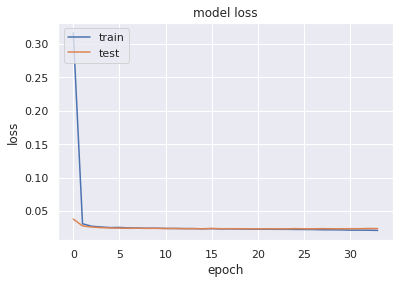

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.3167 - binary_crossentropy: 0.3148 - val_loss: 0.0356 - val_binary_crossentropy: 0.0312
Epoch 2/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0307 - binary_crossentropy: 0.0258 - val_loss: 0.0270 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0271 - binary_crossentropy: 0.0215 - val_loss: 0.0254 - val_binary_crossentropy: 0.0196
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0260 - binary_crossentropy: 0.0201 - val_loss: 0.0249 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0245 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0241 - val_binary_crossentropy: 0.01

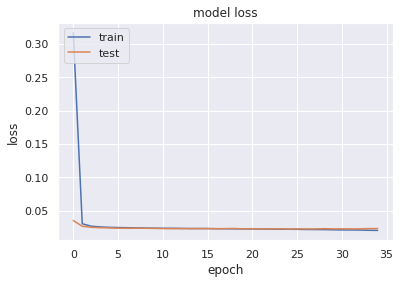

start fold 2
Epoch 1/80
160/160 [==============================] - 3s 16ms/step - loss: 0.3161 - binary_crossentropy: 0.3142 - val_loss: 0.0352 - val_binary_crossentropy: 0.0309
Epoch 2/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0307 - binary_crossentropy: 0.0258 - val_loss: 0.0275 - val_binary_crossentropy: 0.0221
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0272 - binary_crossentropy: 0.0215 - val_loss: 0.0255 - val_binary_crossentropy: 0.0197
Epoch 4/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0260 - binary_crossentropy: 0.0201 - val_loss: 0.0246 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0243 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0251 - binary_crossentropy: 0.0190 - val_loss: 0.0241 - val_binary_crossentropy: 0.01

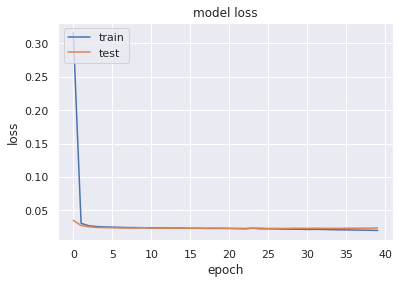

start fold 3
Epoch 1/80
160/160 [==============================] - 3s 16ms/step - loss: 0.3163 - binary_crossentropy: 0.3145 - val_loss: 0.0351 - val_binary_crossentropy: 0.0306
Epoch 2/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0309 - binary_crossentropy: 0.0260 - val_loss: 0.0271 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0272 - binary_crossentropy: 0.0216 - val_loss: 0.0255 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0260 - binary_crossentropy: 0.0200 - val_loss: 0.0246 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0246 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0243 - val_binary_crossentropy: 0.01

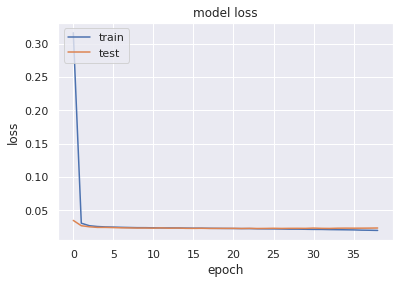

start fold 4
Epoch 1/80
160/160 [==============================] - 3s 20ms/step - loss: 0.3187 - binary_crossentropy: 0.3169 - val_loss: 0.0399 - val_binary_crossentropy: 0.0355
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0308 - binary_crossentropy: 0.0259 - val_loss: 0.0274 - val_binary_crossentropy: 0.0219
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0270 - binary_crossentropy: 0.0214 - val_loss: 0.0257 - val_binary_crossentropy: 0.0201
Epoch 4/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0259 - binary_crossentropy: 0.0200 - val_loss: 0.0251 - val_binary_crossentropy: 0.0192
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0249 - val_binary_crossentropy: 0.0187
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0246 - val_binary_crossentropy: 0.01

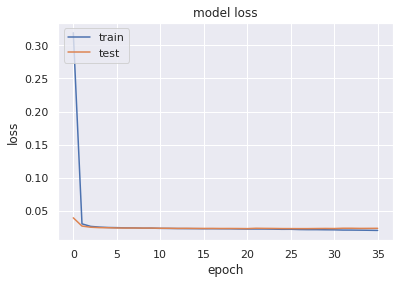

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3200 - binary_crossentropy: 0.3182 - val_loss: 0.0375 - val_binary_crossentropy: 0.0331
Epoch 2/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0310 - binary_crossentropy: 0.0260 - val_loss: 0.0272 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0271 - binary_crossentropy: 0.0215 - val_loss: 0.0258 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0260 - binary_crossentropy: 0.0201 - val_loss: 0.0249 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0247 - val_binary_crossentropy: 0.0185
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0242 - val_binary_crossentropy: 0.01

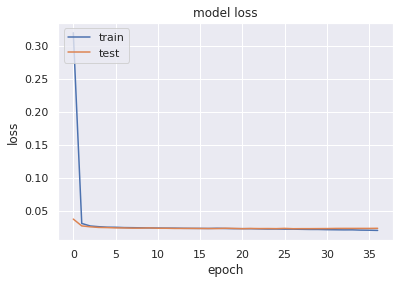

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3182 - binary_crossentropy: 0.3164 - val_loss: 0.0383 - val_binary_crossentropy: 0.0339
Epoch 2/80
160/160 [==============================] - 3s 20ms/step - loss: 0.0308 - binary_crossentropy: 0.0259 - val_loss: 0.0275 - val_binary_crossentropy: 0.0222
Epoch 3/80
160/160 [==============================] - 3s 18ms/step - loss: 0.0271 - binary_crossentropy: 0.0215 - val_loss: 0.0258 - val_binary_crossentropy: 0.0200
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0261 - binary_crossentropy: 0.0201 - val_loss: 0.0248 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0248 - val_binary_crossentropy: 0.0188
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0244 - val_binary_crossentropy: 0.01

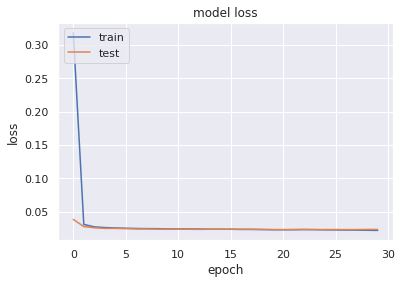

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.3171 - binary_crossentropy: 0.3153 - val_loss: 0.0393 - val_binary_crossentropy: 0.0350
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0309 - binary_crossentropy: 0.0260 - val_loss: 0.0281 - val_binary_crossentropy: 0.0228
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0270 - binary_crossentropy: 0.0213 - val_loss: 0.0257 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 3s 19ms/step - loss: 0.0258 - binary_crossentropy: 0.0198 - val_loss: 0.0250 - val_binary_crossentropy: 0.0192
Epoch 5/80
160/160 [==============================] - 3s 18ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0246 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0243 - val_binary_crossentropy: 0.01

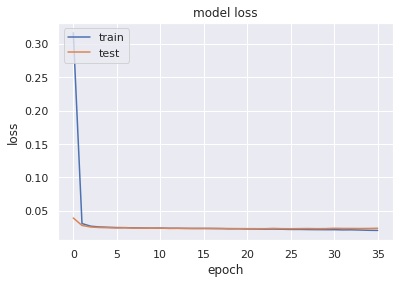

start fold 8
Epoch 1/80
160/160 [==============================] - 3s 22ms/step - loss: 0.3171 - binary_crossentropy: 0.3153 - val_loss: 0.0385 - val_binary_crossentropy: 0.0340
Epoch 2/80
160/160 [==============================] - 3s 19ms/step - loss: 0.0307 - binary_crossentropy: 0.0258 - val_loss: 0.0275 - val_binary_crossentropy: 0.0221
Epoch 3/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0271 - binary_crossentropy: 0.0214 - val_loss: 0.0255 - val_binary_crossentropy: 0.0198
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0260 - binary_crossentropy: 0.0200 - val_loss: 0.0247 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0252 - binary_crossentropy: 0.0191 - val_loss: 0.0243 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 3s 16ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0243 - val_binary_crossentropy: 0.01

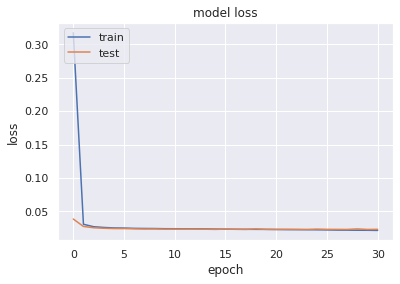

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.3154 - binary_crossentropy: 0.3135 - val_loss: 0.0373 - val_binary_crossentropy: 0.0326
Epoch 2/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0310 - binary_crossentropy: 0.0261 - val_loss: 0.0273 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0272 - binary_crossentropy: 0.0216 - val_loss: 0.0255 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0261 - binary_crossentropy: 0.0202 - val_loss: 0.0249 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0244 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0243 - val_binary_crossentropy: 0.01

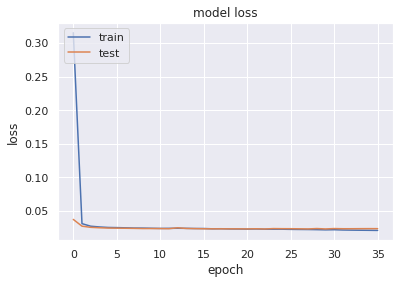

Our out of folds mean log loss score is 0.016779216297852038
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3193 - binary_crossentropy: 0.3175 - val_loss: 0.0407 - val_binary_crossentropy: 0.0359
Epoch 2/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0310 - binary_crossentropy: 0.0260 - val_loss: 0.0269 - val_binary_crossentropy: 0.0213
Epoch 3/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0270 - binary_crossentropy: 0.0213 - val_loss: 0.0256 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0262 - binary_crossentropy: 0.0202 - val_loss: 0.0248 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0255 - binary_crossentropy: 0.0194 - val_loss: 0.0243 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0250 - binary_crossentro

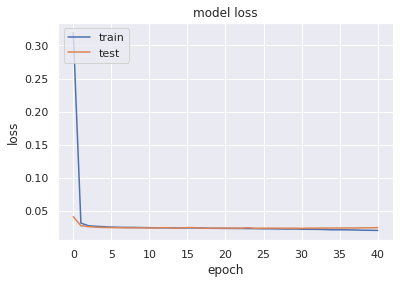

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.3189 - binary_crossentropy: 0.3170 - val_loss: 0.0384 - val_binary_crossentropy: 0.0339
Epoch 2/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0307 - binary_crossentropy: 0.0257 - val_loss: 0.0269 - val_binary_crossentropy: 0.0215
Epoch 3/80
160/160 [==============================] - 3s 17ms/step - loss: 0.0271 - binary_crossentropy: 0.0215 - val_loss: 0.0254 - val_binary_crossentropy: 0.0197
Epoch 4/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0258 - binary_crossentropy: 0.0199 - val_loss: 0.0248 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0246 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0239 - val_binary_crossentropy: 0.01

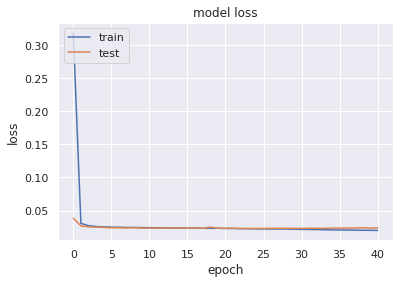

start fold 2
Epoch 1/80
160/160 [==============================] - 3s 17ms/step - loss: 0.3161 - binary_crossentropy: 0.3142 - val_loss: 0.0371 - val_binary_crossentropy: 0.0328
Epoch 2/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0309 - binary_crossentropy: 0.0260 - val_loss: 0.0279 - val_binary_crossentropy: 0.0223
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0272 - binary_crossentropy: 0.0215 - val_loss: 0.0257 - val_binary_crossentropy: 0.0200
Epoch 4/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0260 - binary_crossentropy: 0.0201 - val_loss: 0.0251 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0255 - binary_crossentropy: 0.0194 - val_loss: 0.0246 - val_binary_crossentropy: 0.0185
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0249 - binary_crossentropy: 0.0188 - val_loss: 0.0246 - val_binary_crossentropy: 0.01

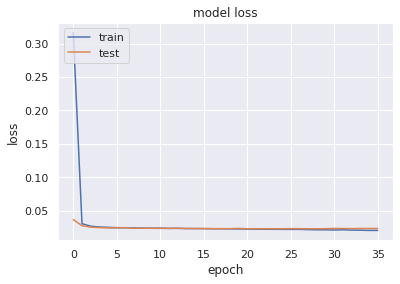

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.3184 - binary_crossentropy: 0.3165 - val_loss: 0.0355 - val_binary_crossentropy: 0.0309
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0307 - binary_crossentropy: 0.0258 - val_loss: 0.0274 - val_binary_crossentropy: 0.0219
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0270 - binary_crossentropy: 0.0214 - val_loss: 0.0256 - val_binary_crossentropy: 0.0198
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0259 - binary_crossentropy: 0.0200 - val_loss: 0.0249 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0252 - binary_crossentropy: 0.0191 - val_loss: 0.0246 - val_binary_crossentropy: 0.0185
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0249 - binary_crossentropy: 0.0188 - val_loss: 0.0242 - val_binary_crossentropy: 0.01

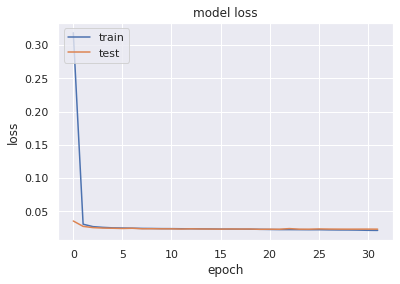

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.3189 - binary_crossentropy: 0.3170 - val_loss: 0.0370 - val_binary_crossentropy: 0.0327
Epoch 2/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0308 - binary_crossentropy: 0.0259 - val_loss: 0.0271 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0273 - binary_crossentropy: 0.0217 - val_loss: 0.0258 - val_binary_crossentropy: 0.0201
Epoch 4/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0260 - binary_crossentropy: 0.0200 - val_loss: 0.0249 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0246 - val_binary_crossentropy: 0.0185
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0249 - binary_crossentropy: 0.0188 - val_loss: 0.0244 - val_binary_crossentropy: 0.01

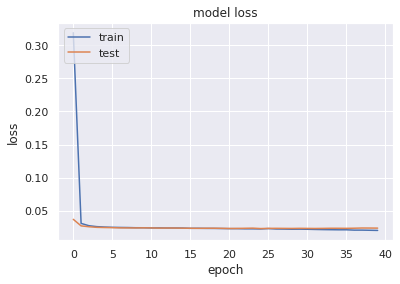

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.3183 - binary_crossentropy: 0.3164 - val_loss: 0.0381 - val_binary_crossentropy: 0.0333
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0309 - binary_crossentropy: 0.0260 - val_loss: 0.0276 - val_binary_crossentropy: 0.0222
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0271 - binary_crossentropy: 0.0214 - val_loss: 0.0260 - val_binary_crossentropy: 0.0202
Epoch 4/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0259 - binary_crossentropy: 0.0200 - val_loss: 0.0248 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 3s 20ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0245 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 3s 20ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0243 - val_binary_crossentropy: 0.01

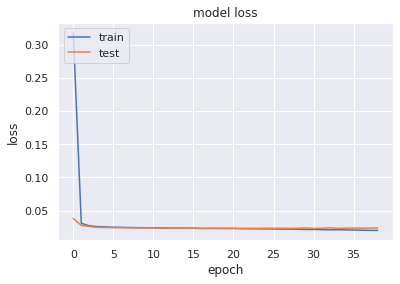

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3189 - binary_crossentropy: 0.3171 - val_loss: 0.0354 - val_binary_crossentropy: 0.0311
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0308 - binary_crossentropy: 0.0259 - val_loss: 0.0270 - val_binary_crossentropy: 0.0215
Epoch 3/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0272 - binary_crossentropy: 0.0215 - val_loss: 0.0255 - val_binary_crossentropy: 0.0197
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0261 - binary_crossentropy: 0.0201 - val_loss: 0.0247 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0256 - binary_crossentropy: 0.0194 - val_loss: 0.0247 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0242 - val_binary_crossentropy: 0.01

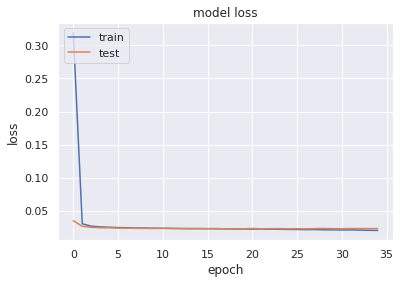

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3181 - binary_crossentropy: 0.3163 - val_loss: 0.0380 - val_binary_crossentropy: 0.0338
Epoch 2/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0308 - binary_crossentropy: 0.0258 - val_loss: 0.0270 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0272 - binary_crossentropy: 0.0216 - val_loss: 0.0254 - val_binary_crossentropy: 0.0197
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0260 - binary_crossentropy: 0.0201 - val_loss: 0.0248 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0254 - binary_crossentropy: 0.0194 - val_loss: 0.0244 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0249 - binary_crossentropy: 0.0188 - val_loss: 0.0241 - val_binary_crossentropy: 0.01

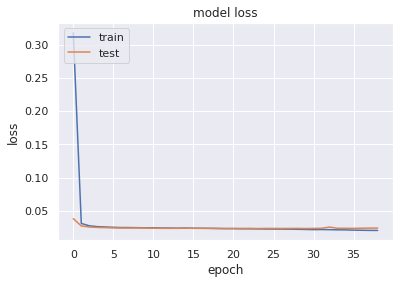

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.3172 - binary_crossentropy: 0.3154 - val_loss: 0.0373 - val_binary_crossentropy: 0.0328
Epoch 2/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0306 - binary_crossentropy: 0.0257 - val_loss: 0.0269 - val_binary_crossentropy: 0.0215
Epoch 3/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0269 - binary_crossentropy: 0.0213 - val_loss: 0.0254 - val_binary_crossentropy: 0.0196
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0260 - binary_crossentropy: 0.0201 - val_loss: 0.0256 - val_binary_crossentropy: 0.0192
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0246 - val_binary_crossentropy: 0.0185
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0246 - val_binary_crossentropy: 0.01

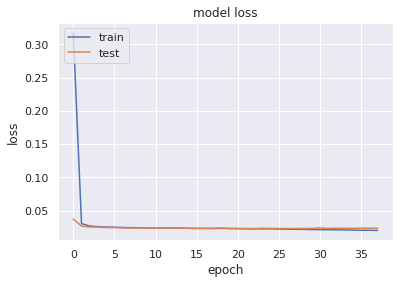

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.3168 - binary_crossentropy: 0.3150 - val_loss: 0.0352 - val_binary_crossentropy: 0.0308
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0308 - binary_crossentropy: 0.0258 - val_loss: 0.0271 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0270 - binary_crossentropy: 0.0213 - val_loss: 0.0255 - val_binary_crossentropy: 0.0198
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0258 - binary_crossentropy: 0.0199 - val_loss: 0.0249 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0252 - binary_crossentropy: 0.0192 - val_loss: 0.0246 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0245 - val_binary_crossentropy: 0.01

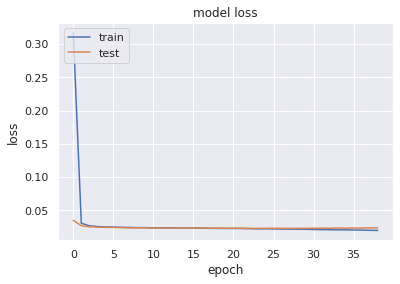

Our out of folds mean log loss score is 0.016892926040674834
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3186 - binary_crossentropy: 0.3167 - val_loss: 0.0362 - val_binary_crossentropy: 0.0317
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0306 - binary_crossentropy: 0.0257 - val_loss: 0.0276 - val_binary_crossentropy: 0.0223
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0270 - binary_crossentropy: 0.0213 - val_loss: 0.0255 - val_binary_crossentropy: 0.0198
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0258 - binary_crossentropy: 0.0199 - val_loss: 0.0249 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0246 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0250 - binary_crossentro

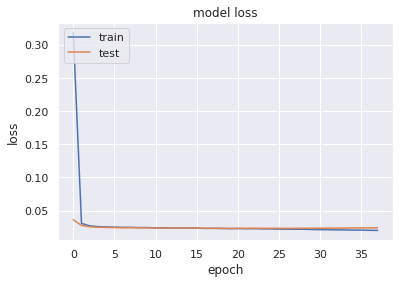

start fold 1
Epoch 1/80
160/160 [==============================] - 3s 21ms/step - loss: 0.3172 - binary_crossentropy: 0.3154 - val_loss: 0.0389 - val_binary_crossentropy: 0.0346
Epoch 2/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0310 - binary_crossentropy: 0.0261 - val_loss: 0.0270 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0272 - binary_crossentropy: 0.0216 - val_loss: 0.0255 - val_binary_crossentropy: 0.0198
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0260 - binary_crossentropy: 0.0200 - val_loss: 0.0249 - val_binary_crossentropy: 0.0191
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0245 - val_binary_crossentropy: 0.0185
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0242 - val_binary_crossentropy: 0.01

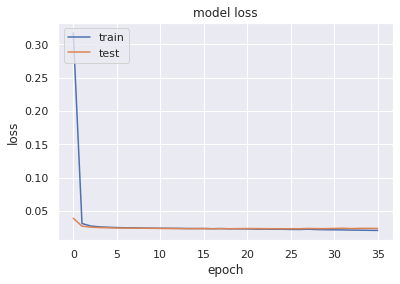

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.3183 - binary_crossentropy: 0.3165 - val_loss: 0.0361 - val_binary_crossentropy: 0.0316
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0307 - binary_crossentropy: 0.0258 - val_loss: 0.0270 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0272 - binary_crossentropy: 0.0216 - val_loss: 0.0256 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0260 - binary_crossentropy: 0.0200 - val_loss: 0.0249 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0243 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0240 - val_binary_crossentropy: 0.01

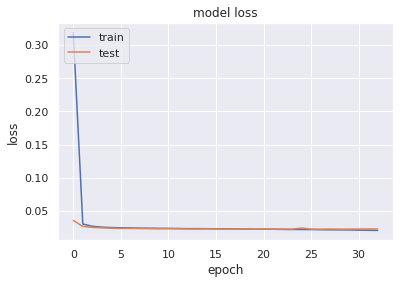

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3166 - binary_crossentropy: 0.3148 - val_loss: 0.0380 - val_binary_crossentropy: 0.0336
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0309 - binary_crossentropy: 0.0260 - val_loss: 0.0278 - val_binary_crossentropy: 0.0223
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0272 - binary_crossentropy: 0.0215 - val_loss: 0.0257 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0260 - binary_crossentropy: 0.0201 - val_loss: 0.0249 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0256 - binary_crossentropy: 0.0195 - val_loss: 0.0247 - val_binary_crossentropy: 0.0187
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0244 - val_binary_crossentropy: 0.01

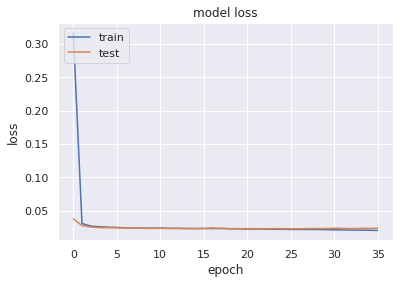

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.3161 - binary_crossentropy: 0.3142 - val_loss: 0.0365 - val_binary_crossentropy: 0.0319
Epoch 2/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0307 - binary_crossentropy: 0.0258 - val_loss: 0.0270 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0271 - binary_crossentropy: 0.0214 - val_loss: 0.0255 - val_binary_crossentropy: 0.0198
Epoch 4/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0261 - binary_crossentropy: 0.0201 - val_loss: 0.0251 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0244 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0243 - val_binary_crossentropy: 0.01

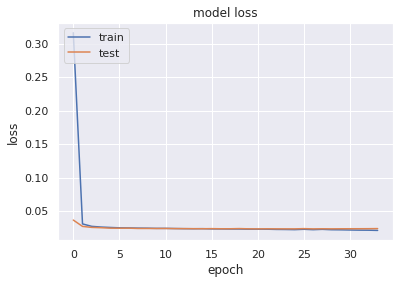

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3177 - binary_crossentropy: 0.3159 - val_loss: 0.0375 - val_binary_crossentropy: 0.0331
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0307 - binary_crossentropy: 0.0258 - val_loss: 0.0274 - val_binary_crossentropy: 0.0220
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0272 - binary_crossentropy: 0.0215 - val_loss: 0.0256 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0260 - binary_crossentropy: 0.0200 - val_loss: 0.0251 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0243 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0248 - binary_crossentropy: 0.0186 - val_loss: 0.0241 - val_binary_crossentropy: 0.01

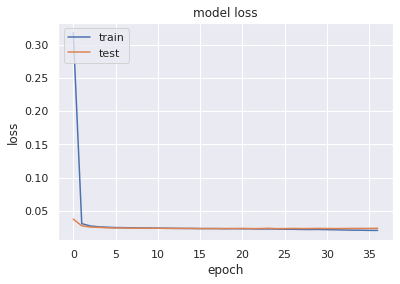

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3176 - binary_crossentropy: 0.3157 - val_loss: 0.0372 - val_binary_crossentropy: 0.0328
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0310 - binary_crossentropy: 0.0261 - val_loss: 0.0273 - val_binary_crossentropy: 0.0218
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0275 - binary_crossentropy: 0.0218 - val_loss: 0.0263 - val_binary_crossentropy: 0.0202
Epoch 4/80
160/160 [==============================] - 3s 16ms/step - loss: 0.0261 - binary_crossentropy: 0.0201 - val_loss: 0.0248 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0249 - val_binary_crossentropy: 0.0188
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0250 - binary_crossentropy: 0.0187 - val_loss: 0.0242 - val_binary_crossentropy: 0.01

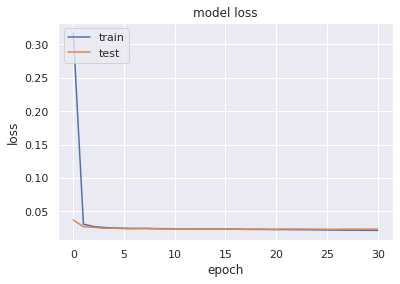

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3189 - binary_crossentropy: 0.3171 - val_loss: 0.0400 - val_binary_crossentropy: 0.0357
Epoch 2/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0313 - binary_crossentropy: 0.0264 - val_loss: 0.0275 - val_binary_crossentropy: 0.0219
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0274 - binary_crossentropy: 0.0217 - val_loss: 0.0259 - val_binary_crossentropy: 0.0200
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0261 - binary_crossentropy: 0.0201 - val_loss: 0.0251 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0245 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0241 - val_binary_crossentropy: 0.01

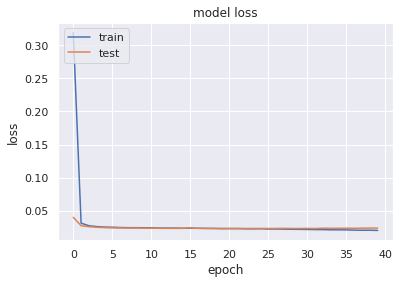

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.3169 - binary_crossentropy: 0.3150 - val_loss: 0.0363 - val_binary_crossentropy: 0.0320
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0305 - binary_crossentropy: 0.0256 - val_loss: 0.0276 - val_binary_crossentropy: 0.0222
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0271 - binary_crossentropy: 0.0215 - val_loss: 0.0258 - val_binary_crossentropy: 0.0200
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0259 - binary_crossentropy: 0.0200 - val_loss: 0.0249 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0245 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 4s 23ms/step - loss: 0.0249 - binary_crossentropy: 0.0188 - val_loss: 0.0245 - val_binary_crossentropy: 0.01

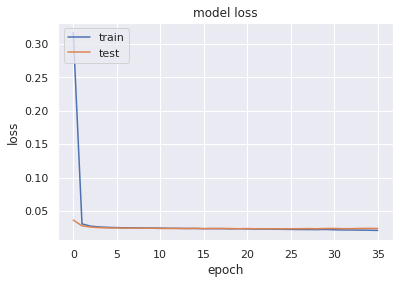

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3176 - binary_crossentropy: 0.3158 - val_loss: 0.0388 - val_binary_crossentropy: 0.0342
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0308 - binary_crossentropy: 0.0259 - val_loss: 0.0275 - val_binary_crossentropy: 0.0220
Epoch 3/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0272 - binary_crossentropy: 0.0216 - val_loss: 0.0258 - val_binary_crossentropy: 0.0200
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0259 - binary_crossentropy: 0.0200 - val_loss: 0.0249 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0245 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0243 - val_binary_crossentropy: 0.01

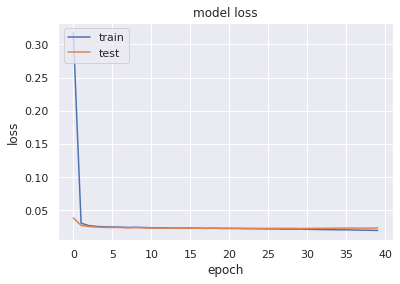

Our out of folds mean log loss score is 0.01681561217120392
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.3175 - binary_crossentropy: 0.3156 - val_loss: 0.0386 - val_binary_crossentropy: 0.0341
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0305 - binary_crossentropy: 0.0256 - val_loss: 0.0274 - val_binary_crossentropy: 0.0220
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0269 - binary_crossentropy: 0.0213 - val_loss: 0.0257 - val_binary_crossentropy: 0.0198
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0259 - binary_crossentropy: 0.0200 - val_loss: 0.0251 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0250 - val_binary_crossentropy: 0.0187
Epoch 6/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0249 - binary_crossentrop

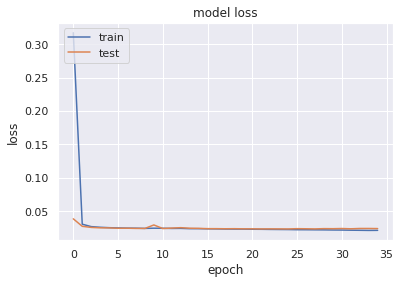

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3170 - binary_crossentropy: 0.3152 - val_loss: 0.0370 - val_binary_crossentropy: 0.0327
Epoch 2/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0307 - binary_crossentropy: 0.0258 - val_loss: 0.0273 - val_binary_crossentropy: 0.0219
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0272 - binary_crossentropy: 0.0215 - val_loss: 0.0257 - val_binary_crossentropy: 0.0200
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0261 - binary_crossentropy: 0.0201 - val_loss: 0.0247 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0244 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0244 - val_binary_crossentropy: 0.01

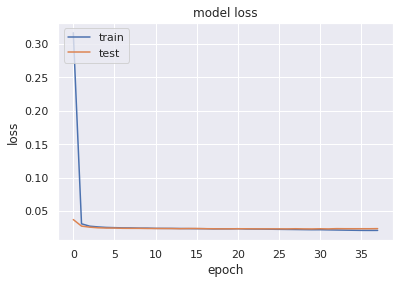

start fold 2
Epoch 1/80
160/160 [==============================] - 3s 17ms/step - loss: 0.3162 - binary_crossentropy: 0.3143 - val_loss: 0.0369 - val_binary_crossentropy: 0.0326
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0310 - binary_crossentropy: 0.0261 - val_loss: 0.0289 - val_binary_crossentropy: 0.0232
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0275 - binary_crossentropy: 0.0218 - val_loss: 0.0254 - val_binary_crossentropy: 0.0195
Epoch 4/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0262 - binary_crossentropy: 0.0202 - val_loss: 0.0248 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0255 - binary_crossentropy: 0.0194 - val_loss: 0.0243 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0240 - val_binary_crossentropy: 0.01

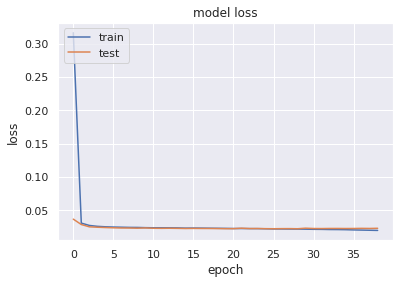

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3178 - binary_crossentropy: 0.3160 - val_loss: 0.0385 - val_binary_crossentropy: 0.0341
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0308 - binary_crossentropy: 0.0259 - val_loss: 0.0277 - val_binary_crossentropy: 0.0224
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0273 - binary_crossentropy: 0.0216 - val_loss: 0.0257 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0260 - binary_crossentropy: 0.0201 - val_loss: 0.0248 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0245 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0242 - val_binary_crossentropy: 0.01

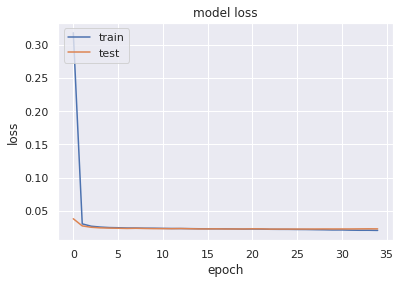

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3169 - binary_crossentropy: 0.3151 - val_loss: 0.0385 - val_binary_crossentropy: 0.0338
Epoch 2/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0308 - binary_crossentropy: 0.0258 - val_loss: 0.0269 - val_binary_crossentropy: 0.0215
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0270 - binary_crossentropy: 0.0214 - val_loss: 0.0256 - val_binary_crossentropy: 0.0198
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0258 - binary_crossentropy: 0.0199 - val_loss: 0.0247 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0245 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0242 - val_binary_crossentropy: 0.01

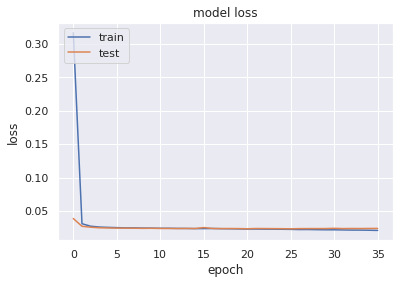

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3174 - binary_crossentropy: 0.3156 - val_loss: 0.0405 - val_binary_crossentropy: 0.0363
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0306 - binary_crossentropy: 0.0257 - val_loss: 0.0277 - val_binary_crossentropy: 0.0224
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0273 - binary_crossentropy: 0.0217 - val_loss: 0.0259 - val_binary_crossentropy: 0.0201
Epoch 4/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0263 - binary_crossentropy: 0.0204 - val_loss: 0.0252 - val_binary_crossentropy: 0.0193
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0255 - binary_crossentropy: 0.0194 - val_loss: 0.0257 - val_binary_crossentropy: 0.0194
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0244 - val_binary_crossentropy: 0.01

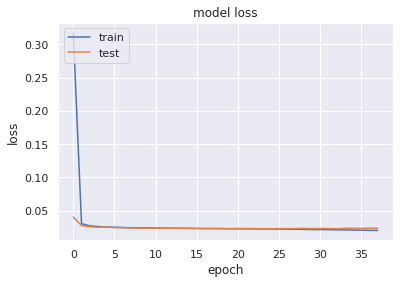

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.3170 - binary_crossentropy: 0.3151 - val_loss: 0.0372 - val_binary_crossentropy: 0.0330
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0309 - binary_crossentropy: 0.0259 - val_loss: 0.0273 - val_binary_crossentropy: 0.0218
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0274 - binary_crossentropy: 0.0217 - val_loss: 0.0258 - val_binary_crossentropy: 0.0200
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0261 - binary_crossentropy: 0.0202 - val_loss: 0.0250 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0247 - val_binary_crossentropy: 0.0185
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0250 - binary_crossentropy: 0.0189 - val_loss: 0.0246 - val_binary_crossentropy: 0.01

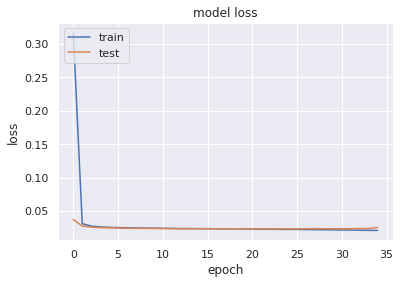

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3173 - binary_crossentropy: 0.3154 - val_loss: 0.0380 - val_binary_crossentropy: 0.0335
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0310 - binary_crossentropy: 0.0260 - val_loss: 0.0268 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0270 - binary_crossentropy: 0.0213 - val_loss: 0.0253 - val_binary_crossentropy: 0.0194
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0259 - binary_crossentropy: 0.0200 - val_loss: 0.0246 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0244 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0250 - binary_crossentropy: 0.0189 - val_loss: 0.0243 - val_binary_crossentropy: 0.01

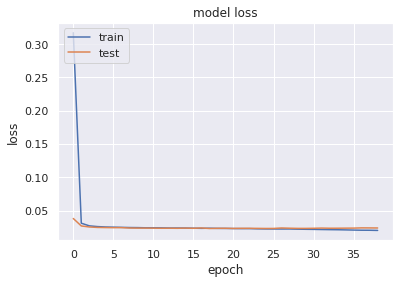

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.3177 - binary_crossentropy: 0.3159 - val_loss: 0.0363 - val_binary_crossentropy: 0.0321
Epoch 2/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0308 - binary_crossentropy: 0.0259 - val_loss: 0.0272 - val_binary_crossentropy: 0.0219
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0272 - binary_crossentropy: 0.0216 - val_loss: 0.0257 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0261 - binary_crossentropy: 0.0202 - val_loss: 0.0249 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0246 - val_binary_crossentropy: 0.0186
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0244 - val_binary_crossentropy: 0.01

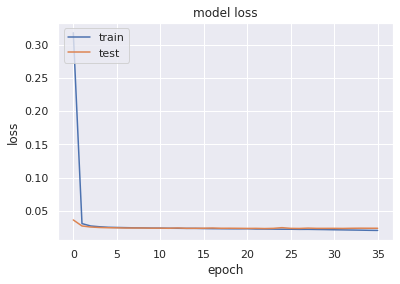

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3158 - binary_crossentropy: 0.3139 - val_loss: 0.0382 - val_binary_crossentropy: 0.0337
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0307 - binary_crossentropy: 0.0258 - val_loss: 0.0272 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 3s 16ms/step - loss: 0.0272 - binary_crossentropy: 0.0216 - val_loss: 0.0257 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0260 - binary_crossentropy: 0.0201 - val_loss: 0.0248 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0245 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0247 - val_binary_crossentropy: 0.01

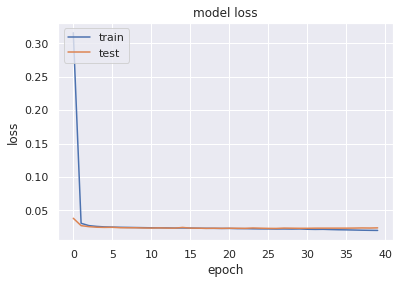

Our out of folds mean log loss score is 0.016900396532058926
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3191 - binary_crossentropy: 0.3173 - val_loss: 0.0371 - val_binary_crossentropy: 0.0326
Epoch 2/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0309 - binary_crossentropy: 0.0260 - val_loss: 0.0270 - val_binary_crossentropy: 0.0218
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0270 - binary_crossentropy: 0.0214 - val_loss: 0.0256 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0260 - binary_crossentropy: 0.0200 - val_loss: 0.0247 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0255 - binary_crossentropy: 0.0195 - val_loss: 0.0246 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0250 - binary_crossentro

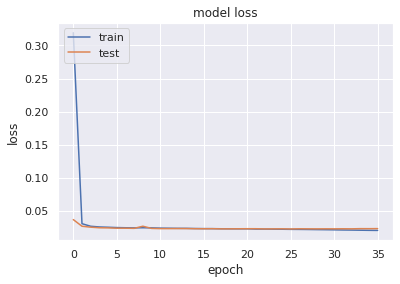

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3165 - binary_crossentropy: 0.3146 - val_loss: 0.0359 - val_binary_crossentropy: 0.0314
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0306 - binary_crossentropy: 0.0257 - val_loss: 0.0272 - val_binary_crossentropy: 0.0219
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0273 - binary_crossentropy: 0.0217 - val_loss: 0.0257 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0261 - binary_crossentropy: 0.0201 - val_loss: 0.0248 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0243 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 3s 17ms/step - loss: 0.0249 - binary_crossentropy: 0.0188 - val_loss: 0.0242 - val_binary_crossentropy: 0.01

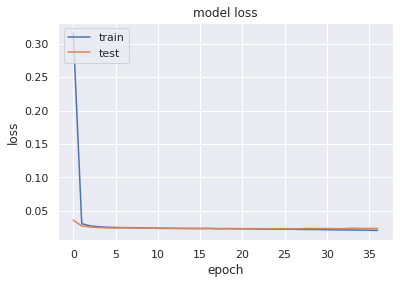

start fold 2
Epoch 1/80
160/160 [==============================] - 4s 27ms/step - loss: 0.3154 - binary_crossentropy: 0.3136 - val_loss: 0.0376 - val_binary_crossentropy: 0.0330
Epoch 2/80
160/160 [==============================] - 3s 19ms/step - loss: 0.0308 - binary_crossentropy: 0.0259 - val_loss: 0.0273 - val_binary_crossentropy: 0.0221
Epoch 3/80
160/160 [==============================] - 3s 18ms/step - loss: 0.0273 - binary_crossentropy: 0.0216 - val_loss: 0.0255 - val_binary_crossentropy: 0.0198
Epoch 4/80
160/160 [==============================] - 3s 19ms/step - loss: 0.0259 - binary_crossentropy: 0.0200 - val_loss: 0.0249 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0247 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0243 - val_binary_crossentropy: 0.01

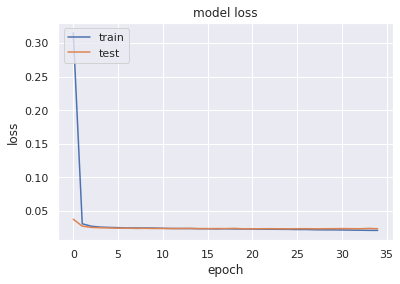

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3200 - binary_crossentropy: 0.3182 - val_loss: 0.0373 - val_binary_crossentropy: 0.0328
Epoch 2/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0311 - binary_crossentropy: 0.0261 - val_loss: 0.0278 - val_binary_crossentropy: 0.0223
Epoch 3/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0272 - binary_crossentropy: 0.0216 - val_loss: 0.0257 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0259 - binary_crossentropy: 0.0200 - val_loss: 0.0250 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0246 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0244 - val_binary_crossentropy: 0.01

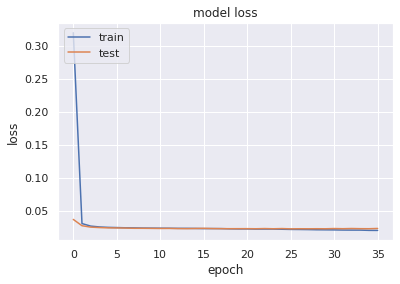

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3171 - binary_crossentropy: 0.3152 - val_loss: 0.0359 - val_binary_crossentropy: 0.0313
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0310 - binary_crossentropy: 0.0261 - val_loss: 0.0271 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0272 - binary_crossentropy: 0.0216 - val_loss: 0.0253 - val_binary_crossentropy: 0.0196
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0259 - binary_crossentropy: 0.0200 - val_loss: 0.0246 - val_binary_crossentropy: 0.0186
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0255 - binary_crossentropy: 0.0194 - val_loss: 0.0242 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0248 - binary_crossentropy: 0.0186 - val_loss: 0.0242 - val_binary_crossentropy: 0.01

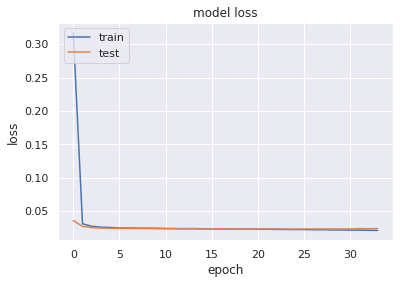

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3156 - binary_crossentropy: 0.3138 - val_loss: 0.0364 - val_binary_crossentropy: 0.0321
Epoch 2/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0310 - binary_crossentropy: 0.0260 - val_loss: 0.0273 - val_binary_crossentropy: 0.0219
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0274 - binary_crossentropy: 0.0218 - val_loss: 0.0257 - val_binary_crossentropy: 0.0200
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0261 - binary_crossentropy: 0.0202 - val_loss: 0.0248 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0256 - binary_crossentropy: 0.0195 - val_loss: 0.0246 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0242 - val_binary_crossentropy: 0.01

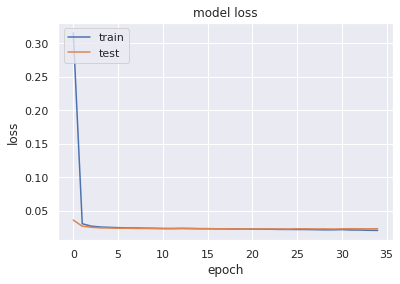

start fold 6
Epoch 1/80
160/160 [==============================] - 3s 17ms/step - loss: 0.3173 - binary_crossentropy: 0.3154 - val_loss: 0.0377 - val_binary_crossentropy: 0.0334
Epoch 2/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0307 - binary_crossentropy: 0.0257 - val_loss: 0.0270 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0268 - binary_crossentropy: 0.0211 - val_loss: 0.0252 - val_binary_crossentropy: 0.0194
Epoch 4/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0257 - binary_crossentropy: 0.0198 - val_loss: 0.0247 - val_binary_crossentropy: 0.0186
Epoch 5/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0245 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0248 - binary_crossentropy: 0.0187 - val_loss: 0.0241 - val_binary_crossentropy: 0.01

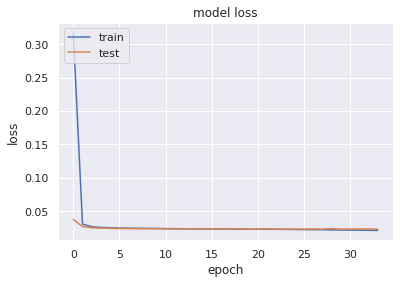

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3181 - binary_crossentropy: 0.3163 - val_loss: 0.0392 - val_binary_crossentropy: 0.0346
Epoch 2/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0307 - binary_crossentropy: 0.0258 - val_loss: 0.0275 - val_binary_crossentropy: 0.0220
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0274 - binary_crossentropy: 0.0217 - val_loss: 0.0263 - val_binary_crossentropy: 0.0202
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0259 - binary_crossentropy: 0.0199 - val_loss: 0.0250 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0249 - val_binary_crossentropy: 0.0187
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0244 - val_binary_crossentropy: 0.01

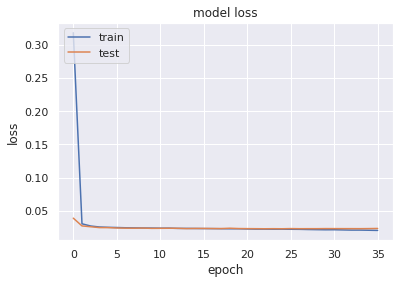

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3199 - binary_crossentropy: 0.3180 - val_loss: 0.0361 - val_binary_crossentropy: 0.0316
Epoch 2/80
160/160 [==============================] - 3s 17ms/step - loss: 0.0306 - binary_crossentropy: 0.0257 - val_loss: 0.0274 - val_binary_crossentropy: 0.0221
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0269 - binary_crossentropy: 0.0213 - val_loss: 0.0254 - val_binary_crossentropy: 0.0196
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0258 - binary_crossentropy: 0.0199 - val_loss: 0.0249 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0252 - binary_crossentropy: 0.0191 - val_loss: 0.0246 - val_binary_crossentropy: 0.0185
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0245 - val_binary_crossentropy: 0.01

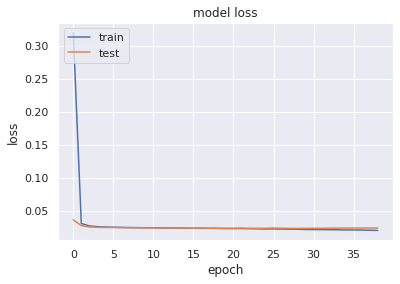

start fold 9
Epoch 1/80
160/160 [==============================] - 4s 23ms/step - loss: 0.3174 - binary_crossentropy: 0.3156 - val_loss: 0.0359 - val_binary_crossentropy: 0.0314
Epoch 2/80
160/160 [==============================] - 3s 20ms/step - loss: 0.0308 - binary_crossentropy: 0.0259 - val_loss: 0.0273 - val_binary_crossentropy: 0.0219
Epoch 3/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0271 - binary_crossentropy: 0.0215 - val_loss: 0.0257 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0259 - binary_crossentropy: 0.0199 - val_loss: 0.0250 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0245 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0247 - val_binary_crossentropy: 0.01

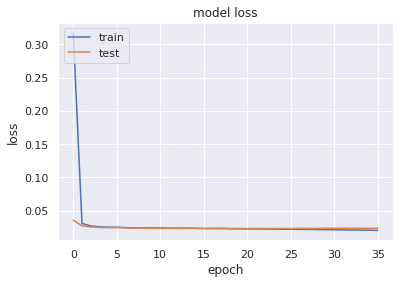

Our out of folds mean log loss score is 0.01677089344625973
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3194 - binary_crossentropy: 0.3176 - val_loss: 0.0377 - val_binary_crossentropy: 0.0332
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0307 - binary_crossentropy: 0.0258 - val_loss: 0.0272 - val_binary_crossentropy: 0.0218
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0272 - binary_crossentropy: 0.0216 - val_loss: 0.0257 - val_binary_crossentropy: 0.0198
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0259 - binary_crossentropy: 0.0200 - val_loss: 0.0248 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0245 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0250 - binary_crossentrop

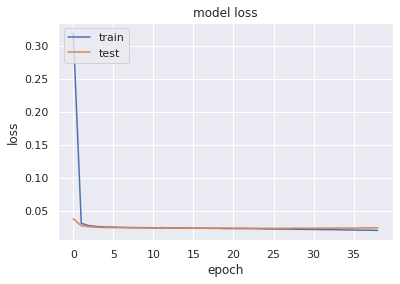

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3170 - binary_crossentropy: 0.3151 - val_loss: 0.0361 - val_binary_crossentropy: 0.0316
Epoch 2/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0309 - binary_crossentropy: 0.0259 - val_loss: 0.0275 - val_binary_crossentropy: 0.0221
Epoch 3/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0271 - binary_crossentropy: 0.0215 - val_loss: 0.0254 - val_binary_crossentropy: 0.0198
Epoch 4/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0260 - binary_crossentropy: 0.0201 - val_loss: 0.0249 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0252 - binary_crossentropy: 0.0191 - val_loss: 0.0244 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0248 - binary_crossentropy: 0.0187 - val_loss: 0.0242 - val_binary_crossentropy: 0.01

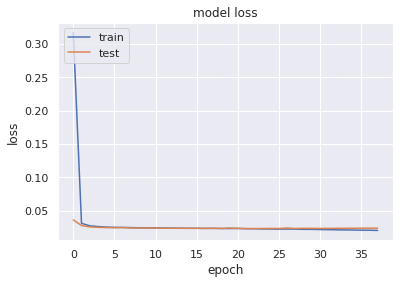

start fold 2
Epoch 1/80
160/160 [==============================] - 4s 26ms/step - loss: 0.3176 - binary_crossentropy: 0.3157 - val_loss: 0.0368 - val_binary_crossentropy: 0.0325
Epoch 2/80
160/160 [==============================] - 3s 21ms/step - loss: 0.0307 - binary_crossentropy: 0.0258 - val_loss: 0.0270 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 3s 22ms/step - loss: 0.0270 - binary_crossentropy: 0.0214 - val_loss: 0.0255 - val_binary_crossentropy: 0.0197
Epoch 4/80
160/160 [==============================] - 3s 19ms/step - loss: 0.0258 - binary_crossentropy: 0.0199 - val_loss: 0.0250 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 3s 17ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0244 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 3s 19ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0246 - val_binary_crossentropy: 0.01

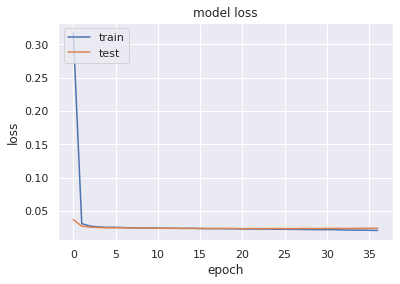

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.3200 - binary_crossentropy: 0.3182 - val_loss: 0.0402 - val_binary_crossentropy: 0.0357
Epoch 2/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0306 - binary_crossentropy: 0.0256 - val_loss: 0.0265 - val_binary_crossentropy: 0.0211
Epoch 3/80
160/160 [==============================] - 3s 16ms/step - loss: 0.0272 - binary_crossentropy: 0.0215 - val_loss: 0.0254 - val_binary_crossentropy: 0.0196
Epoch 4/80
160/160 [==============================] - 3s 17ms/step - loss: 0.0260 - binary_crossentropy: 0.0200 - val_loss: 0.0248 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0246 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0242 - val_binary_crossentropy: 0.01

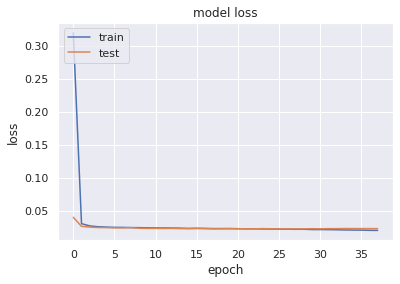

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.3184 - binary_crossentropy: 0.3166 - val_loss: 0.0377 - val_binary_crossentropy: 0.0332
Epoch 2/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0307 - binary_crossentropy: 0.0258 - val_loss: 0.0278 - val_binary_crossentropy: 0.0224
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0273 - binary_crossentropy: 0.0217 - val_loss: 0.0260 - val_binary_crossentropy: 0.0203
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0260 - binary_crossentropy: 0.0201 - val_loss: 0.0249 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0258 - val_binary_crossentropy: 0.0197
Epoch 6/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0243 - val_binary_crossentropy: 0.01

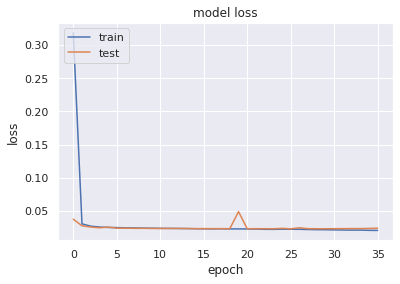

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3159 - binary_crossentropy: 0.3140 - val_loss: 0.0371 - val_binary_crossentropy: 0.0327
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0309 - binary_crossentropy: 0.0260 - val_loss: 0.0274 - val_binary_crossentropy: 0.0220
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0271 - binary_crossentropy: 0.0215 - val_loss: 0.0260 - val_binary_crossentropy: 0.0202
Epoch 4/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0262 - binary_crossentropy: 0.0203 - val_loss: 0.0251 - val_binary_crossentropy: 0.0192
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0255 - binary_crossentropy: 0.0194 - val_loss: 0.0251 - val_binary_crossentropy: 0.0187
Epoch 6/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0243 - val_binary_crossentropy: 0.01

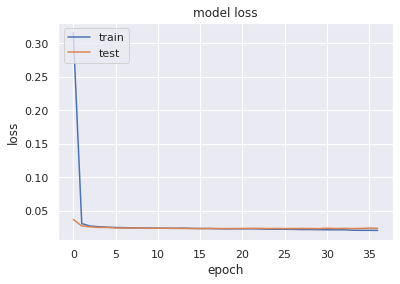

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3161 - binary_crossentropy: 0.3143 - val_loss: 0.0384 - val_binary_crossentropy: 0.0335
Epoch 2/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0306 - binary_crossentropy: 0.0257 - val_loss: 0.0272 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0271 - binary_crossentropy: 0.0214 - val_loss: 0.0259 - val_binary_crossentropy: 0.0201
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0258 - binary_crossentropy: 0.0199 - val_loss: 0.0251 - val_binary_crossentropy: 0.0191
Epoch 5/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0247 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0245 - val_binary_crossentropy: 0.01

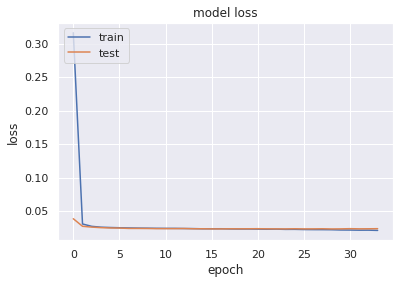

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3172 - binary_crossentropy: 0.3154 - val_loss: 0.0401 - val_binary_crossentropy: 0.0356
Epoch 2/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0308 - binary_crossentropy: 0.0259 - val_loss: 0.0273 - val_binary_crossentropy: 0.0218
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0272 - binary_crossentropy: 0.0216 - val_loss: 0.0256 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0260 - binary_crossentropy: 0.0200 - val_loss: 0.0247 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0244 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0241 - val_binary_crossentropy: 0.01

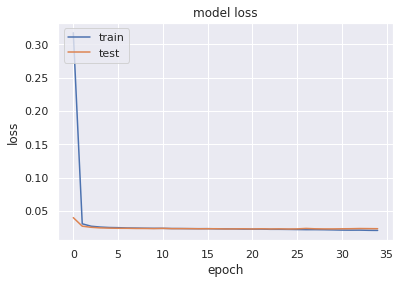

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3181 - binary_crossentropy: 0.3163 - val_loss: 0.0380 - val_binary_crossentropy: 0.0332
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0308 - binary_crossentropy: 0.0259 - val_loss: 0.0271 - val_binary_crossentropy: 0.0215
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0271 - binary_crossentropy: 0.0215 - val_loss: 0.0255 - val_binary_crossentropy: 0.0197
Epoch 4/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0259 - binary_crossentropy: 0.0200 - val_loss: 0.0248 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0245 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0248 - binary_crossentropy: 0.0187 - val_loss: 0.0244 - val_binary_crossentropy: 0.01

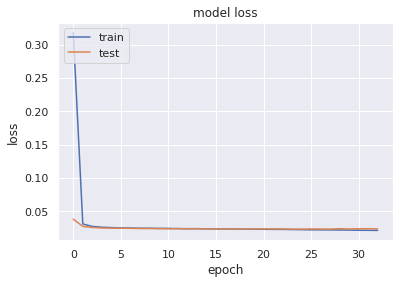

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3171 - binary_crossentropy: 0.3153 - val_loss: 0.0358 - val_binary_crossentropy: 0.0313
Epoch 2/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0307 - binary_crossentropy: 0.0258 - val_loss: 0.0272 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 4s 23ms/step - loss: 0.0272 - binary_crossentropy: 0.0216 - val_loss: 0.0261 - val_binary_crossentropy: 0.0203
Epoch 4/80
160/160 [==============================] - 3s 20ms/step - loss: 0.0260 - binary_crossentropy: 0.0201 - val_loss: 0.0248 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 3s 19ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0245 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 4s 24ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0241 - val_binary_crossentropy: 0.01

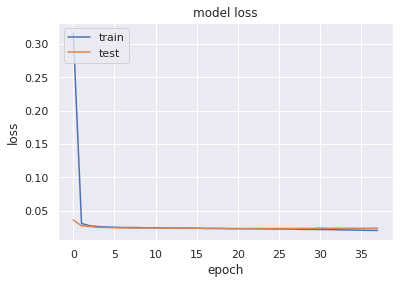

Our out of folds mean log loss score is 0.016843859345616764
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3165 - binary_crossentropy: 0.3147 - val_loss: 0.0390 - val_binary_crossentropy: 0.0345
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0308 - binary_crossentropy: 0.0259 - val_loss: 0.0271 - val_binary_crossentropy: 0.0218
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0271 - binary_crossentropy: 0.0215 - val_loss: 0.0257 - val_binary_crossentropy: 0.0201
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0260 - binary_crossentropy: 0.0201 - val_loss: 0.0250 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0245 - val_binary_crossentropy: 0.0185
Epoch 6/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0251 - binary_crossentro

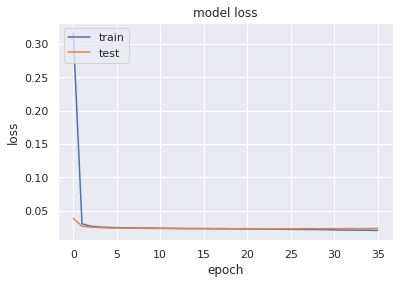

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 16ms/step - loss: 0.3175 - binary_crossentropy: 0.3157 - val_loss: 0.0384 - val_binary_crossentropy: 0.0337
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0309 - binary_crossentropy: 0.0260 - val_loss: 0.0272 - val_binary_crossentropy: 0.0218
Epoch 3/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0272 - binary_crossentropy: 0.0216 - val_loss: 0.0256 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0262 - binary_crossentropy: 0.0202 - val_loss: 0.0250 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0246 - val_binary_crossentropy: 0.0185
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0247 - val_binary_crossentropy: 0.01

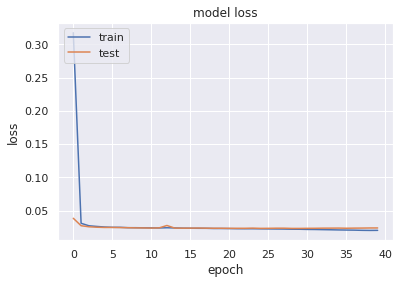

start fold 2
Epoch 1/80
160/160 [==============================] - 3s 17ms/step - loss: 0.3154 - binary_crossentropy: 0.3136 - val_loss: 0.0376 - val_binary_crossentropy: 0.0334
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0306 - binary_crossentropy: 0.0256 - val_loss: 0.0275 - val_binary_crossentropy: 0.0221
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0271 - binary_crossentropy: 0.0214 - val_loss: 0.0255 - val_binary_crossentropy: 0.0198
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0258 - binary_crossentropy: 0.0198 - val_loss: 0.0249 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0248 - val_binary_crossentropy: 0.0186
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0249 - binary_crossentropy: 0.0186 - val_loss: 0.0246 - val_binary_crossentropy: 0.01

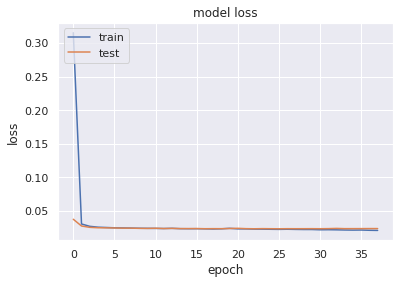

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.3156 - binary_crossentropy: 0.3137 - val_loss: 0.0392 - val_binary_crossentropy: 0.0348
Epoch 2/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0307 - binary_crossentropy: 0.0257 - val_loss: 0.0271 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0272 - binary_crossentropy: 0.0215 - val_loss: 0.0254 - val_binary_crossentropy: 0.0196
Epoch 4/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0260 - binary_crossentropy: 0.0200 - val_loss: 0.0249 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 2s 16ms/step - loss: 0.0255 - binary_crossentropy: 0.0194 - val_loss: 0.0244 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0241 - val_binary_crossentropy: 0.01

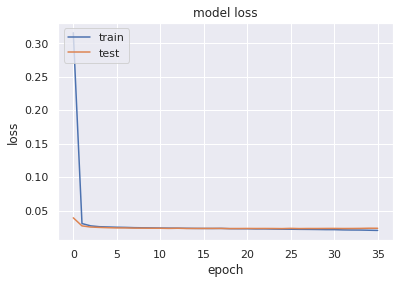

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3180 - binary_crossentropy: 0.3162 - val_loss: 0.0361 - val_binary_crossentropy: 0.0317
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0310 - binary_crossentropy: 0.0261 - val_loss: 0.0276 - val_binary_crossentropy: 0.0222
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0272 - binary_crossentropy: 0.0216 - val_loss: 0.0256 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0260 - binary_crossentropy: 0.0201 - val_loss: 0.0247 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0242 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0249 - binary_crossentropy: 0.0188 - val_loss: 0.0243 - val_binary_crossentropy: 0.01

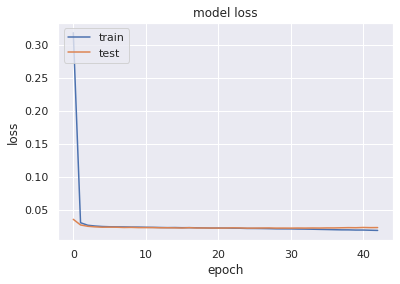

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3191 - binary_crossentropy: 0.3173 - val_loss: 0.0368 - val_binary_crossentropy: 0.0324
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0309 - binary_crossentropy: 0.0260 - val_loss: 0.0271 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0272 - binary_crossentropy: 0.0216 - val_loss: 0.0255 - val_binary_crossentropy: 0.0197
Epoch 4/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0261 - binary_crossentropy: 0.0202 - val_loss: 0.0248 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0255 - binary_crossentropy: 0.0194 - val_loss: 0.0246 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0239 - val_binary_crossentropy: 0.01

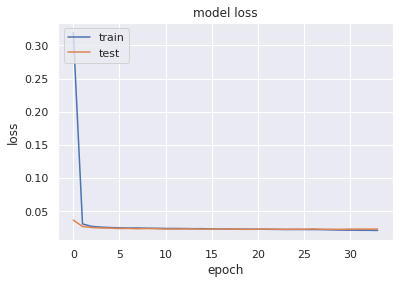

start fold 6
Epoch 1/80
160/160 [==============================] - 3s 20ms/step - loss: 0.3187 - binary_crossentropy: 0.3169 - val_loss: 0.0389 - val_binary_crossentropy: 0.0346
Epoch 2/80
160/160 [==============================] - 3s 19ms/step - loss: 0.0307 - binary_crossentropy: 0.0258 - val_loss: 0.0274 - val_binary_crossentropy: 0.0220
Epoch 3/80
160/160 [==============================] - 3s 18ms/step - loss: 0.0273 - binary_crossentropy: 0.0217 - val_loss: 0.0259 - val_binary_crossentropy: 0.0201
Epoch 4/80
160/160 [==============================] - 3s 18ms/step - loss: 0.0260 - binary_crossentropy: 0.0201 - val_loss: 0.0248 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 3s 19ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0248 - val_binary_crossentropy: 0.0186
Epoch 6/80
160/160 [==============================] - 3s 19ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0245 - val_binary_crossentropy: 0.01

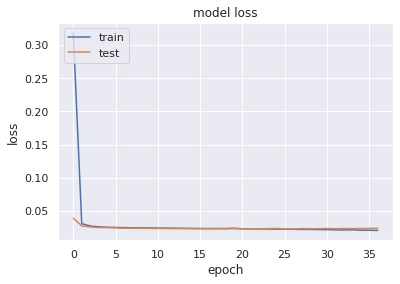

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3173 - binary_crossentropy: 0.3155 - val_loss: 0.0380 - val_binary_crossentropy: 0.0336
Epoch 2/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0307 - binary_crossentropy: 0.0258 - val_loss: 0.0274 - val_binary_crossentropy: 0.0219
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0272 - binary_crossentropy: 0.0215 - val_loss: 0.0260 - val_binary_crossentropy: 0.0201
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0262 - binary_crossentropy: 0.0203 - val_loss: 0.0249 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0246 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0243 - val_binary_crossentropy: 0.01

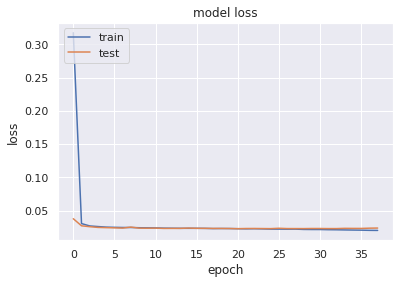

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.3184 - binary_crossentropy: 0.3166 - val_loss: 0.0376 - val_binary_crossentropy: 0.0332
Epoch 2/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0307 - binary_crossentropy: 0.0258 - val_loss: 0.0271 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0273 - binary_crossentropy: 0.0217 - val_loss: 0.0274 - val_binary_crossentropy: 0.0214
Epoch 4/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0261 - binary_crossentropy: 0.0201 - val_loss: 0.0247 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0256 - binary_crossentropy: 0.0194 - val_loss: 0.0246 - val_binary_crossentropy: 0.0185
Epoch 6/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0245 - val_binary_crossentropy: 0.01

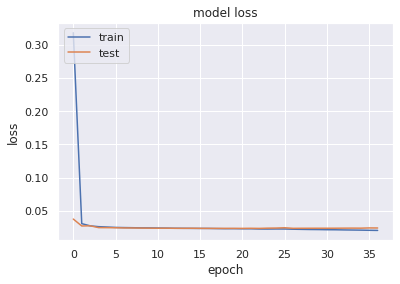

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3166 - binary_crossentropy: 0.3147 - val_loss: 0.0368 - val_binary_crossentropy: 0.0325
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0311 - binary_crossentropy: 0.0262 - val_loss: 0.0277 - val_binary_crossentropy: 0.0222
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0273 - binary_crossentropy: 0.0217 - val_loss: 0.0257 - val_binary_crossentropy: 0.0200
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0263 - binary_crossentropy: 0.0203 - val_loss: 0.0250 - val_binary_crossentropy: 0.0191
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0254 - binary_crossentropy: 0.0193 - val_loss: 0.0244 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0245 - val_binary_crossentropy: 0.01

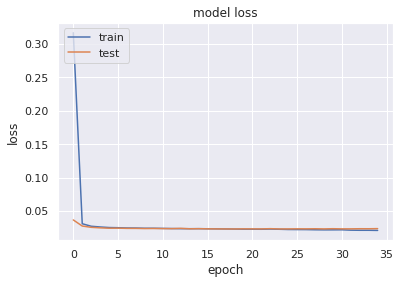

Our out of folds mean log loss score is 0.01686120163194982
CPU times: user 1h 59min 45s, sys: 14min 17s, total: 2h 14min 3s
Wall time: 1h 37min 6s


In [28]:
%%time
for SEED in SEEDS5:
    test_pred, oof_pred = train_and_evaluate(train, test, train_targets, features, start_predictors, SEED=SEED, MODEL = '5l')

start fold 0
Epoch 1/80
160/160 [==============================] - 1s 8ms/step - loss: 0.2964 - binary_crossentropy: 0.2944 - val_loss: 0.0342 - val_binary_crossentropy: 0.0295
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0302 - binary_crossentropy: 0.0251 - val_loss: 0.0272 - val_binary_crossentropy: 0.0215
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0269 - binary_crossentropy: 0.0211 - val_loss: 0.0255 - val_binary_crossentropy: 0.0197
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0197 - val_loss: 0.0247 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0253 - binary_crossentropy: 0.0191 - val_loss: 0.0245 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0186 - val_loss: 0.0243 - val_binary_crossentropy: 0.0180
Epo

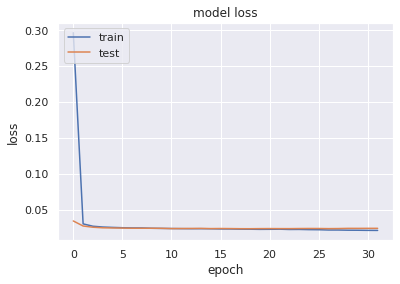

start fold 1
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2992 - binary_crossentropy: 0.2972 - val_loss: 0.0352 - val_binary_crossentropy: 0.0308
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0299 - binary_crossentropy: 0.0248 - val_loss: 0.0268 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0268 - binary_crossentropy: 0.0211 - val_loss: 0.0252 - val_binary_crossentropy: 0.0193
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0197 - val_loss: 0.0246 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0191 - val_loss: 0.0244 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0249 - binary_crossentropy: 0.0186 - val_loss: 0.0241 - val_binary_crossentropy: 0.0179
Epo

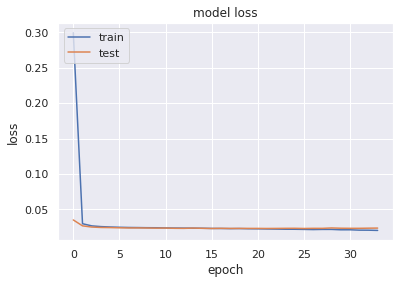

start fold 2
Epoch 1/80
160/160 [==============================] - 1s 8ms/step - loss: 0.2976 - binary_crossentropy: 0.2956 - val_loss: 0.0339 - val_binary_crossentropy: 0.0292
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0299 - binary_crossentropy: 0.0248 - val_loss: 0.0276 - val_binary_crossentropy: 0.0220
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0266 - binary_crossentropy: 0.0209 - val_loss: 0.0255 - val_binary_crossentropy: 0.0197
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0198 - val_loss: 0.0251 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0254 - binary_crossentropy: 0.0192 - val_loss: 0.0249 - val_binary_crossentropy: 0.0186
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0240 - val_binary_crossentropy: 0.0178
Epo

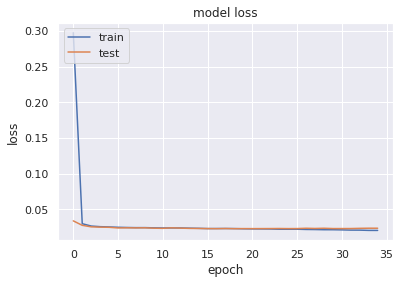

start fold 3
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2978 - binary_crossentropy: 0.2957 - val_loss: 0.0365 - val_binary_crossentropy: 0.0321
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0298 - binary_crossentropy: 0.0247 - val_loss: 0.0265 - val_binary_crossentropy: 0.0209
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0268 - binary_crossentropy: 0.0211 - val_loss: 0.0251 - val_binary_crossentropy: 0.0193
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0259 - binary_crossentropy: 0.0198 - val_loss: 0.0247 - val_binary_crossentropy: 0.0185
Epoch 5/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0241 - val_binary_crossentropy: 0.0179
Epoch 6/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0239 - val_binary_crossentropy: 0.0177
Epo

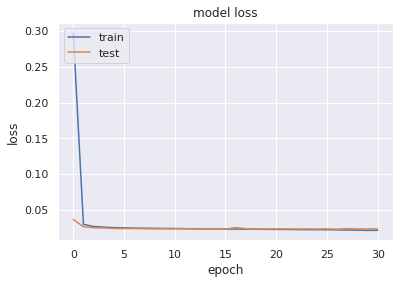

start fold 4
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2973 - binary_crossentropy: 0.2953 - val_loss: 0.0360 - val_binary_crossentropy: 0.0308
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0300 - binary_crossentropy: 0.0249 - val_loss: 0.0266 - val_binary_crossentropy: 0.0210
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0270 - binary_crossentropy: 0.0212 - val_loss: 0.0253 - val_binary_crossentropy: 0.0196
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0260 - binary_crossentropy: 0.0200 - val_loss: 0.0246 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0244 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0186 - val_loss: 0.0242 - val_binary_crossentropy: 0.0180
Epo

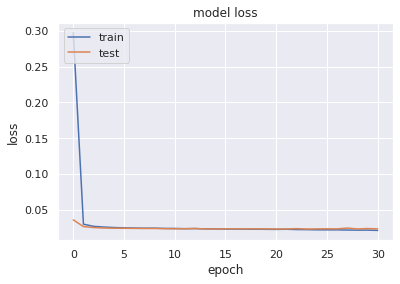

start fold 5
Epoch 1/80
160/160 [==============================] - 1s 8ms/step - loss: 0.2967 - binary_crossentropy: 0.2946 - val_loss: 0.0358 - val_binary_crossentropy: 0.0309
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0296 - binary_crossentropy: 0.0245 - val_loss: 0.0275 - val_binary_crossentropy: 0.0220
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0269 - binary_crossentropy: 0.0211 - val_loss: 0.0261 - val_binary_crossentropy: 0.0200
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0255 - binary_crossentropy: 0.0195 - val_loss: 0.0248 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0250 - binary_crossentropy: 0.0189 - val_loss: 0.0246 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0185 - val_loss: 0.0244 - val_binary_crossentropy: 0.0182
Ep

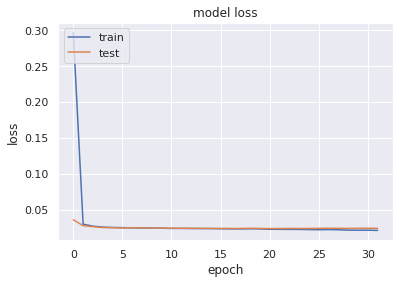

start fold 6
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2981 - binary_crossentropy: 0.2960 - val_loss: 0.0357 - val_binary_crossentropy: 0.0312
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0302 - binary_crossentropy: 0.0251 - val_loss: 0.0268 - val_binary_crossentropy: 0.0211
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0267 - binary_crossentropy: 0.0209 - val_loss: 0.0251 - val_binary_crossentropy: 0.0193
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0256 - binary_crossentropy: 0.0196 - val_loss: 0.0246 - val_binary_crossentropy: 0.0185
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0245 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0186 - val_loss: 0.0240 - val_binary_crossentropy: 0.0178
Epo

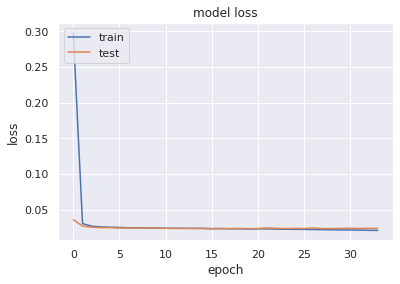

start fold 7
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2977 - binary_crossentropy: 0.2957 - val_loss: 0.0364 - val_binary_crossentropy: 0.0318
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0302 - binary_crossentropy: 0.0251 - val_loss: 0.0270 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0269 - binary_crossentropy: 0.0212 - val_loss: 0.0254 - val_binary_crossentropy: 0.0194
Epoch 4/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0258 - binary_crossentropy: 0.0198 - val_loss: 0.0245 - val_binary_crossentropy: 0.0184
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0253 - binary_crossentropy: 0.0191 - val_loss: 0.0241 - val_binary_crossentropy: 0.0180
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0243 - val_binary_crossentropy: 0.0180
Epo

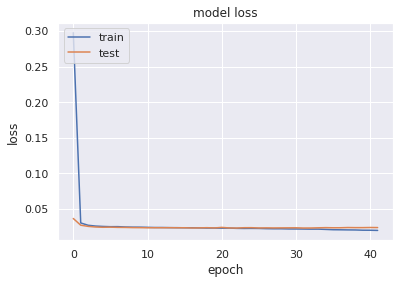

start fold 8
Epoch 1/80
160/160 [==============================] - 1s 8ms/step - loss: 0.2961 - binary_crossentropy: 0.2940 - val_loss: 0.0351 - val_binary_crossentropy: 0.0301
Epoch 2/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0301 - binary_crossentropy: 0.0250 - val_loss: 0.0275 - val_binary_crossentropy: 0.0218
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0268 - binary_crossentropy: 0.0210 - val_loss: 0.0253 - val_binary_crossentropy: 0.0195
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0197 - val_loss: 0.0245 - val_binary_crossentropy: 0.0185
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0251 - binary_crossentropy: 0.0190 - val_loss: 0.0243 - val_binary_crossentropy: 0.0180
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0249 - binary_crossentropy: 0.0186 - val_loss: 0.0240 - val_binary_crossentropy: 0.0176
Epo

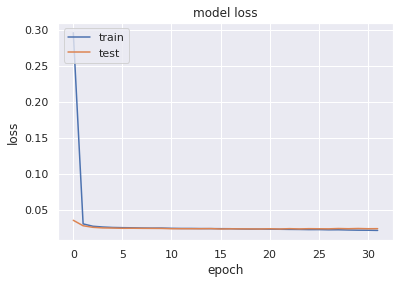

start fold 9
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2988 - binary_crossentropy: 0.2968 - val_loss: 0.0341 - val_binary_crossentropy: 0.0295
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0303 - binary_crossentropy: 0.0252 - val_loss: 0.0278 - val_binary_crossentropy: 0.0221
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0270 - binary_crossentropy: 0.0212 - val_loss: 0.0257 - val_binary_crossentropy: 0.0197
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0260 - binary_crossentropy: 0.0199 - val_loss: 0.0250 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0253 - binary_crossentropy: 0.0191 - val_loss: 0.0244 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0242 - val_binary_crossentropy: 0.0178
Epo

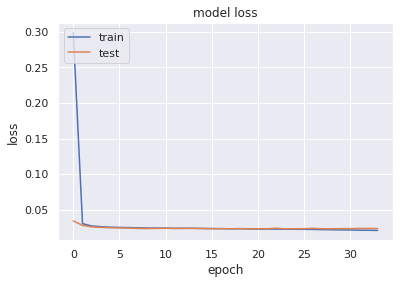

Our out of folds mean log loss score is 0.01669970610087885
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.2980 - binary_crossentropy: 0.2960 - val_loss: 0.0330 - val_binary_crossentropy: 0.0284
Epoch 2/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0303 - binary_crossentropy: 0.0252 - val_loss: 0.0272 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0271 - binary_crossentropy: 0.0213 - val_loss: 0.0255 - val_binary_crossentropy: 0.0197
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0197 - val_loss: 0.0246 - val_binary_crossentropy: 0.0185
Epoch 5/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0255 - binary_crossentropy: 0.0193 - val_loss: 0.0247 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0249 - binary_crossentropy: 0.

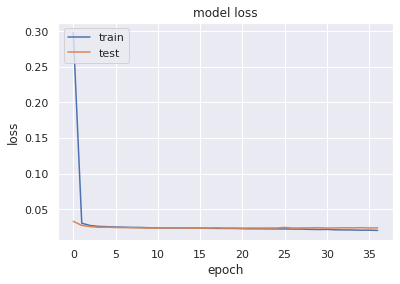

start fold 1
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2984 - binary_crossentropy: 0.2964 - val_loss: 0.0338 - val_binary_crossentropy: 0.0291
Epoch 2/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0300 - binary_crossentropy: 0.0249 - val_loss: 0.0268 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0266 - binary_crossentropy: 0.0209 - val_loss: 0.0253 - val_binary_crossentropy: 0.0195
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0198 - val_loss: 0.0245 - val_binary_crossentropy: 0.0185
Epoch 5/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0242 - val_binary_crossentropy: 0.0180
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0186 - val_loss: 0.0240 - val_binary_crossentropy: 0.0178
Epo

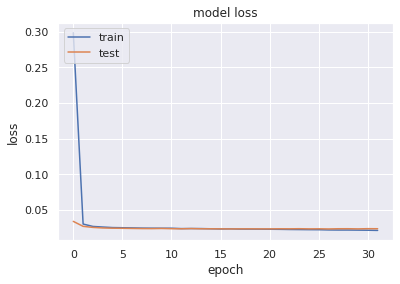

start fold 2
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.2994 - binary_crossentropy: 0.2974 - val_loss: 0.0346 - val_binary_crossentropy: 0.0300
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0299 - binary_crossentropy: 0.0248 - val_loss: 0.0267 - val_binary_crossentropy: 0.0210
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0268 - binary_crossentropy: 0.0210 - val_loss: 0.0255 - val_binary_crossentropy: 0.0197
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0257 - binary_crossentropy: 0.0197 - val_loss: 0.0248 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0253 - binary_crossentropy: 0.0191 - val_loss: 0.0244 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0186 - val_loss: 0.0242 - val_binary_crossentropy: 0.0179
Epo

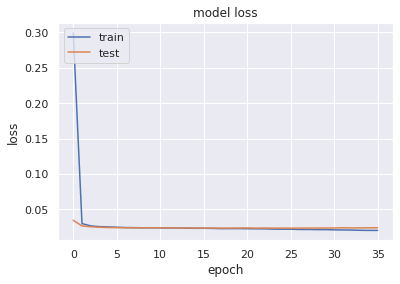

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.2985 - binary_crossentropy: 0.2965 - val_loss: 0.0334 - val_binary_crossentropy: 0.0288
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0248 - val_loss: 0.0270 - val_binary_crossentropy: 0.0213
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0268 - binary_crossentropy: 0.0211 - val_loss: 0.0255 - val_binary_crossentropy: 0.0195
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0257 - binary_crossentropy: 0.0196 - val_loss: 0.0246 - val_binary_crossentropy: 0.0185
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0243 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0248 - binary_crossentropy: 0.0186 - val_loss: 0.0243 - val_binary_crossentropy: 0.0179

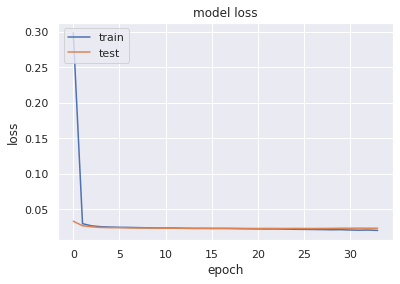

start fold 4
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2988 - binary_crossentropy: 0.2968 - val_loss: 0.0366 - val_binary_crossentropy: 0.0315
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0299 - binary_crossentropy: 0.0248 - val_loss: 0.0279 - val_binary_crossentropy: 0.0222
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0271 - binary_crossentropy: 0.0214 - val_loss: 0.0251 - val_binary_crossentropy: 0.0193
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0259 - binary_crossentropy: 0.0198 - val_loss: 0.0249 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0191 - val_loss: 0.0244 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0185 - val_loss: 0.0240 - val_binary_crossentropy: 0.0177
Epo

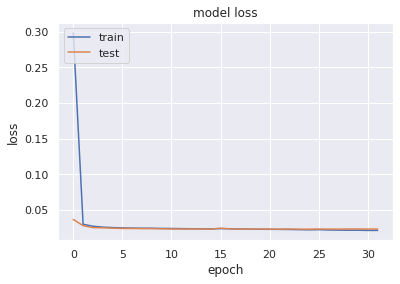

start fold 5
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.2979 - binary_crossentropy: 0.2959 - val_loss: 0.0356 - val_binary_crossentropy: 0.0307
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0301 - binary_crossentropy: 0.0249 - val_loss: 0.0271 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0271 - binary_crossentropy: 0.0213 - val_loss: 0.0254 - val_binary_crossentropy: 0.0194
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0260 - binary_crossentropy: 0.0199 - val_loss: 0.0248 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0253 - binary_crossentropy: 0.0191 - val_loss: 0.0243 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0251 - binary_crossentropy: 0.0188 - val_loss: 0.0243 - val_binary_crossentropy: 0.0179
Epo

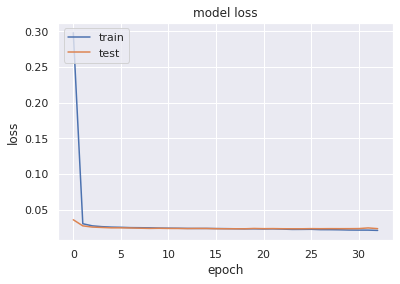

start fold 6
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2985 - binary_crossentropy: 0.2964 - val_loss: 0.0347 - val_binary_crossentropy: 0.0301
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0300 - binary_crossentropy: 0.0249 - val_loss: 0.0273 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0269 - binary_crossentropy: 0.0212 - val_loss: 0.0254 - val_binary_crossentropy: 0.0196
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0259 - binary_crossentropy: 0.0199 - val_loss: 0.0250 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0254 - binary_crossentropy: 0.0192 - val_loss: 0.0244 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0249 - binary_crossentropy: 0.0186 - val_loss: 0.0242 - val_binary_crossentropy: 0.0179
Epo

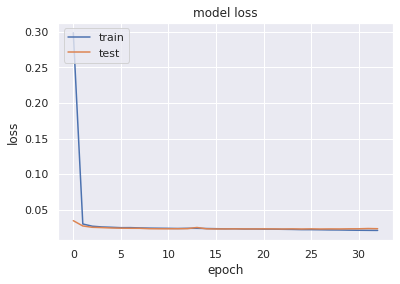

start fold 7
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2988 - binary_crossentropy: 0.2968 - val_loss: 0.0363 - val_binary_crossentropy: 0.0317
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0298 - binary_crossentropy: 0.0247 - val_loss: 0.0271 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0266 - binary_crossentropy: 0.0209 - val_loss: 0.0252 - val_binary_crossentropy: 0.0194
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0257 - binary_crossentropy: 0.0197 - val_loss: 0.0247 - val_binary_crossentropy: 0.0186
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0244 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0250 - binary_crossentropy: 0.0187 - val_loss: 0.0241 - val_binary_crossentropy: 0.0178
Epo

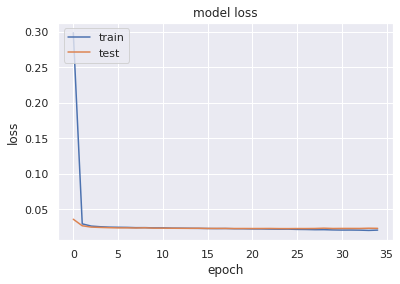

start fold 8
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2989 - binary_crossentropy: 0.2969 - val_loss: 0.0353 - val_binary_crossentropy: 0.0307
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0300 - binary_crossentropy: 0.0249 - val_loss: 0.0278 - val_binary_crossentropy: 0.0222
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0272 - binary_crossentropy: 0.0214 - val_loss: 0.0256 - val_binary_crossentropy: 0.0197
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0259 - binary_crossentropy: 0.0199 - val_loss: 0.0248 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0246 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0246 - val_binary_crossentropy: 0.0182
Epo

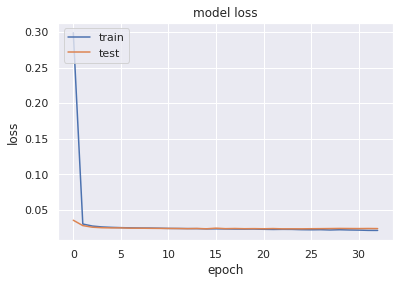

start fold 9
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.2986 - binary_crossentropy: 0.2966 - val_loss: 0.0371 - val_binary_crossentropy: 0.0324
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0298 - binary_crossentropy: 0.0247 - val_loss: 0.0270 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0267 - binary_crossentropy: 0.0209 - val_loss: 0.0252 - val_binary_crossentropy: 0.0194
Epoch 4/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0256 - binary_crossentropy: 0.0196 - val_loss: 0.0248 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0244 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0249 - binary_crossentropy: 0.0186 - val_loss: 0.0242 - val_binary_crossentropy: 0.0178
Epo

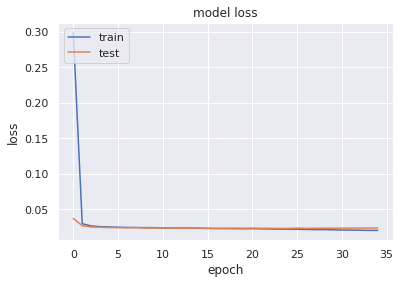

Our out of folds mean log loss score is 0.01663989447522416
start fold 0
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2989 - binary_crossentropy: 0.2969 - val_loss: 0.0343 - val_binary_crossentropy: 0.0297
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0299 - binary_crossentropy: 0.0248 - val_loss: 0.0265 - val_binary_crossentropy: 0.0208
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0268 - binary_crossentropy: 0.0210 - val_loss: 0.0248 - val_binary_crossentropy: 0.0190
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0197 - val_loss: 0.0246 - val_binary_crossentropy: 0.0184
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0241 - val_binary_crossentropy: 0.0178
Epoch 6/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0249 - binary_crossentropy: 0.0

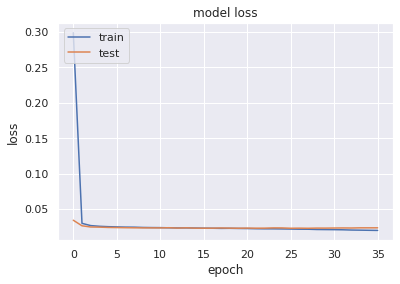

start fold 1
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2973 - binary_crossentropy: 0.2953 - val_loss: 0.0340 - val_binary_crossentropy: 0.0296
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0299 - binary_crossentropy: 0.0248 - val_loss: 0.0272 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0268 - binary_crossentropy: 0.0210 - val_loss: 0.0254 - val_binary_crossentropy: 0.0196
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0260 - binary_crossentropy: 0.0199 - val_loss: 0.0255 - val_binary_crossentropy: 0.0192
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0253 - binary_crossentropy: 0.0191 - val_loss: 0.0245 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0251 - binary_crossentropy: 0.0188 - val_loss: 0.0244 - val_binary_crossentropy: 0.0183
Epo

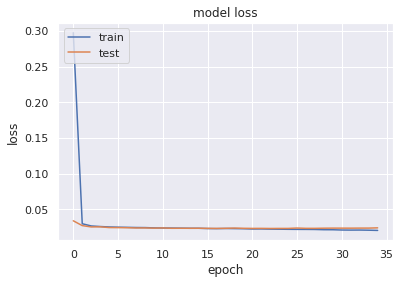

start fold 2
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2964 - binary_crossentropy: 0.2943 - val_loss: 0.0343 - val_binary_crossentropy: 0.0296
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0295 - binary_crossentropy: 0.0244 - val_loss: 0.0267 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0266 - binary_crossentropy: 0.0208 - val_loss: 0.0256 - val_binary_crossentropy: 0.0197
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0257 - binary_crossentropy: 0.0197 - val_loss: 0.0250 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0191 - val_loss: 0.0246 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0247 - binary_crossentropy: 0.0185 - val_loss: 0.0245 - val_binary_crossentropy: 0.0180
Epo

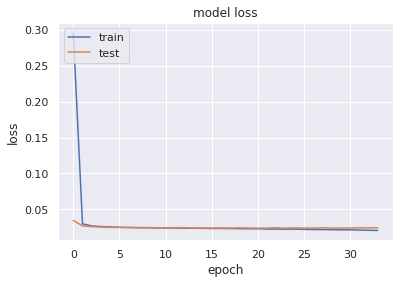

start fold 3
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2987 - binary_crossentropy: 0.2966 - val_loss: 0.0347 - val_binary_crossentropy: 0.0301
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0300 - binary_crossentropy: 0.0249 - val_loss: 0.0273 - val_binary_crossentropy: 0.0218
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0270 - binary_crossentropy: 0.0212 - val_loss: 0.0253 - val_binary_crossentropy: 0.0194
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0197 - val_loss: 0.0249 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0246 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0243 - val_binary_crossentropy: 0.0180
Epo

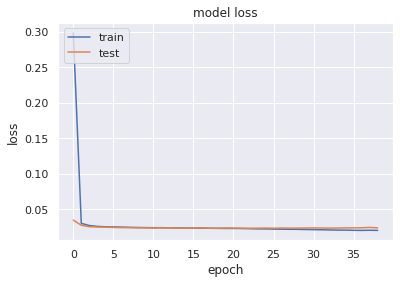

start fold 4
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2989 - binary_crossentropy: 0.2969 - val_loss: 0.0345 - val_binary_crossentropy: 0.0297
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0298 - binary_crossentropy: 0.0247 - val_loss: 0.0264 - val_binary_crossentropy: 0.0209
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0268 - binary_crossentropy: 0.0210 - val_loss: 0.0250 - val_binary_crossentropy: 0.0191
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0261 - binary_crossentropy: 0.0200 - val_loss: 0.0250 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0242 - val_binary_crossentropy: 0.0180
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0249 - binary_crossentropy: 0.0186 - val_loss: 0.0240 - val_binary_crossentropy: 0.0177
Epo

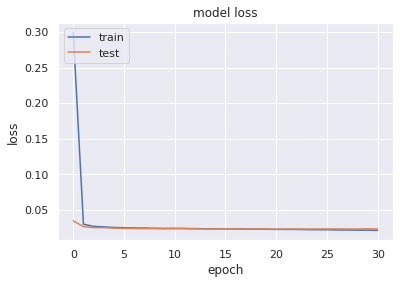

start fold 5
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2955 - binary_crossentropy: 0.2934 - val_loss: 0.0339 - val_binary_crossentropy: 0.0294
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0298 - binary_crossentropy: 0.0247 - val_loss: 0.0280 - val_binary_crossentropy: 0.0224
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0268 - binary_crossentropy: 0.0210 - val_loss: 0.0260 - val_binary_crossentropy: 0.0202
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0257 - binary_crossentropy: 0.0196 - val_loss: 0.0252 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0250 - binary_crossentropy: 0.0189 - val_loss: 0.0246 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0186 - val_loss: 0.0244 - val_binary_crossentropy: 0.0181
Epo

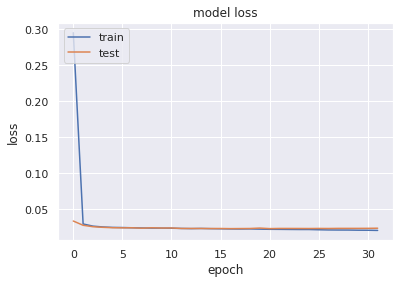

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.2971 - binary_crossentropy: 0.2951 - val_loss: 0.0338 - val_binary_crossentropy: 0.0291
Epoch 2/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0299 - binary_crossentropy: 0.0248 - val_loss: 0.0267 - val_binary_crossentropy: 0.0211
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0267 - binary_crossentropy: 0.0209 - val_loss: 0.0251 - val_binary_crossentropy: 0.0192
Epoch 4/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0257 - binary_crossentropy: 0.0196 - val_loss: 0.0245 - val_binary_crossentropy: 0.0184
Epoch 5/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0242 - val_binary_crossentropy: 0.0180
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0247 - binary_crossentropy: 0.0184 - val_loss: 0.0238 - val_binary_crossentropy: 0.0176
Ep

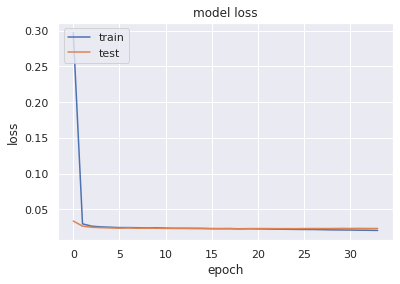

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.2987 - binary_crossentropy: 0.2967 - val_loss: 0.0362 - val_binary_crossentropy: 0.0314
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0298 - binary_crossentropy: 0.0247 - val_loss: 0.0264 - val_binary_crossentropy: 0.0208
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0267 - binary_crossentropy: 0.0209 - val_loss: 0.0251 - val_binary_crossentropy: 0.0193
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0256 - binary_crossentropy: 0.0196 - val_loss: 0.0244 - val_binary_crossentropy: 0.0185
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0241 - val_binary_crossentropy: 0.0179
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0246 - binary_crossentropy: 0.0184 - val_loss: 0.0238 - val_binary_crossentropy: 0.0176
Ep

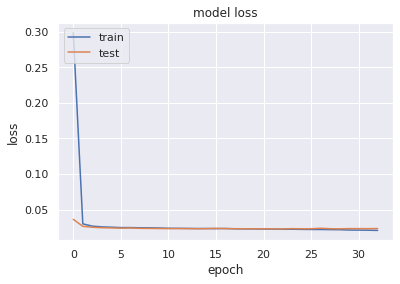

start fold 8
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2973 - binary_crossentropy: 0.2953 - val_loss: 0.0357 - val_binary_crossentropy: 0.0311
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0299 - binary_crossentropy: 0.0248 - val_loss: 0.0270 - val_binary_crossentropy: 0.0215
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0269 - binary_crossentropy: 0.0212 - val_loss: 0.0255 - val_binary_crossentropy: 0.0197
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0198 - val_loss: 0.0249 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0253 - binary_crossentropy: 0.0192 - val_loss: 0.0250 - val_binary_crossentropy: 0.0186
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0242 - val_binary_crossentropy: 0.0179
Epo

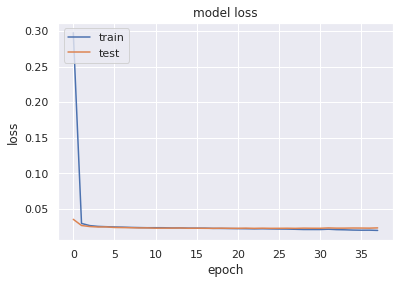

start fold 9
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2955 - binary_crossentropy: 0.2934 - val_loss: 0.0344 - val_binary_crossentropy: 0.0298
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0300 - binary_crossentropy: 0.0249 - val_loss: 0.0269 - val_binary_crossentropy: 0.0215
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0266 - binary_crossentropy: 0.0209 - val_loss: 0.0253 - val_binary_crossentropy: 0.0196
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0256 - binary_crossentropy: 0.0196 - val_loss: 0.0246 - val_binary_crossentropy: 0.0186
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0251 - binary_crossentropy: 0.0190 - val_loss: 0.0244 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0249 - binary_crossentropy: 0.0186 - val_loss: 0.0244 - val_binary_crossentropy: 0.0182
Epo

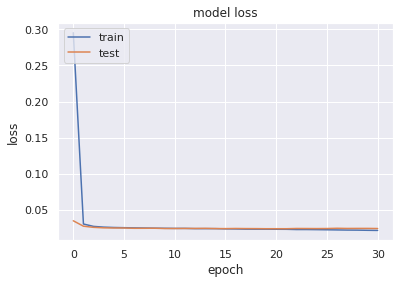

Our out of folds mean log loss score is 0.01673677197815805
start fold 0
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.3000 - binary_crossentropy: 0.2979 - val_loss: 0.0346 - val_binary_crossentropy: 0.0300
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0302 - binary_crossentropy: 0.0251 - val_loss: 0.0268 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0269 - binary_crossentropy: 0.0211 - val_loss: 0.0254 - val_binary_crossentropy: 0.0196
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0259 - binary_crossentropy: 0.0198 - val_loss: 0.0246 - val_binary_crossentropy: 0.0186
Epoch 5/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0241 - val_binary_crossentropy: 0.0180
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0249 - binary_crossentropy: 0.0

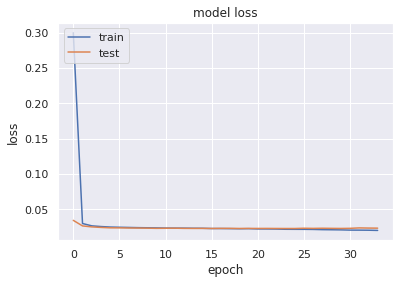

start fold 1
Epoch 1/80
160/160 [==============================] - 1s 8ms/step - loss: 0.2974 - binary_crossentropy: 0.2954 - val_loss: 0.0349 - val_binary_crossentropy: 0.0300
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0298 - binary_crossentropy: 0.0246 - val_loss: 0.0268 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0266 - binary_crossentropy: 0.0208 - val_loss: 0.0250 - val_binary_crossentropy: 0.0192
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0256 - binary_crossentropy: 0.0196 - val_loss: 0.0245 - val_binary_crossentropy: 0.0185
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0251 - binary_crossentropy: 0.0190 - val_loss: 0.0243 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0250 - binary_crossentropy: 0.0187 - val_loss: 0.0243 - val_binary_crossentropy: 0.0179
Epo

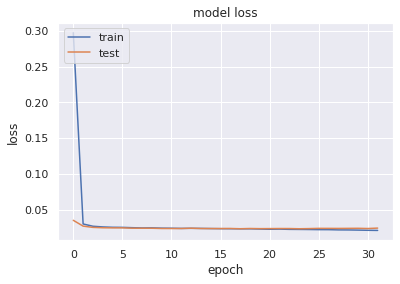

start fold 2
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2981 - binary_crossentropy: 0.2961 - val_loss: 0.0333 - val_binary_crossentropy: 0.0287
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0297 - binary_crossentropy: 0.0246 - val_loss: 0.0269 - val_binary_crossentropy: 0.0213
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0268 - binary_crossentropy: 0.0211 - val_loss: 0.0250 - val_binary_crossentropy: 0.0192
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0198 - val_loss: 0.0245 - val_binary_crossentropy: 0.0184
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0191 - val_loss: 0.0242 - val_binary_crossentropy: 0.0179
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0248 - binary_crossentropy: 0.0186 - val_loss: 0.0239 - val_binary_crossentropy: 0.0176
Epo

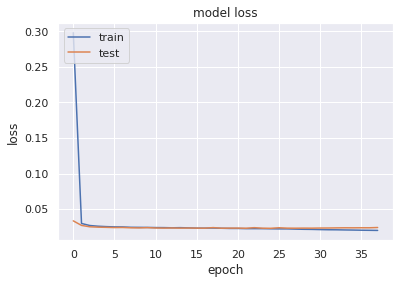

start fold 3
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.2974 - binary_crossentropy: 0.2953 - val_loss: 0.0351 - val_binary_crossentropy: 0.0305
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0300 - binary_crossentropy: 0.0249 - val_loss: 0.0272 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0267 - binary_crossentropy: 0.0209 - val_loss: 0.0251 - val_binary_crossentropy: 0.0193
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0197 - val_loss: 0.0246 - val_binary_crossentropy: 0.0185
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0242 - val_binary_crossentropy: 0.0179
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0185 - val_loss: 0.0240 - val_binary_crossentropy: 0.0177
Epo

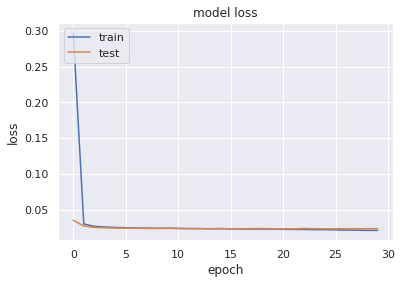

start fold 4
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2960 - binary_crossentropy: 0.2940 - val_loss: 0.0353 - val_binary_crossentropy: 0.0306
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0297 - binary_crossentropy: 0.0246 - val_loss: 0.0271 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0267 - binary_crossentropy: 0.0209 - val_loss: 0.0253 - val_binary_crossentropy: 0.0196
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0256 - binary_crossentropy: 0.0195 - val_loss: 0.0249 - val_binary_crossentropy: 0.0186
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0244 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0242 - val_binary_crossentropy: 0.0181
Epo

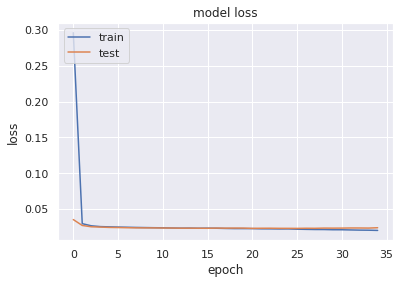

start fold 5
Epoch 1/80
160/160 [==============================] - 1s 8ms/step - loss: 0.2973 - binary_crossentropy: 0.2952 - val_loss: 0.0356 - val_binary_crossentropy: 0.0309
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0297 - binary_crossentropy: 0.0245 - val_loss: 0.0266 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0264 - binary_crossentropy: 0.0207 - val_loss: 0.0250 - val_binary_crossentropy: 0.0192
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0255 - binary_crossentropy: 0.0195 - val_loss: 0.0245 - val_binary_crossentropy: 0.0185
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0191 - val_loss: 0.0244 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0253 - val_binary_crossentropy: 0.0186
Epo

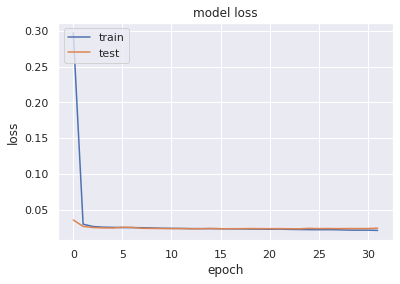

start fold 6
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.3009 - binary_crossentropy: 0.2989 - val_loss: 0.0325 - val_binary_crossentropy: 0.0277
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0296 - binary_crossentropy: 0.0245 - val_loss: 0.0271 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0267 - binary_crossentropy: 0.0210 - val_loss: 0.0250 - val_binary_crossentropy: 0.0193
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0256 - binary_crossentropy: 0.0195 - val_loss: 0.0249 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0243 - val_binary_crossentropy: 0.0180
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0247 - binary_crossentropy: 0.0185 - val_loss: 0.0244 - val_binary_crossentropy: 0.0180
Epo

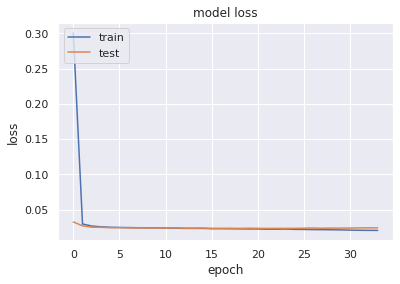

start fold 7
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2967 - binary_crossentropy: 0.2947 - val_loss: 0.0339 - val_binary_crossentropy: 0.0293
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0298 - binary_crossentropy: 0.0247 - val_loss: 0.0269 - val_binary_crossentropy: 0.0213
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0267 - binary_crossentropy: 0.0210 - val_loss: 0.0253 - val_binary_crossentropy: 0.0195
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0257 - binary_crossentropy: 0.0196 - val_loss: 0.0246 - val_binary_crossentropy: 0.0185
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0253 - binary_crossentropy: 0.0191 - val_loss: 0.0243 - val_binary_crossentropy: 0.0180
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0185 - val_loss: 0.0239 - val_binary_crossentropy: 0.0175
Epo

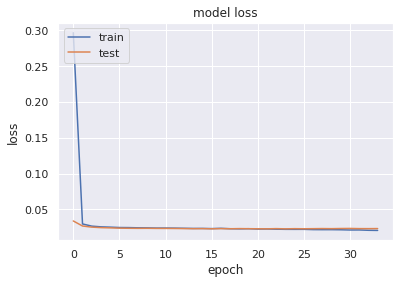

start fold 8
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2985 - binary_crossentropy: 0.2964 - val_loss: 0.0353 - val_binary_crossentropy: 0.0306
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0297 - binary_crossentropy: 0.0246 - val_loss: 0.0274 - val_binary_crossentropy: 0.0218
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0268 - binary_crossentropy: 0.0210 - val_loss: 0.0262 - val_binary_crossentropy: 0.0203
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0256 - binary_crossentropy: 0.0195 - val_loss: 0.0253 - val_binary_crossentropy: 0.0192
Epoch 5/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0250 - val_binary_crossentropy: 0.0186
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0247 - binary_crossentropy: 0.0184 - val_loss: 0.0252 - val_binary_crossentropy: 0.0187
Epo

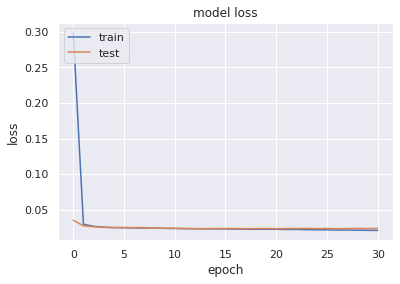

start fold 9
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2998 - binary_crossentropy: 0.2978 - val_loss: 0.0345 - val_binary_crossentropy: 0.0297
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0297 - binary_crossentropy: 0.0247 - val_loss: 0.0274 - val_binary_crossentropy: 0.0219
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0268 - binary_crossentropy: 0.0210 - val_loss: 0.0251 - val_binary_crossentropy: 0.0192
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0260 - binary_crossentropy: 0.0200 - val_loss: 0.0247 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0254 - binary_crossentropy: 0.0192 - val_loss: 0.0244 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0240 - val_binary_crossentropy: 0.0177
Epo

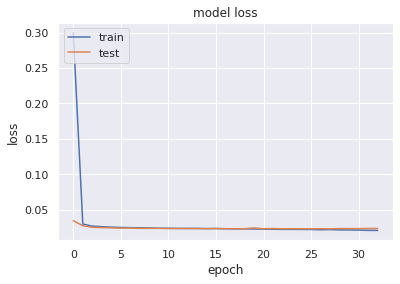

Our out of folds mean log loss score is 0.01674847917837259
start fold 0
Epoch 1/80
160/160 [==============================] - 1s 8ms/step - loss: 0.2994 - binary_crossentropy: 0.2974 - val_loss: 0.0337 - val_binary_crossentropy: 0.0291
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0300 - binary_crossentropy: 0.0249 - val_loss: 0.0271 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0269 - binary_crossentropy: 0.0211 - val_loss: 0.0253 - val_binary_crossentropy: 0.0195
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0198 - val_loss: 0.0248 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0251 - binary_crossentropy: 0.0190 - val_loss: 0.0245 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0249 - binary_crossentropy: 0.0

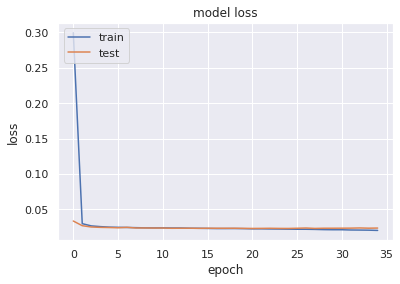

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.2981 - binary_crossentropy: 0.2961 - val_loss: 0.0353 - val_binary_crossentropy: 0.0308
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0306 - binary_crossentropy: 0.0255 - val_loss: 0.0286 - val_binary_crossentropy: 0.0228
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0270 - binary_crossentropy: 0.0212 - val_loss: 0.0257 - val_binary_crossentropy: 0.0196
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0257 - binary_crossentropy: 0.0197 - val_loss: 0.0247 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0245 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0248 - binary_crossentropy: 0.0185 - val_loss: 0.0242 - val_binary_crossentropy: 0.0178
Ep

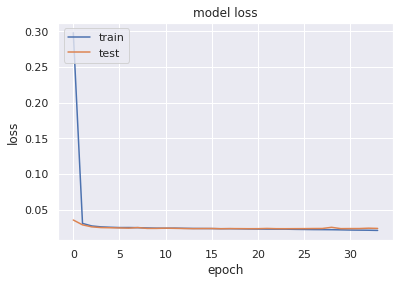

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.2992 - binary_crossentropy: 0.2971 - val_loss: 0.0354 - val_binary_crossentropy: 0.0305
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0248 - val_loss: 0.0280 - val_binary_crossentropy: 0.0224
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0270 - binary_crossentropy: 0.0212 - val_loss: 0.0257 - val_binary_crossentropy: 0.0199
Epoch 4/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0259 - binary_crossentropy: 0.0198 - val_loss: 0.0264 - val_binary_crossentropy: 0.0203
Epoch 5/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0257 - binary_crossentropy: 0.0195 - val_loss: 0.0254 - val_binary_crossentropy: 0.0189
Epoch 6/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0252 - binary_crossentropy: 0.0189 - val_loss: 0.0245 - val_binary_crossentropy: 0.0181
E

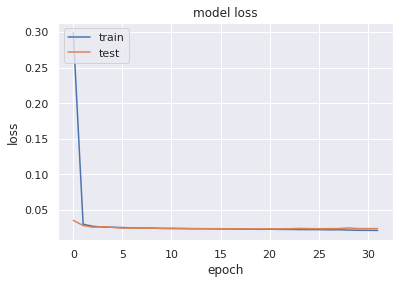

start fold 3
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2992 - binary_crossentropy: 0.2972 - val_loss: 0.0322 - val_binary_crossentropy: 0.0276
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0301 - binary_crossentropy: 0.0249 - val_loss: 0.0268 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0271 - binary_crossentropy: 0.0213 - val_loss: 0.0252 - val_binary_crossentropy: 0.0195
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0198 - val_loss: 0.0249 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0242 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0240 - val_binary_crossentropy: 0.0177
Epo

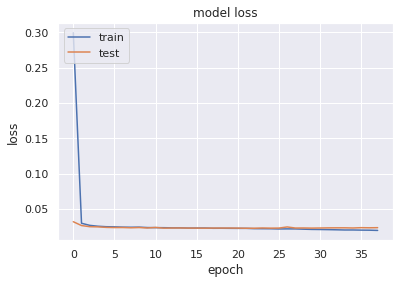

start fold 4
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.2972 - binary_crossentropy: 0.2951 - val_loss: 0.0358 - val_binary_crossentropy: 0.0315
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0298 - binary_crossentropy: 0.0247 - val_loss: 0.0268 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0269 - binary_crossentropy: 0.0212 - val_loss: 0.0258 - val_binary_crossentropy: 0.0200
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0198 - val_loss: 0.0251 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0244 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0250 - binary_crossentropy: 0.0188 - val_loss: 0.0247 - val_binary_crossentropy: 0.0183
Epo

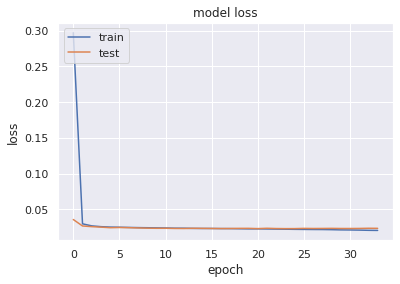

start fold 5
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2988 - binary_crossentropy: 0.2967 - val_loss: 0.0332 - val_binary_crossentropy: 0.0286
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0298 - binary_crossentropy: 0.0247 - val_loss: 0.0265 - val_binary_crossentropy: 0.0209
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0268 - binary_crossentropy: 0.0210 - val_loss: 0.0251 - val_binary_crossentropy: 0.0193
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0198 - val_loss: 0.0249 - val_binary_crossentropy: 0.0191
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0256 - binary_crossentropy: 0.0194 - val_loss: 0.0252 - val_binary_crossentropy: 0.0191
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0189 - val_loss: 0.0243 - val_binary_crossentropy: 0.0180
Epo

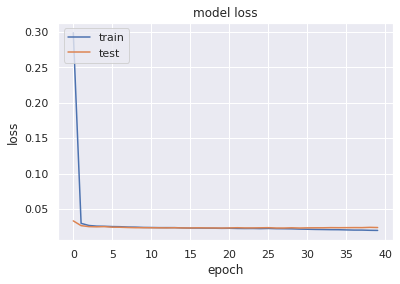

start fold 6
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2966 - binary_crossentropy: 0.2946 - val_loss: 0.0352 - val_binary_crossentropy: 0.0303
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0295 - binary_crossentropy: 0.0244 - val_loss: 0.0268 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0266 - binary_crossentropy: 0.0209 - val_loss: 0.0254 - val_binary_crossentropy: 0.0196
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0256 - binary_crossentropy: 0.0195 - val_loss: 0.0249 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0242 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0247 - binary_crossentropy: 0.0185 - val_loss: 0.0243 - val_binary_crossentropy: 0.0181
Epo

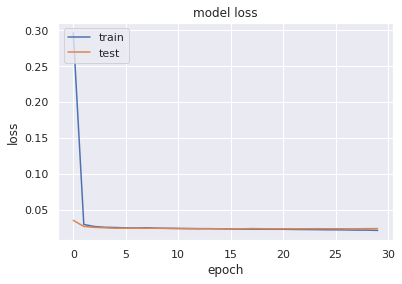

start fold 7
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2966 - binary_crossentropy: 0.2946 - val_loss: 0.0330 - val_binary_crossentropy: 0.0284
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0300 - binary_crossentropy: 0.0249 - val_loss: 0.0268 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0269 - binary_crossentropy: 0.0211 - val_loss: 0.0252 - val_binary_crossentropy: 0.0193
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0257 - binary_crossentropy: 0.0197 - val_loss: 0.0252 - val_binary_crossentropy: 0.0191
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0253 - binary_crossentropy: 0.0191 - val_loss: 0.0243 - val_binary_crossentropy: 0.0180
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0186 - val_loss: 0.0239 - val_binary_crossentropy: 0.0177
Epo

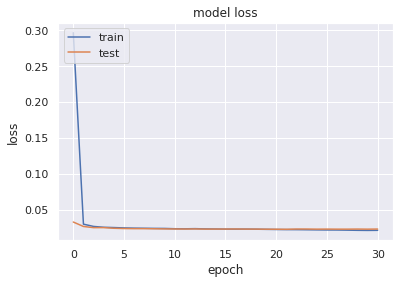

start fold 8
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.2974 - binary_crossentropy: 0.2953 - val_loss: 0.0357 - val_binary_crossentropy: 0.0311
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0299 - binary_crossentropy: 0.0247 - val_loss: 0.0267 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0267 - binary_crossentropy: 0.0209 - val_loss: 0.0254 - val_binary_crossentropy: 0.0195
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0198 - val_loss: 0.0247 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0251 - binary_crossentropy: 0.0189 - val_loss: 0.0244 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0185 - val_loss: 0.0242 - val_binary_crossentropy: 0.0179
Epo

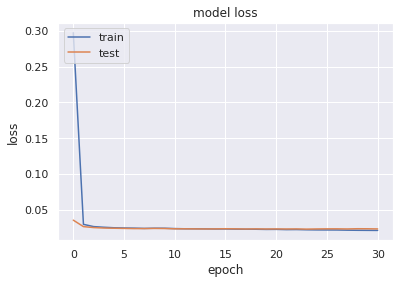

start fold 9
Epoch 1/80
160/160 [==============================] - 1s 8ms/step - loss: 0.2973 - binary_crossentropy: 0.2953 - val_loss: 0.0339 - val_binary_crossentropy: 0.0292
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0300 - binary_crossentropy: 0.0249 - val_loss: 0.0268 - val_binary_crossentropy: 0.0210
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0268 - binary_crossentropy: 0.0211 - val_loss: 0.0250 - val_binary_crossentropy: 0.0192
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0197 - val_loss: 0.0244 - val_binary_crossentropy: 0.0184
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0242 - val_binary_crossentropy: 0.0180
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0186 - val_loss: 0.0238 - val_binary_crossentropy: 0.0176
Epo

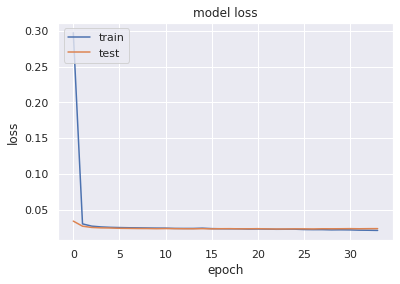

Our out of folds mean log loss score is 0.01670834197654444
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 9ms/step - loss: 0.2993 - binary_crossentropy: 0.2973 - val_loss: 0.0337 - val_binary_crossentropy: 0.0290
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0298 - binary_crossentropy: 0.0247 - val_loss: 0.0267 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0267 - binary_crossentropy: 0.0210 - val_loss: 0.0251 - val_binary_crossentropy: 0.0192
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0257 - binary_crossentropy: 0.0196 - val_loss: 0.0244 - val_binary_crossentropy: 0.0185
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0251 - binary_crossentropy: 0.0190 - val_loss: 0.0242 - val_binary_crossentropy: 0.0179
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0

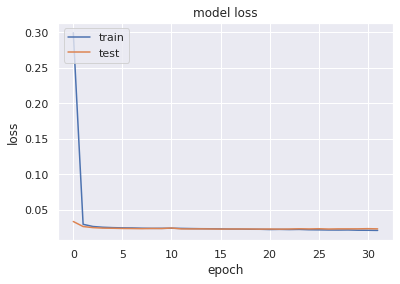

start fold 1
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2974 - binary_crossentropy: 0.2954 - val_loss: 0.0351 - val_binary_crossentropy: 0.0304
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0296 - binary_crossentropy: 0.0245 - val_loss: 0.0268 - val_binary_crossentropy: 0.0213
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0266 - binary_crossentropy: 0.0209 - val_loss: 0.0253 - val_binary_crossentropy: 0.0194
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0257 - binary_crossentropy: 0.0196 - val_loss: 0.0249 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0250 - binary_crossentropy: 0.0189 - val_loss: 0.0242 - val_binary_crossentropy: 0.0180
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0249 - binary_crossentropy: 0.0186 - val_loss: 0.0250 - val_binary_crossentropy: 0.0186
Epo

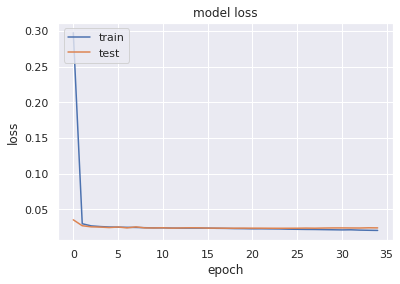

start fold 2
Epoch 1/80
160/160 [==============================] - 1s 8ms/step - loss: 0.2979 - binary_crossentropy: 0.2959 - val_loss: 0.0338 - val_binary_crossentropy: 0.0291
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0295 - binary_crossentropy: 0.0244 - val_loss: 0.0268 - val_binary_crossentropy: 0.0213
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0266 - binary_crossentropy: 0.0209 - val_loss: 0.0251 - val_binary_crossentropy: 0.0193
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0257 - binary_crossentropy: 0.0197 - val_loss: 0.0251 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0244 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0250 - binary_crossentropy: 0.0187 - val_loss: 0.0242 - val_binary_crossentropy: 0.0178
Epo

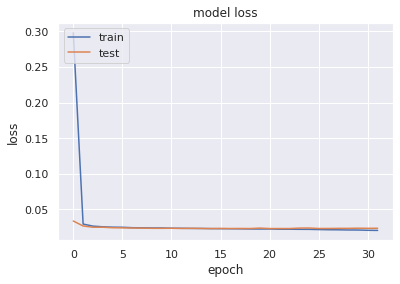

start fold 3
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2974 - binary_crossentropy: 0.2954 - val_loss: 0.0340 - val_binary_crossentropy: 0.0293
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0298 - binary_crossentropy: 0.0247 - val_loss: 0.0269 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0267 - binary_crossentropy: 0.0210 - val_loss: 0.0251 - val_binary_crossentropy: 0.0192
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0256 - binary_crossentropy: 0.0196 - val_loss: 0.0245 - val_binary_crossentropy: 0.0185
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0253 - binary_crossentropy: 0.0191 - val_loss: 0.0243 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0185 - val_loss: 0.0239 - val_binary_crossentropy: 0.0177
Epo

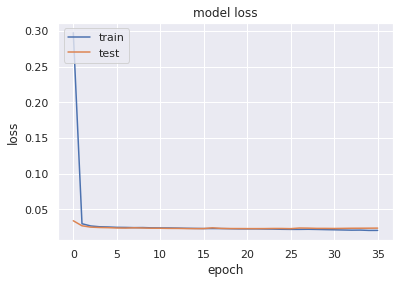

start fold 4
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2981 - binary_crossentropy: 0.2961 - val_loss: 0.0343 - val_binary_crossentropy: 0.0297
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0301 - binary_crossentropy: 0.0250 - val_loss: 0.0270 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0269 - binary_crossentropy: 0.0212 - val_loss: 0.0255 - val_binary_crossentropy: 0.0197
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0257 - binary_crossentropy: 0.0196 - val_loss: 0.0247 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0253 - binary_crossentropy: 0.0191 - val_loss: 0.0245 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0243 - val_binary_crossentropy: 0.0179
Epo

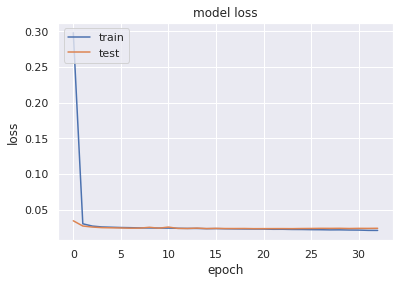

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.3000 - binary_crossentropy: 0.2980 - val_loss: 0.0338 - val_binary_crossentropy: 0.0289
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0297 - binary_crossentropy: 0.0246 - val_loss: 0.0270 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0267 - binary_crossentropy: 0.0209 - val_loss: 0.0251 - val_binary_crossentropy: 0.0192
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0257 - binary_crossentropy: 0.0197 - val_loss: 0.0248 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0252 - binary_crossentropy: 0.0191 - val_loss: 0.0244 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0247 - binary_crossentropy: 0.0184 - val_loss: 0.0240 - val_binary_crossentropy: 0.0177


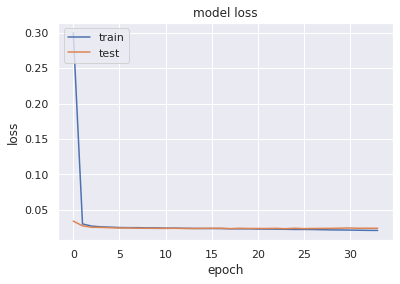

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.2969 - binary_crossentropy: 0.2948 - val_loss: 0.0355 - val_binary_crossentropy: 0.0307
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0303 - binary_crossentropy: 0.0252 - val_loss: 0.0273 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0269 - binary_crossentropy: 0.0212 - val_loss: 0.0274 - val_binary_crossentropy: 0.0213
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0261 - binary_crossentropy: 0.0200 - val_loss: 0.0261 - val_binary_crossentropy: 0.0196
Epoch 5/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0255 - binary_crossentropy: 0.0192 - val_loss: 0.0246 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0251 - binary_crossentropy: 0.0188 - val_loss: 0.0245 - val_binary_crossentropy: 0.0181
Ep

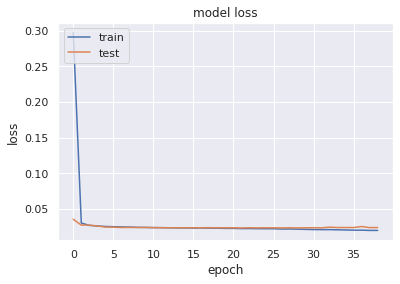

start fold 7
Epoch 1/80
160/160 [==============================] - 1s 8ms/step - loss: 0.2990 - binary_crossentropy: 0.2969 - val_loss: 0.0350 - val_binary_crossentropy: 0.0303
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0298 - binary_crossentropy: 0.0247 - val_loss: 0.0271 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0267 - binary_crossentropy: 0.0209 - val_loss: 0.0252 - val_binary_crossentropy: 0.0194
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0257 - binary_crossentropy: 0.0196 - val_loss: 0.0247 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0251 - binary_crossentropy: 0.0190 - val_loss: 0.0245 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0186 - val_loss: 0.0242 - val_binary_crossentropy: 0.0179
Epo

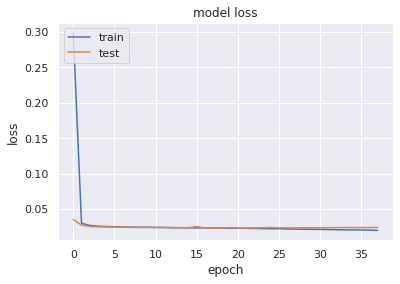

start fold 8
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.2973 - binary_crossentropy: 0.2952 - val_loss: 0.0330 - val_binary_crossentropy: 0.0283
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0298 - binary_crossentropy: 0.0247 - val_loss: 0.0268 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0268 - binary_crossentropy: 0.0211 - val_loss: 0.0253 - val_binary_crossentropy: 0.0195
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0259 - binary_crossentropy: 0.0198 - val_loss: 0.0248 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0254 - binary_crossentropy: 0.0192 - val_loss: 0.0246 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0251 - binary_crossentropy: 0.0188 - val_loss: 0.0251 - val_binary_crossentropy: 0.0183
Epo

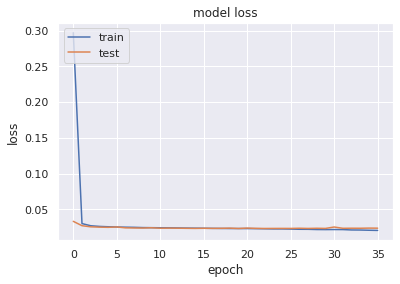

start fold 9
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2985 - binary_crossentropy: 0.2965 - val_loss: 0.0353 - val_binary_crossentropy: 0.0304
Epoch 2/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0300 - binary_crossentropy: 0.0249 - val_loss: 0.0270 - val_binary_crossentropy: 0.0213
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0269 - binary_crossentropy: 0.0211 - val_loss: 0.0252 - val_binary_crossentropy: 0.0194
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0256 - binary_crossentropy: 0.0196 - val_loss: 0.0246 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0242 - val_binary_crossentropy: 0.0180
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0248 - binary_crossentropy: 0.0186 - val_loss: 0.0240 - val_binary_crossentropy: 0.0178
Ep

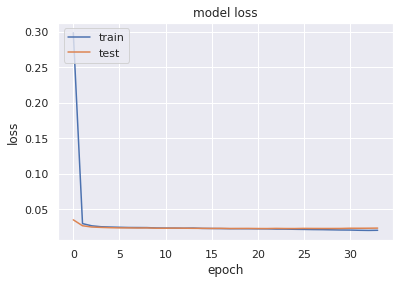

Our out of folds mean log loss score is 0.016705949920498946
start fold 0
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2970 - binary_crossentropy: 0.2950 - val_loss: 0.0374 - val_binary_crossentropy: 0.0331
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0299 - binary_crossentropy: 0.0247 - val_loss: 0.0274 - val_binary_crossentropy: 0.0218
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0267 - binary_crossentropy: 0.0209 - val_loss: 0.0258 - val_binary_crossentropy: 0.0201
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0256 - binary_crossentropy: 0.0195 - val_loss: 0.0249 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0247 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0247 - binary_crossentropy: 0.

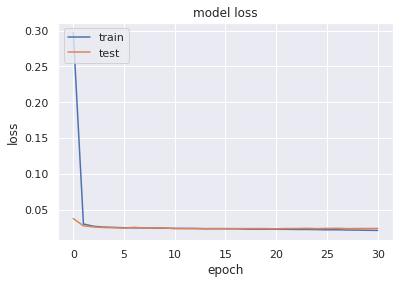

start fold 1
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2985 - binary_crossentropy: 0.2965 - val_loss: 0.0359 - val_binary_crossentropy: 0.0315
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0300 - binary_crossentropy: 0.0250 - val_loss: 0.0270 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0268 - binary_crossentropy: 0.0210 - val_loss: 0.0256 - val_binary_crossentropy: 0.0197
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0259 - binary_crossentropy: 0.0199 - val_loss: 0.0249 - val_binary_crossentropy: 0.0189
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0191 - val_loss: 0.0245 - val_binary_crossentropy: 0.0183
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0249 - binary_crossentropy: 0.0187 - val_loss: 0.0241 - val_binary_crossentropy: 0.0179
Epo

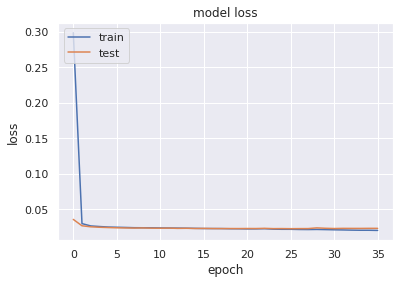

start fold 2
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.2973 - binary_crossentropy: 0.2953 - val_loss: 0.0336 - val_binary_crossentropy: 0.0290
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0298 - binary_crossentropy: 0.0247 - val_loss: 0.0265 - val_binary_crossentropy: 0.0209
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0268 - binary_crossentropy: 0.0211 - val_loss: 0.0251 - val_binary_crossentropy: 0.0194
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0257 - binary_crossentropy: 0.0196 - val_loss: 0.0246 - val_binary_crossentropy: 0.0187
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0244 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0248 - binary_crossentropy: 0.0186 - val_loss: 0.0241 - val_binary_crossentropy: 0.0178
Epo

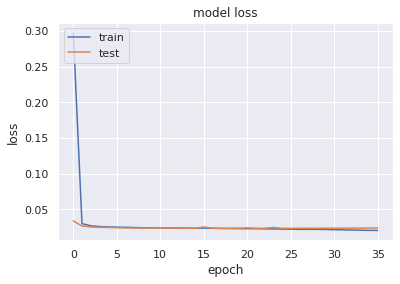

start fold 3
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2983 - binary_crossentropy: 0.2963 - val_loss: 0.0348 - val_binary_crossentropy: 0.0299
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0300 - binary_crossentropy: 0.0250 - val_loss: 0.0284 - val_binary_crossentropy: 0.0225
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0271 - binary_crossentropy: 0.0214 - val_loss: 0.0259 - val_binary_crossentropy: 0.0200
Epoch 4/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0259 - binary_crossentropy: 0.0199 - val_loss: 0.0252 - val_binary_crossentropy: 0.0191
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0254 - binary_crossentropy: 0.0192 - val_loss: 0.0248 - val_binary_crossentropy: 0.0185
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0250 - binary_crossentropy: 0.0187 - val_loss: 0.0241 - val_binary_crossentropy: 0.0179
Epo

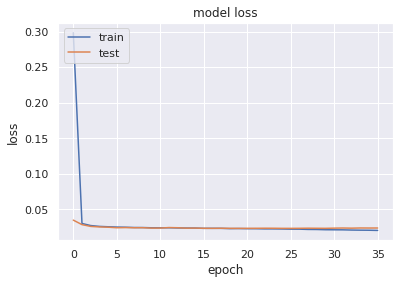

start fold 4
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2980 - binary_crossentropy: 0.2959 - val_loss: 0.0346 - val_binary_crossentropy: 0.0298
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0300 - binary_crossentropy: 0.0249 - val_loss: 0.0272 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0268 - binary_crossentropy: 0.0210 - val_loss: 0.0250 - val_binary_crossentropy: 0.0192
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0257 - binary_crossentropy: 0.0196 - val_loss: 0.0246 - val_binary_crossentropy: 0.0185
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0191 - val_loss: 0.0242 - val_binary_crossentropy: 0.0179
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0185 - val_loss: 0.0238 - val_binary_crossentropy: 0.0175
Epo

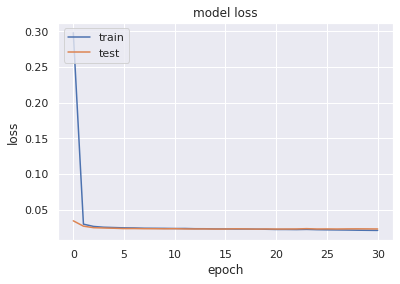

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.2984 - binary_crossentropy: 0.2964 - val_loss: 0.0357 - val_binary_crossentropy: 0.0311
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0299 - binary_crossentropy: 0.0248 - val_loss: 0.0268 - val_binary_crossentropy: 0.0213
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0271 - binary_crossentropy: 0.0213 - val_loss: 0.0254 - val_binary_crossentropy: 0.0195
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0259 - binary_crossentropy: 0.0198 - val_loss: 0.0250 - val_binary_crossentropy: 0.0190
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0245 - val_binary_crossentropy: 0.0182
Epoch 6/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0250 - binary_crossentropy: 0.0187 - val_loss: 0.0247 - val_binary_crossentropy: 0.0183
Ep

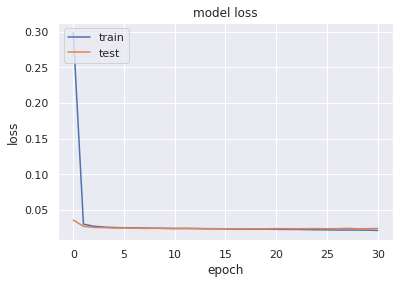

start fold 6
Epoch 1/80
160/160 [==============================] - 1s 7ms/step - loss: 0.2971 - binary_crossentropy: 0.2950 - val_loss: 0.0335 - val_binary_crossentropy: 0.0289
Epoch 2/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0298 - binary_crossentropy: 0.0247 - val_loss: 0.0270 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0268 - binary_crossentropy: 0.0210 - val_loss: 0.0251 - val_binary_crossentropy: 0.0193
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0197 - val_loss: 0.0246 - val_binary_crossentropy: 0.0186
Epoch 5/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0253 - binary_crossentropy: 0.0191 - val_loss: 0.0243 - val_binary_crossentropy: 0.0181
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0250 - binary_crossentropy: 0.0187 - val_loss: 0.0242 - val_binary_crossentropy: 0.0178
Epo

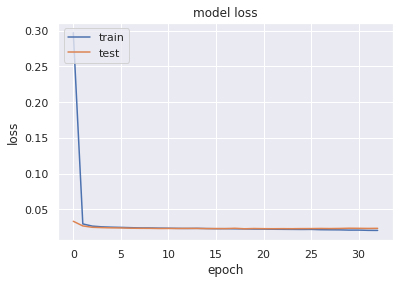

start fold 7
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.2971 - binary_crossentropy: 0.2951 - val_loss: 0.0340 - val_binary_crossentropy: 0.0295
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0300 - binary_crossentropy: 0.0249 - val_loss: 0.0267 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0269 - binary_crossentropy: 0.0212 - val_loss: 0.0254 - val_binary_crossentropy: 0.0195
Epoch 4/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0258 - binary_crossentropy: 0.0197 - val_loss: 0.0249 - val_binary_crossentropy: 0.0186
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0253 - binary_crossentropy: 0.0191 - val_loss: 0.0243 - val_binary_crossentropy: 0.0180
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0248 - binary_crossentropy: 0.0186 - val_loss: 0.0241 - val_binary_crossentropy: 0.0178
Epo

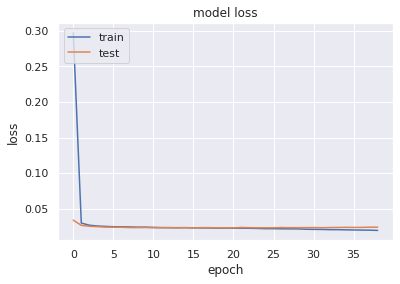

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.2969 - binary_crossentropy: 0.2949 - val_loss: 0.0349 - val_binary_crossentropy: 0.0303
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0298 - binary_crossentropy: 0.0247 - val_loss: 0.0267 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0265 - binary_crossentropy: 0.0208 - val_loss: 0.0252 - val_binary_crossentropy: 0.0194
Epoch 4/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0258 - binary_crossentropy: 0.0197 - val_loss: 0.0249 - val_binary_crossentropy: 0.0191
Epoch 5/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0253 - binary_crossentropy: 0.0191 - val_loss: 0.0243 - val_binary_crossentropy: 0.0180
Epoch 6/80
160/160 [==============================] - 1s 6ms/step - loss: 0.0251 - binary_crossentropy: 0.0188 - val_loss: 0.0243 - val_binary_crossentropy: 0.0179
Ep

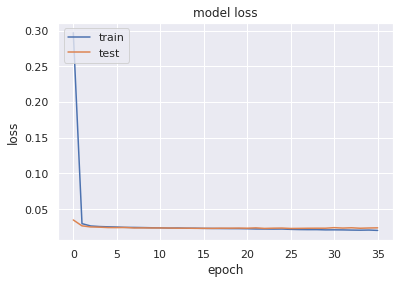

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.2966 - binary_crossentropy: 0.2945 - val_loss: 0.0338 - val_binary_crossentropy: 0.0290
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0296 - binary_crossentropy: 0.0246 - val_loss: 0.0269 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0267 - binary_crossentropy: 0.0210 - val_loss: 0.0261 - val_binary_crossentropy: 0.0204
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0260 - binary_crossentropy: 0.0199 - val_loss: 0.0249 - val_binary_crossentropy: 0.0188
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0252 - binary_crossentropy: 0.0190 - val_loss: 0.0246 - val_binary_crossentropy: 0.0184
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0248 - binary_crossentropy: 0.0185 - val_loss: 0.0241 - val_binary_crossentropy: 0.0180
E

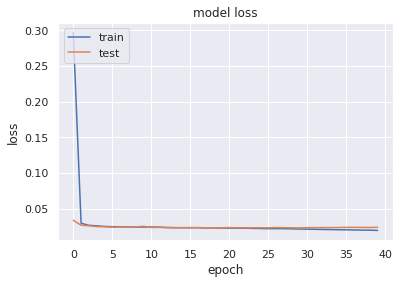

Our out of folds mean log loss score is 0.016770371780466562
CPU times: user 50min 58s, sys: 4min 24s, total: 55min 23s
Wall time: 46min 24s


In [29]:
%%time
for SEED in SEEDS4:
    test_pred, oof_pred = train_and_evaluate(train, test, train_targets, features, start_predictors, SEED=SEED, MODEL = '4l')

start fold 0
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4501 - binary_crossentropy: 0.4495 - val_loss: 0.1340 - val_binary_crossentropy: 0.1323
Epoch 2/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0605 - binary_crossentropy: 0.0580 - val_loss: 0.0365 - val_binary_crossentropy: 0.0336
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0315 - binary_crossentropy: 0.0282 - val_loss: 0.0292 - val_binary_crossentropy: 0.0258
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0246 - val_binary_crossentropy: 0.0208
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0234 - val_binary_crossentropy: 0.0194
Epoch 6/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0230 - val_binary_crossentropy: 0.0189

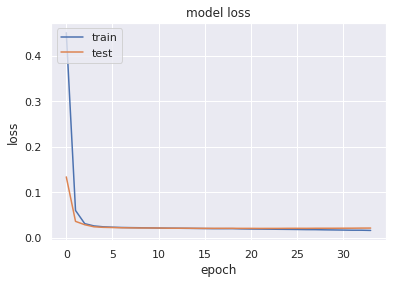

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4537 - binary_crossentropy: 0.4531 - val_loss: 0.1232 - val_binary_crossentropy: 0.1216
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0609 - binary_crossentropy: 0.0585 - val_loss: 0.0354 - val_binary_crossentropy: 0.0324
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0316 - binary_crossentropy: 0.0283 - val_loss: 0.0272 - val_binary_crossentropy: 0.0237
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0264 - binary_crossentropy: 0.0228 - val_loss: 0.0248 - val_binary_crossentropy: 0.0210
Epoch 5/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0247 - binary_crossentropy: 0.0208 - val_loss: 0.0234 - val_binary_crossentropy: 0.0194
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0228 - val_binary_crossentropy: 0.0186
E

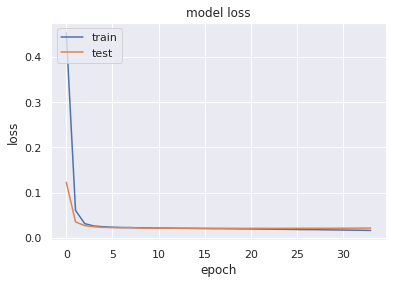

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4514 - binary_crossentropy: 0.4508 - val_loss: 0.1252 - val_binary_crossentropy: 0.1237
Epoch 2/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0601 - binary_crossentropy: 0.0577 - val_loss: 0.0368 - val_binary_crossentropy: 0.0339
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0315 - binary_crossentropy: 0.0283 - val_loss: 0.0272 - val_binary_crossentropy: 0.0237
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0243 - val_binary_crossentropy: 0.0204
Epoch 5/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0248 - binary_crossentropy: 0.0208 - val_loss: 0.0234 - val_binary_crossentropy: 0.0193
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0237 - binary_crossentropy: 0.0195 - val_loss: 0.0228 - val_binary_crossentropy: 0.0186


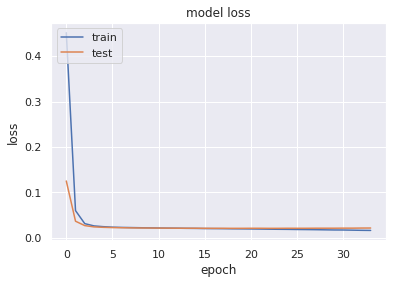

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.4527 - binary_crossentropy: 0.4521 - val_loss: 0.1227 - val_binary_crossentropy: 0.1211
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0602 - binary_crossentropy: 0.0578 - val_loss: 0.0370 - val_binary_crossentropy: 0.0341
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0313 - binary_crossentropy: 0.0281 - val_loss: 0.0271 - val_binary_crossentropy: 0.0236
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0264 - binary_crossentropy: 0.0227 - val_loss: 0.0248 - val_binary_crossentropy: 0.0210
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0248 - binary_crossentropy: 0.0208 - val_loss: 0.0236 - val_binary_crossentropy: 0.0195
Epoch 6/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0236 - binary_crossentropy: 0.0195 - val_loss: 0.0232 - val_binary_crossentropy: 0.019

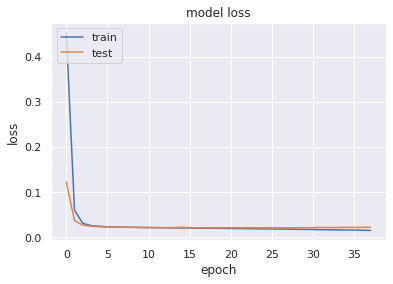

start fold 4
Epoch 1/80
160/160 [==============================] - 3s 17ms/step - loss: 0.4527 - binary_crossentropy: 0.4521 - val_loss: 0.1207 - val_binary_crossentropy: 0.1191
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0606 - binary_crossentropy: 0.0582 - val_loss: 0.0359 - val_binary_crossentropy: 0.0329
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0317 - binary_crossentropy: 0.0285 - val_loss: 0.0275 - val_binary_crossentropy: 0.0240
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0264 - binary_crossentropy: 0.0227 - val_loss: 0.0246 - val_binary_crossentropy: 0.0208
Epoch 5/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0247 - binary_crossentropy: 0.0207 - val_loss: 0.0238 - val_binary_crossentropy: 0.0198
Epoch 6/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0238 - binary_crossentropy: 0.0197 - val_loss: 0.0231 - val_binary_crossentropy: 0.0189


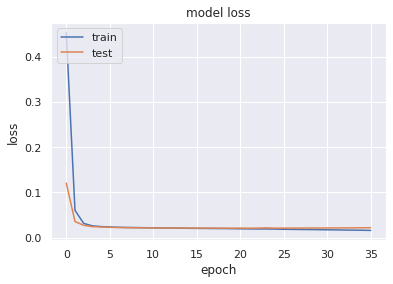

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.4504 - binary_crossentropy: 0.4498 - val_loss: 0.1253 - val_binary_crossentropy: 0.1236
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0604 - binary_crossentropy: 0.0580 - val_loss: 0.0349 - val_binary_crossentropy: 0.0319
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0316 - binary_crossentropy: 0.0284 - val_loss: 0.0272 - val_binary_crossentropy: 0.0237
Epoch 4/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0267 - binary_crossentropy: 0.0231 - val_loss: 0.0246 - val_binary_crossentropy: 0.0207
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0247 - binary_crossentropy: 0.0208 - val_loss: 0.0236 - val_binary_crossentropy: 0.0196
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0231 - val_binary_crossentropy: 0.0189
E

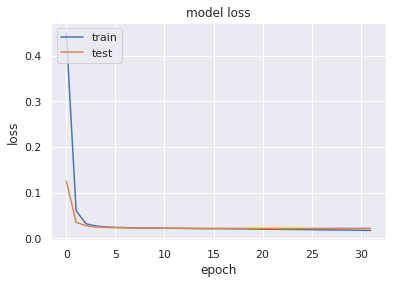

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4526 - binary_crossentropy: 0.4520 - val_loss: 0.1213 - val_binary_crossentropy: 0.1196
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0604 - binary_crossentropy: 0.0580 - val_loss: 0.0340 - val_binary_crossentropy: 0.0310
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0316 - binary_crossentropy: 0.0283 - val_loss: 0.0271 - val_binary_crossentropy: 0.0235
Epoch 4/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0246 - val_binary_crossentropy: 0.0208
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0247 - binary_crossentropy: 0.0207 - val_loss: 0.0235 - val_binary_crossentropy: 0.0194
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0238 - binary_crossentropy: 0.0197 - val_loss: 0.0228 - val_binary_crossentropy: 0.018

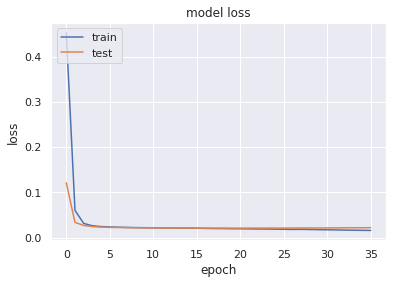

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.4517 - binary_crossentropy: 0.4511 - val_loss: 0.1378 - val_binary_crossentropy: 0.1363
Epoch 2/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0603 - binary_crossentropy: 0.0579 - val_loss: 0.0359 - val_binary_crossentropy: 0.0330
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0315 - binary_crossentropy: 0.0282 - val_loss: 0.0276 - val_binary_crossentropy: 0.0241
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0249 - val_binary_crossentropy: 0.0211
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0246 - binary_crossentropy: 0.0206 - val_loss: 0.0238 - val_binary_crossentropy: 0.0198
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0228 - val_binary_crossentropy: 0.01

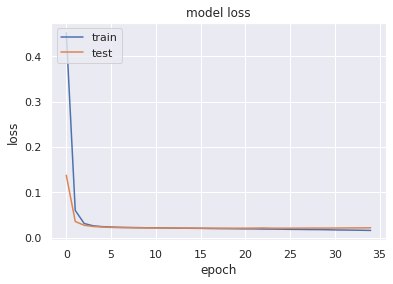

start fold 8
Epoch 1/80
160/160 [==============================] - 3s 20ms/step - loss: 0.4508 - binary_crossentropy: 0.4502 - val_loss: 0.1248 - val_binary_crossentropy: 0.1232
Epoch 2/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0603 - binary_crossentropy: 0.0578 - val_loss: 0.0360 - val_binary_crossentropy: 0.0331
Epoch 3/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0316 - binary_crossentropy: 0.0284 - val_loss: 0.0266 - val_binary_crossentropy: 0.0230
Epoch 4/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0246 - val_binary_crossentropy: 0.0207
Epoch 5/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0246 - binary_crossentropy: 0.0206 - val_loss: 0.0237 - val_binary_crossentropy: 0.0197
Epoch 6/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0232 - val_binary_crossentropy: 0.01

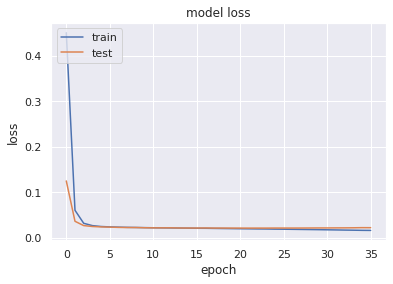

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4509 - binary_crossentropy: 0.4503 - val_loss: 0.1306 - val_binary_crossentropy: 0.1291
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0606 - binary_crossentropy: 0.0582 - val_loss: 0.0356 - val_binary_crossentropy: 0.0327
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0316 - binary_crossentropy: 0.0283 - val_loss: 0.0273 - val_binary_crossentropy: 0.0237
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0264 - binary_crossentropy: 0.0227 - val_loss: 0.0250 - val_binary_crossentropy: 0.0212
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0245 - binary_crossentropy: 0.0206 - val_loss: 0.0238 - val_binary_crossentropy: 0.0198
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0237 - binary_crossentropy: 0.0195 - val_loss: 0.0234 - val_binary_crossentropy: 0.0193

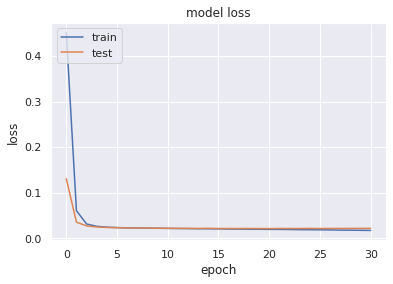

Our out of folds mean log loss score is 0.01676807102182332
start fold 0
Epoch 1/80
160/160 [==============================] - 3s 17ms/step - loss: 0.4525 - binary_crossentropy: 0.4519 - val_loss: 0.1186 - val_binary_crossentropy: 0.1170
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0608 - binary_crossentropy: 0.0584 - val_loss: 0.0366 - val_binary_crossentropy: 0.0337
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0315 - binary_crossentropy: 0.0282 - val_loss: 0.0284 - val_binary_crossentropy: 0.0250
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0248 - val_binary_crossentropy: 0.0210
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0238 - val_binary_crossentropy: 0.0198
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0238 - binary_crossentrop

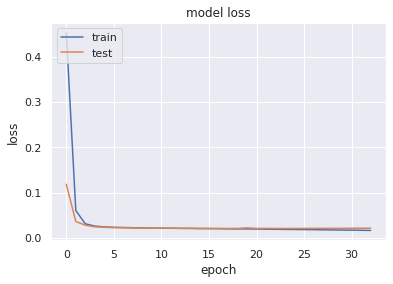

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4535 - binary_crossentropy: 0.4529 - val_loss: 0.1294 - val_binary_crossentropy: 0.1278
Epoch 2/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0608 - binary_crossentropy: 0.0583 - val_loss: 0.0398 - val_binary_crossentropy: 0.0369
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0313 - binary_crossentropy: 0.0280 - val_loss: 0.0274 - val_binary_crossentropy: 0.0239
Epoch 4/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0265 - binary_crossentropy: 0.0229 - val_loss: 0.0253 - val_binary_crossentropy: 0.0215
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0249 - binary_crossentropy: 0.0209 - val_loss: 0.0235 - val_binary_crossentropy: 0.0194
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0195 - val_loss: 0.0230 - val_binary_crossentropy: 0.0187


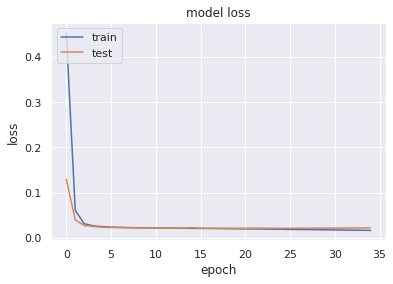

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4501 - binary_crossentropy: 0.4495 - val_loss: 0.1353 - val_binary_crossentropy: 0.1337
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0608 - binary_crossentropy: 0.0584 - val_loss: 0.0360 - val_binary_crossentropy: 0.0330
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0315 - binary_crossentropy: 0.0283 - val_loss: 0.0271 - val_binary_crossentropy: 0.0235
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0266 - binary_crossentropy: 0.0229 - val_loss: 0.0247 - val_binary_crossentropy: 0.0209
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0246 - binary_crossentropy: 0.0206 - val_loss: 0.0236 - val_binary_crossentropy: 0.0195
Epoch 6/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0231 - val_binary_crossentropy: 0.0190


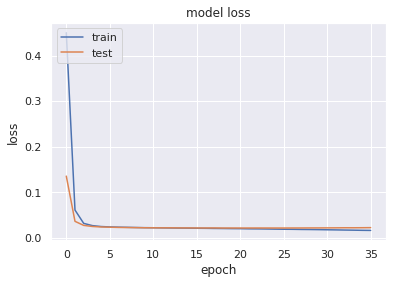

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4507 - binary_crossentropy: 0.4501 - val_loss: 0.1197 - val_binary_crossentropy: 0.1180
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0603 - binary_crossentropy: 0.0579 - val_loss: 0.0350 - val_binary_crossentropy: 0.0320
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0314 - binary_crossentropy: 0.0282 - val_loss: 0.0269 - val_binary_crossentropy: 0.0234
Epoch 4/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0246 - val_binary_crossentropy: 0.0209
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0248 - binary_crossentropy: 0.0208 - val_loss: 0.0232 - val_binary_crossentropy: 0.0191
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0238 - binary_crossentropy: 0.0196 - val_loss: 0.0227 - val_binary_crossentropy: 0.0185

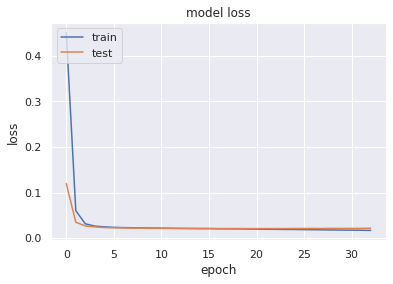

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4527 - binary_crossentropy: 0.4521 - val_loss: 0.1230 - val_binary_crossentropy: 0.1214
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0605 - binary_crossentropy: 0.0580 - val_loss: 0.0365 - val_binary_crossentropy: 0.0336
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0314 - binary_crossentropy: 0.0282 - val_loss: 0.0275 - val_binary_crossentropy: 0.0240
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0264 - binary_crossentropy: 0.0227 - val_loss: 0.0254 - val_binary_crossentropy: 0.0217
Epoch 5/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0238 - val_binary_crossentropy: 0.0199
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0238 - binary_crossentropy: 0.0197 - val_loss: 0.0229 - val_binary_crossentropy: 0.0187


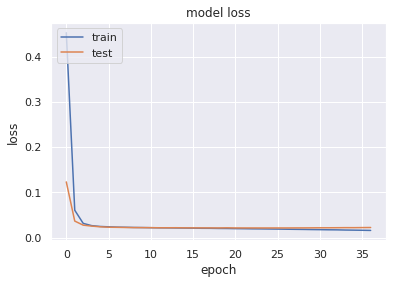

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.4523 - binary_crossentropy: 0.4517 - val_loss: 0.1065 - val_binary_crossentropy: 0.1048
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0603 - binary_crossentropy: 0.0578 - val_loss: 0.0353 - val_binary_crossentropy: 0.0324
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0314 - binary_crossentropy: 0.0282 - val_loss: 0.0275 - val_binary_crossentropy: 0.0241
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0266 - binary_crossentropy: 0.0229 - val_loss: 0.0253 - val_binary_crossentropy: 0.0215
Epoch 5/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0237 - val_binary_crossentropy: 0.0197
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0231 - val_binary_crossentropy: 0.01

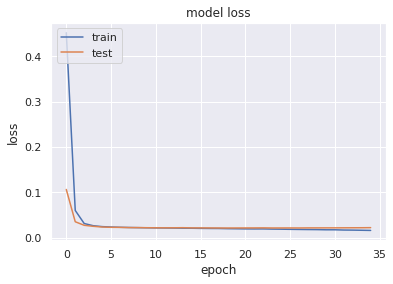

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4535 - binary_crossentropy: 0.4529 - val_loss: 0.1119 - val_binary_crossentropy: 0.1102
Epoch 2/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0602 - binary_crossentropy: 0.0578 - val_loss: 0.0359 - val_binary_crossentropy: 0.0329
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0315 - binary_crossentropy: 0.0282 - val_loss: 0.0277 - val_binary_crossentropy: 0.0243
Epoch 4/80
160/160 [==============================] - 3s 18ms/step - loss: 0.0264 - binary_crossentropy: 0.0227 - val_loss: 0.0247 - val_binary_crossentropy: 0.0209
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0247 - binary_crossentropy: 0.0207 - val_loss: 0.0234 - val_binary_crossentropy: 0.0193
Epoch 6/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0239 - binary_crossentropy: 0.0198 - val_loss: 0.0229 - val_binary_crossentropy: 0.01

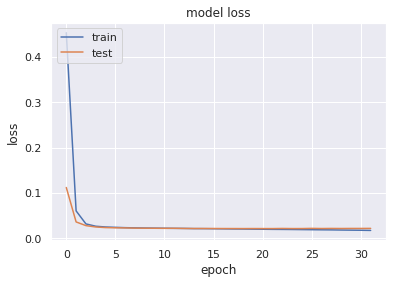

start fold 7
Epoch 1/80
160/160 [==============================] - 3s 17ms/step - loss: 0.4534 - binary_crossentropy: 0.4528 - val_loss: 0.1431 - val_binary_crossentropy: 0.1416
Epoch 2/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0613 - binary_crossentropy: 0.0589 - val_loss: 0.0373 - val_binary_crossentropy: 0.0344
Epoch 3/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0317 - binary_crossentropy: 0.0285 - val_loss: 0.0268 - val_binary_crossentropy: 0.0233
Epoch 4/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0266 - binary_crossentropy: 0.0229 - val_loss: 0.0250 - val_binary_crossentropy: 0.0212
Epoch 5/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0247 - binary_crossentropy: 0.0207 - val_loss: 0.0235 - val_binary_crossentropy: 0.0194
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0230 - val_binary_crossentropy: 0.01

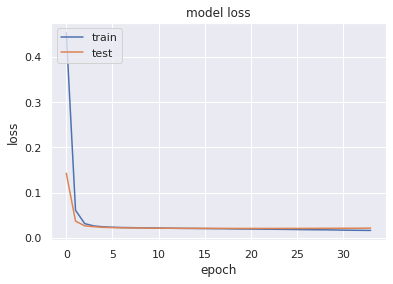

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4520 - binary_crossentropy: 0.4514 - val_loss: 0.1148 - val_binary_crossentropy: 0.1131
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0607 - binary_crossentropy: 0.0582 - val_loss: 0.0359 - val_binary_crossentropy: 0.0330
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0317 - binary_crossentropy: 0.0285 - val_loss: 0.0275 - val_binary_crossentropy: 0.0241
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0249 - val_binary_crossentropy: 0.0211
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0238 - val_binary_crossentropy: 0.0198
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0232 - val_binary_crossentropy: 0.01

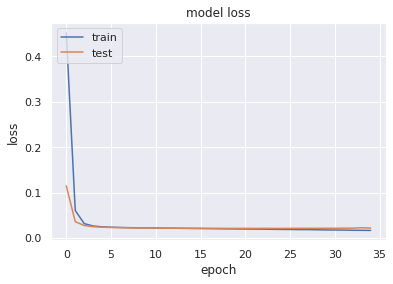

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4516 - binary_crossentropy: 0.4510 - val_loss: 0.1218 - val_binary_crossentropy: 0.1201
Epoch 2/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0598 - binary_crossentropy: 0.0573 - val_loss: 0.0356 - val_binary_crossentropy: 0.0327
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0314 - binary_crossentropy: 0.0282 - val_loss: 0.0277 - val_binary_crossentropy: 0.0242
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0263 - binary_crossentropy: 0.0226 - val_loss: 0.0248 - val_binary_crossentropy: 0.0210
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0246 - binary_crossentropy: 0.0206 - val_loss: 0.0239 - val_binary_crossentropy: 0.0199
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0237 - binary_crossentropy: 0.0195 - val_loss: 0.0229 - val_binary_crossentropy: 0.0187

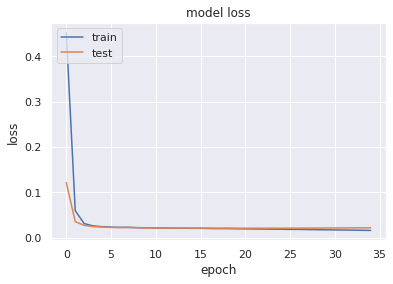

Our out of folds mean log loss score is 0.016747119827261396
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4499 - binary_crossentropy: 0.4493 - val_loss: 0.1179 - val_binary_crossentropy: 0.1162
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0607 - binary_crossentropy: 0.0583 - val_loss: 0.0346 - val_binary_crossentropy: 0.0316
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0313 - binary_crossentropy: 0.0280 - val_loss: 0.0275 - val_binary_crossentropy: 0.0240
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0246 - val_binary_crossentropy: 0.0208
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0234 - val_binary_crossentropy: 0.0194
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentro

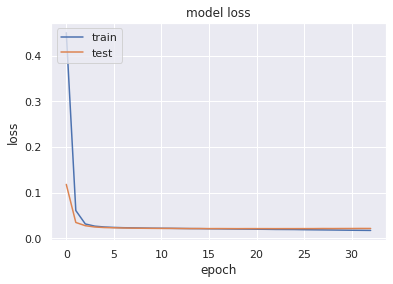

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4515 - binary_crossentropy: 0.4509 - val_loss: 0.1277 - val_binary_crossentropy: 0.1262
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0607 - binary_crossentropy: 0.0583 - val_loss: 0.0360 - val_binary_crossentropy: 0.0330
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0315 - binary_crossentropy: 0.0283 - val_loss: 0.0279 - val_binary_crossentropy: 0.0244
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0266 - binary_crossentropy: 0.0229 - val_loss: 0.0246 - val_binary_crossentropy: 0.0208
Epoch 5/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0237 - val_binary_crossentropy: 0.0197
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0230 - val_binary_crossentropy: 0.0188

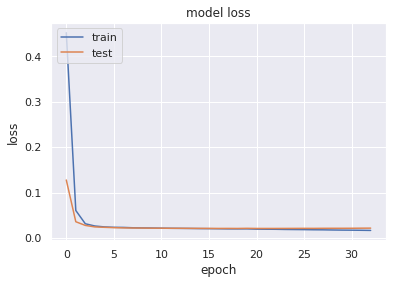

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4521 - binary_crossentropy: 0.4515 - val_loss: 0.1384 - val_binary_crossentropy: 0.1368
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0605 - binary_crossentropy: 0.0581 - val_loss: 0.0362 - val_binary_crossentropy: 0.0333
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0313 - binary_crossentropy: 0.0281 - val_loss: 0.0275 - val_binary_crossentropy: 0.0240
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0264 - binary_crossentropy: 0.0227 - val_loss: 0.0248 - val_binary_crossentropy: 0.0210
Epoch 5/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0246 - binary_crossentropy: 0.0206 - val_loss: 0.0237 - val_binary_crossentropy: 0.0197
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0236 - binary_crossentropy: 0.0195 - val_loss: 0.0230 - val_binary_crossentropy: 0.0189

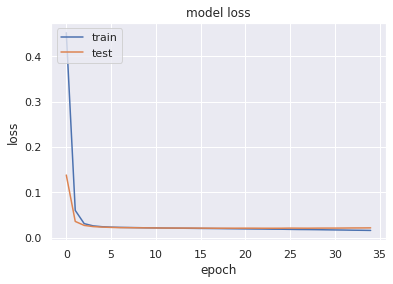

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4528 - binary_crossentropy: 0.4522 - val_loss: 0.1222 - val_binary_crossentropy: 0.1206
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0606 - binary_crossentropy: 0.0582 - val_loss: 0.0357 - val_binary_crossentropy: 0.0328
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0315 - binary_crossentropy: 0.0283 - val_loss: 0.0274 - val_binary_crossentropy: 0.0240
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0264 - binary_crossentropy: 0.0228 - val_loss: 0.0250 - val_binary_crossentropy: 0.0212
Epoch 5/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0248 - binary_crossentropy: 0.0208 - val_loss: 0.0237 - val_binary_crossentropy: 0.0196
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0238 - binary_crossentropy: 0.0196 - val_loss: 0.0230 - val_binary_crossentropy: 0.0188


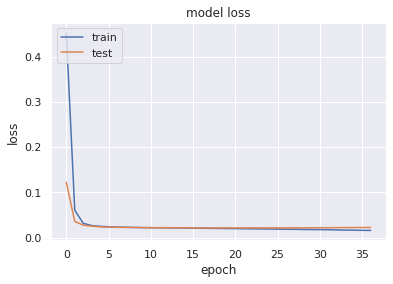

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4508 - binary_crossentropy: 0.4502 - val_loss: 0.1234 - val_binary_crossentropy: 0.1218
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0603 - binary_crossentropy: 0.0579 - val_loss: 0.0363 - val_binary_crossentropy: 0.0333
Epoch 3/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0313 - binary_crossentropy: 0.0281 - val_loss: 0.0270 - val_binary_crossentropy: 0.0235
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0263 - binary_crossentropy: 0.0227 - val_loss: 0.0245 - val_binary_crossentropy: 0.0207
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0245 - binary_crossentropy: 0.0205 - val_loss: 0.0235 - val_binary_crossentropy: 0.0195
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0236 - binary_crossentropy: 0.0195 - val_loss: 0.0229 - val_binary_crossentropy: 0.01

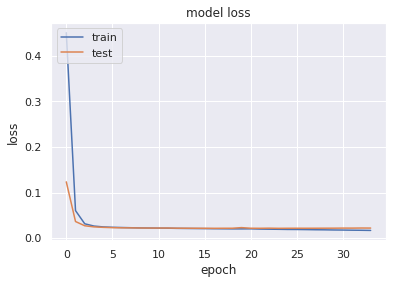

start fold 5
Epoch 1/80
160/160 [==============================] - 4s 22ms/step - loss: 0.4528 - binary_crossentropy: 0.4522 - val_loss: 0.1193 - val_binary_crossentropy: 0.1176
Epoch 2/80
160/160 [==============================] - 3s 16ms/step - loss: 0.0603 - binary_crossentropy: 0.0579 - val_loss: 0.0377 - val_binary_crossentropy: 0.0348
Epoch 3/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0314 - binary_crossentropy: 0.0281 - val_loss: 0.0285 - val_binary_crossentropy: 0.0251
Epoch 4/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0244 - val_binary_crossentropy: 0.0205
Epoch 5/80
160/160 [==============================] - 3s 17ms/step - loss: 0.0246 - binary_crossentropy: 0.0206 - val_loss: 0.0233 - val_binary_crossentropy: 0.0192
Epoch 6/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0238 - binary_crossentropy: 0.0197 - val_loss: 0.0235 - val_binary_crossentropy: 0.01

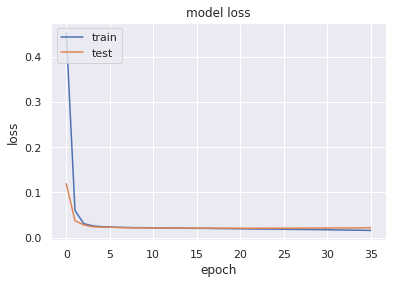

start fold 6
Epoch 1/80
160/160 [==============================] - 3s 18ms/step - loss: 0.4514 - binary_crossentropy: 0.4508 - val_loss: 0.1238 - val_binary_crossentropy: 0.1222
Epoch 2/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0604 - binary_crossentropy: 0.0580 - val_loss: 0.0375 - val_binary_crossentropy: 0.0346
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0314 - binary_crossentropy: 0.0282 - val_loss: 0.0275 - val_binary_crossentropy: 0.0240
Epoch 4/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0248 - val_binary_crossentropy: 0.0210
Epoch 5/80
160/160 [==============================] - 3s 16ms/step - loss: 0.0246 - binary_crossentropy: 0.0206 - val_loss: 0.0237 - val_binary_crossentropy: 0.0197
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0237 - binary_crossentropy: 0.0195 - val_loss: 0.0229 - val_binary_crossentropy: 0.01

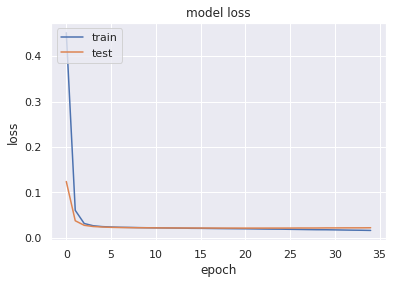

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4530 - binary_crossentropy: 0.4524 - val_loss: 0.1278 - val_binary_crossentropy: 0.1261
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0602 - binary_crossentropy: 0.0578 - val_loss: 0.0349 - val_binary_crossentropy: 0.0319
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0315 - binary_crossentropy: 0.0282 - val_loss: 0.0274 - val_binary_crossentropy: 0.0239
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0266 - binary_crossentropy: 0.0229 - val_loss: 0.0251 - val_binary_crossentropy: 0.0213
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0239 - val_binary_crossentropy: 0.0199
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0238 - binary_crossentropy: 0.0197 - val_loss: 0.0231 - val_binary_crossentropy: 0.01

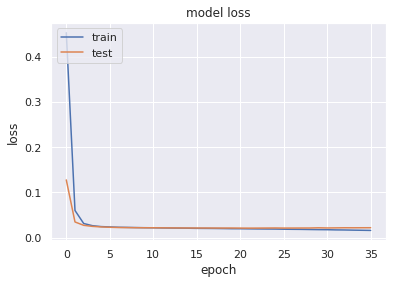

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4532 - binary_crossentropy: 0.4526 - val_loss: 0.1155 - val_binary_crossentropy: 0.1138
Epoch 2/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0606 - binary_crossentropy: 0.0581 - val_loss: 0.0356 - val_binary_crossentropy: 0.0326
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0316 - binary_crossentropy: 0.0283 - val_loss: 0.0273 - val_binary_crossentropy: 0.0238
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0266 - binary_crossentropy: 0.0229 - val_loss: 0.0248 - val_binary_crossentropy: 0.0209
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0247 - binary_crossentropy: 0.0207 - val_loss: 0.0235 - val_binary_crossentropy: 0.0194
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0230 - val_binary_crossentropy: 0.018

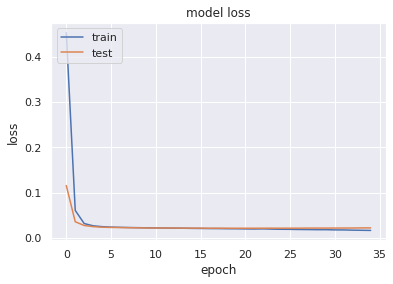

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4543 - binary_crossentropy: 0.4537 - val_loss: 0.1256 - val_binary_crossentropy: 0.1240
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0604 - binary_crossentropy: 0.0580 - val_loss: 0.0366 - val_binary_crossentropy: 0.0336
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0314 - binary_crossentropy: 0.0282 - val_loss: 0.0274 - val_binary_crossentropy: 0.0239
Epoch 4/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0264 - binary_crossentropy: 0.0227 - val_loss: 0.0245 - val_binary_crossentropy: 0.0207
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0237 - val_binary_crossentropy: 0.0197
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0237 - binary_crossentropy: 0.0195 - val_loss: 0.0229 - val_binary_crossentropy: 0.018

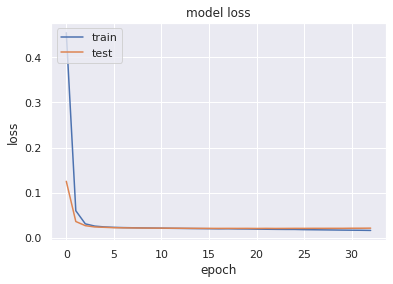

Our out of folds mean log loss score is 0.016767056416124484
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.4523 - binary_crossentropy: 0.4517 - val_loss: 0.1206 - val_binary_crossentropy: 0.1189
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0603 - binary_crossentropy: 0.0579 - val_loss: 0.0357 - val_binary_crossentropy: 0.0328
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0315 - binary_crossentropy: 0.0283 - val_loss: 0.0273 - val_binary_crossentropy: 0.0238
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0247 - val_binary_crossentropy: 0.0209
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0247 - binary_crossentropy: 0.0207 - val_loss: 0.0238 - val_binary_crossentropy: 0.0198
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0238 - binary_crossentro

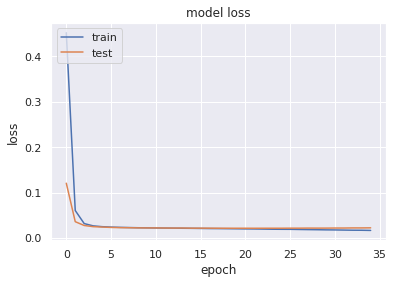

start fold 1
Epoch 1/80
160/160 [==============================] - 3s 17ms/step - loss: 0.4509 - binary_crossentropy: 0.4503 - val_loss: 0.1219 - val_binary_crossentropy: 0.1203
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0612 - binary_crossentropy: 0.0588 - val_loss: 0.0360 - val_binary_crossentropy: 0.0331
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0318 - binary_crossentropy: 0.0285 - val_loss: 0.0270 - val_binary_crossentropy: 0.0234
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0249 - val_binary_crossentropy: 0.0211
Epoch 5/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0248 - binary_crossentropy: 0.0208 - val_loss: 0.0237 - val_binary_crossentropy: 0.0197
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0231 - val_binary_crossentropy: 0.018

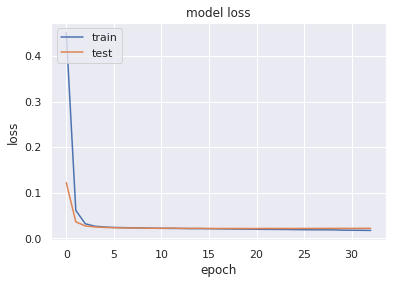

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.4532 - binary_crossentropy: 0.4526 - val_loss: 0.1140 - val_binary_crossentropy: 0.1123
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0606 - binary_crossentropy: 0.0582 - val_loss: 0.0352 - val_binary_crossentropy: 0.0322
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0314 - binary_crossentropy: 0.0282 - val_loss: 0.0269 - val_binary_crossentropy: 0.0233
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0245 - val_binary_crossentropy: 0.0207
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0247 - binary_crossentropy: 0.0208 - val_loss: 0.0243 - val_binary_crossentropy: 0.0205
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0227 - val_binary_crossentropy: 0.01

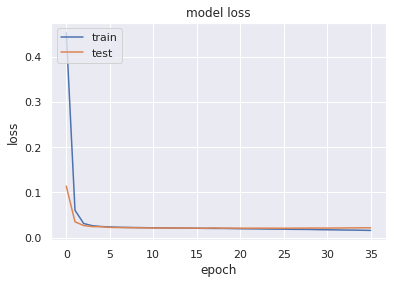

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4498 - binary_crossentropy: 0.4492 - val_loss: 0.1190 - val_binary_crossentropy: 0.1173
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0604 - binary_crossentropy: 0.0580 - val_loss: 0.0353 - val_binary_crossentropy: 0.0324
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0316 - binary_crossentropy: 0.0283 - val_loss: 0.0270 - val_binary_crossentropy: 0.0235
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0264 - binary_crossentropy: 0.0227 - val_loss: 0.0246 - val_binary_crossentropy: 0.0208
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0249 - binary_crossentropy: 0.0209 - val_loss: 0.0234 - val_binary_crossentropy: 0.0193
Epoch 6/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0237 - binary_crossentropy: 0.0195 - val_loss: 0.0228 - val_binary_crossentropy: 0.018

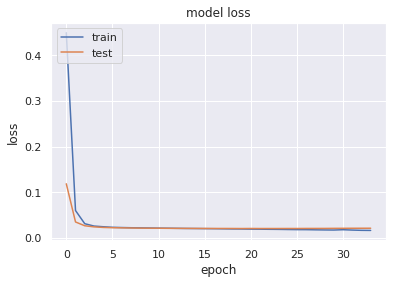

start fold 4
Epoch 1/80
160/160 [==============================] - 3s 19ms/step - loss: 0.4496 - binary_crossentropy: 0.4490 - val_loss: 0.1321 - val_binary_crossentropy: 0.1305
Epoch 2/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0606 - binary_crossentropy: 0.0582 - val_loss: 0.0356 - val_binary_crossentropy: 0.0326
Epoch 3/80
160/160 [==============================] - 3s 18ms/step - loss: 0.0316 - binary_crossentropy: 0.0283 - val_loss: 0.0279 - val_binary_crossentropy: 0.0245
Epoch 4/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0266 - binary_crossentropy: 0.0229 - val_loss: 0.0252 - val_binary_crossentropy: 0.0214
Epoch 5/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0238 - val_binary_crossentropy: 0.0197
Epoch 6/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0232 - val_binary_crossentropy: 0.01

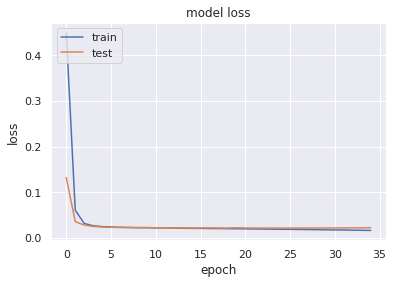

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.4511 - binary_crossentropy: 0.4505 - val_loss: 0.1259 - val_binary_crossentropy: 0.1243
Epoch 2/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0603 - binary_crossentropy: 0.0579 - val_loss: 0.0377 - val_binary_crossentropy: 0.0349
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0313 - binary_crossentropy: 0.0280 - val_loss: 0.0272 - val_binary_crossentropy: 0.0237
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0264 - binary_crossentropy: 0.0228 - val_loss: 0.0246 - val_binary_crossentropy: 0.0208
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0247 - binary_crossentropy: 0.0207 - val_loss: 0.0234 - val_binary_crossentropy: 0.0194
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0232 - val_binary_crossentropy: 0.01

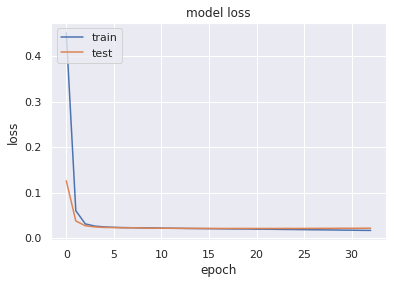

start fold 6
Epoch 1/80
160/160 [==============================] - 3s 16ms/step - loss: 0.4531 - binary_crossentropy: 0.4525 - val_loss: 0.1222 - val_binary_crossentropy: 0.1206
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0607 - binary_crossentropy: 0.0583 - val_loss: 0.0370 - val_binary_crossentropy: 0.0341
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0315 - binary_crossentropy: 0.0282 - val_loss: 0.0269 - val_binary_crossentropy: 0.0233
Epoch 4/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0268 - binary_crossentropy: 0.0231 - val_loss: 0.0252 - val_binary_crossentropy: 0.0214
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0247 - binary_crossentropy: 0.0207 - val_loss: 0.0235 - val_binary_crossentropy: 0.0194
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0228 - val_binary_crossentropy: 0.01

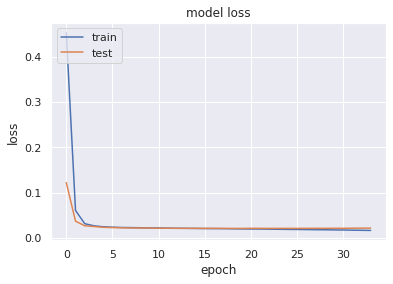

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.4524 - binary_crossentropy: 0.4518 - val_loss: 0.1196 - val_binary_crossentropy: 0.1179
Epoch 2/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0608 - binary_crossentropy: 0.0584 - val_loss: 0.0365 - val_binary_crossentropy: 0.0336
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0314 - binary_crossentropy: 0.0281 - val_loss: 0.0274 - val_binary_crossentropy: 0.0239
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0264 - binary_crossentropy: 0.0228 - val_loss: 0.0247 - val_binary_crossentropy: 0.0210
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0234 - val_binary_crossentropy: 0.0194
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0228 - val_binary_crossentropy: 0.0186

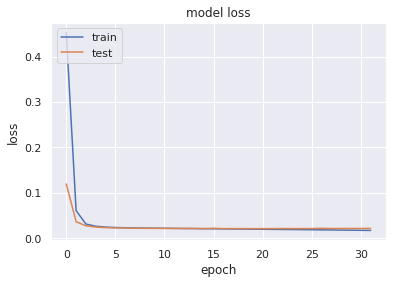

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4511 - binary_crossentropy: 0.4505 - val_loss: 0.1239 - val_binary_crossentropy: 0.1222
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0604 - binary_crossentropy: 0.0579 - val_loss: 0.0358 - val_binary_crossentropy: 0.0328
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0313 - binary_crossentropy: 0.0280 - val_loss: 0.0274 - val_binary_crossentropy: 0.0239
Epoch 4/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0248 - val_binary_crossentropy: 0.0210
Epoch 5/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0235 - val_binary_crossentropy: 0.0194
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0236 - binary_crossentropy: 0.0195 - val_loss: 0.0231 - val_binary_crossentropy: 0.0189

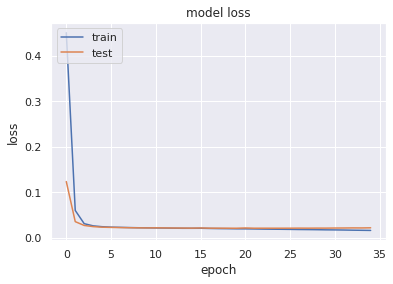

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.4502 - binary_crossentropy: 0.4496 - val_loss: 0.1196 - val_binary_crossentropy: 0.1180
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0601 - binary_crossentropy: 0.0577 - val_loss: 0.0371 - val_binary_crossentropy: 0.0341
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0314 - binary_crossentropy: 0.0281 - val_loss: 0.0272 - val_binary_crossentropy: 0.0236
Epoch 4/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0255 - val_binary_crossentropy: 0.0218
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0239 - val_binary_crossentropy: 0.0199
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0231 - val_binary_crossentropy: 0.018

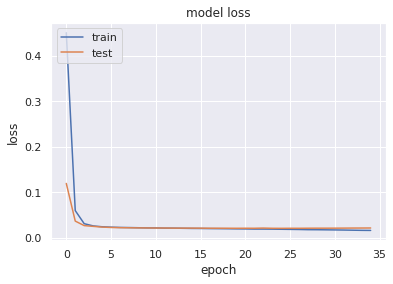

Our out of folds mean log loss score is 0.016658292219233706
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.4526 - binary_crossentropy: 0.4520 - val_loss: 0.1285 - val_binary_crossentropy: 0.1269
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0609 - binary_crossentropy: 0.0585 - val_loss: 0.0355 - val_binary_crossentropy: 0.0325
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0318 - binary_crossentropy: 0.0285 - val_loss: 0.0276 - val_binary_crossentropy: 0.0241
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0251 - val_binary_crossentropy: 0.0213
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0246 - binary_crossentropy: 0.0206 - val_loss: 0.0236 - val_binary_crossentropy: 0.0196
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0238 - binary_crossentro

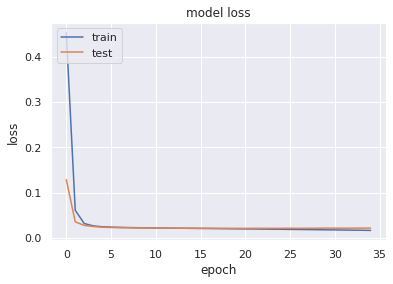

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.4531 - binary_crossentropy: 0.4525 - val_loss: 0.1470 - val_binary_crossentropy: 0.1455
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0609 - binary_crossentropy: 0.0585 - val_loss: 0.0361 - val_binary_crossentropy: 0.0332
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0315 - binary_crossentropy: 0.0283 - val_loss: 0.0272 - val_binary_crossentropy: 0.0238
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0264 - binary_crossentropy: 0.0228 - val_loss: 0.0247 - val_binary_crossentropy: 0.0209
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0246 - binary_crossentropy: 0.0206 - val_loss: 0.0236 - val_binary_crossentropy: 0.0196
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0229 - val_binary_crossentropy: 0.01

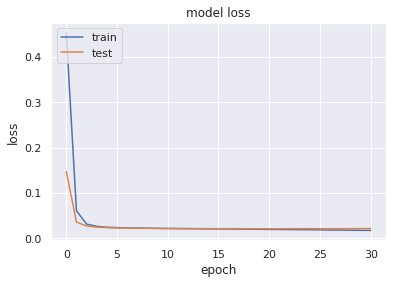

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4526 - binary_crossentropy: 0.4520 - val_loss: 0.1218 - val_binary_crossentropy: 0.1202
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0608 - binary_crossentropy: 0.0584 - val_loss: 0.0360 - val_binary_crossentropy: 0.0331
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0315 - binary_crossentropy: 0.0283 - val_loss: 0.0266 - val_binary_crossentropy: 0.0230
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0247 - val_binary_crossentropy: 0.0209
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0247 - binary_crossentropy: 0.0208 - val_loss: 0.0237 - val_binary_crossentropy: 0.0197
Epoch 6/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0238 - binary_crossentropy: 0.0196 - val_loss: 0.0229 - val_binary_crossentropy: 0.018

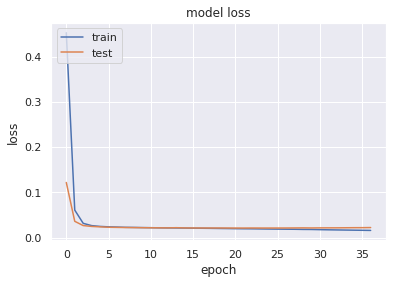

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.4522 - binary_crossentropy: 0.4516 - val_loss: 0.1312 - val_binary_crossentropy: 0.1296
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0603 - binary_crossentropy: 0.0578 - val_loss: 0.0352 - val_binary_crossentropy: 0.0323
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0314 - binary_crossentropy: 0.0282 - val_loss: 0.0271 - val_binary_crossentropy: 0.0236
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0268 - binary_crossentropy: 0.0231 - val_loss: 0.0245 - val_binary_crossentropy: 0.0206
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0246 - binary_crossentropy: 0.0206 - val_loss: 0.0236 - val_binary_crossentropy: 0.0196
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0232 - val_binary_crossentropy: 0.01

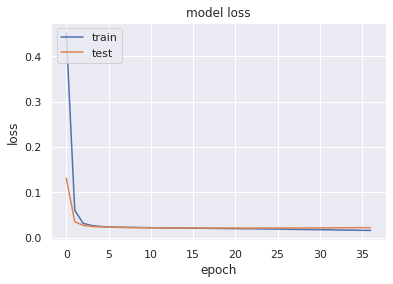

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4520 - binary_crossentropy: 0.4515 - val_loss: 0.1293 - val_binary_crossentropy: 0.1277
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0606 - binary_crossentropy: 0.0581 - val_loss: 0.0356 - val_binary_crossentropy: 0.0327
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0315 - binary_crossentropy: 0.0283 - val_loss: 0.0271 - val_binary_crossentropy: 0.0236
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0264 - binary_crossentropy: 0.0227 - val_loss: 0.0247 - val_binary_crossentropy: 0.0209
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0236 - val_binary_crossentropy: 0.0196
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0195 - val_loss: 0.0230 - val_binary_crossentropy: 0.01

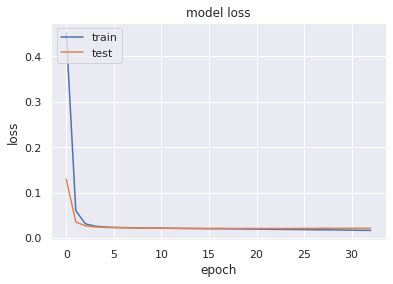

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.4515 - binary_crossentropy: 0.4509 - val_loss: 0.1265 - val_binary_crossentropy: 0.1250
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0609 - binary_crossentropy: 0.0585 - val_loss: 0.0355 - val_binary_crossentropy: 0.0326
Epoch 3/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0316 - binary_crossentropy: 0.0283 - val_loss: 0.0274 - val_binary_crossentropy: 0.0239
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0266 - binary_crossentropy: 0.0229 - val_loss: 0.0248 - val_binary_crossentropy: 0.0211
Epoch 5/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0250 - binary_crossentropy: 0.0210 - val_loss: 0.0235 - val_binary_crossentropy: 0.0195
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0238 - binary_crossentropy: 0.0196 - val_loss: 0.0230 - val_binary_crossentropy: 0.018

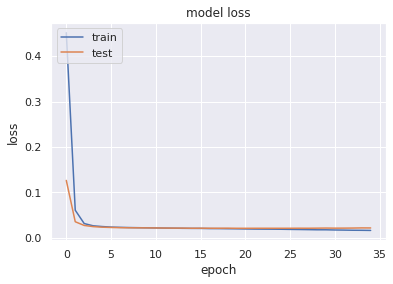

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4532 - binary_crossentropy: 0.4526 - val_loss: 0.1265 - val_binary_crossentropy: 0.1249
Epoch 2/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0605 - binary_crossentropy: 0.0581 - val_loss: 0.0352 - val_binary_crossentropy: 0.0322
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0314 - binary_crossentropy: 0.0282 - val_loss: 0.0275 - val_binary_crossentropy: 0.0240
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0264 - binary_crossentropy: 0.0227 - val_loss: 0.0247 - val_binary_crossentropy: 0.0209
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0236 - val_binary_crossentropy: 0.0196
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0236 - binary_crossentropy: 0.0195 - val_loss: 0.0229 - val_binary_crossentropy: 0.01

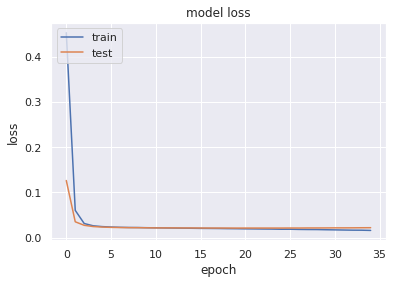

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.4535 - binary_crossentropy: 0.4529 - val_loss: 0.1229 - val_binary_crossentropy: 0.1212
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0613 - binary_crossentropy: 0.0589 - val_loss: 0.0349 - val_binary_crossentropy: 0.0319
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0315 - binary_crossentropy: 0.0283 - val_loss: 0.0277 - val_binary_crossentropy: 0.0242
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0252 - val_binary_crossentropy: 0.0214
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0247 - binary_crossentropy: 0.0207 - val_loss: 0.0238 - val_binary_crossentropy: 0.0198
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0231 - val_binary_crossentropy: 0.01

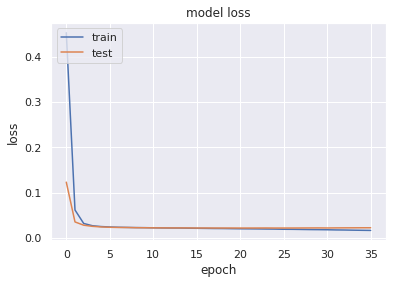

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4515 - binary_crossentropy: 0.4509 - val_loss: 0.1347 - val_binary_crossentropy: 0.1331
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0608 - binary_crossentropy: 0.0584 - val_loss: 0.0410 - val_binary_crossentropy: 0.0382
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0318 - binary_crossentropy: 0.0285 - val_loss: 0.0274 - val_binary_crossentropy: 0.0239
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0266 - binary_crossentropy: 0.0230 - val_loss: 0.0248 - val_binary_crossentropy: 0.0210
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0247 - binary_crossentropy: 0.0207 - val_loss: 0.0235 - val_binary_crossentropy: 0.0195
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0228 - val_binary_crossentropy: 0.01

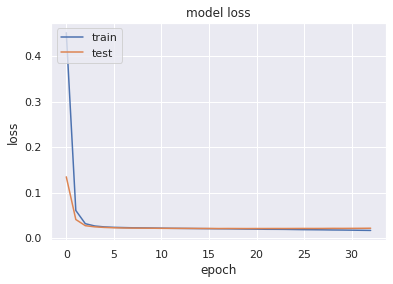

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.4533 - binary_crossentropy: 0.4527 - val_loss: 0.1249 - val_binary_crossentropy: 0.1233
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0608 - binary_crossentropy: 0.0584 - val_loss: 0.0346 - val_binary_crossentropy: 0.0316
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0315 - binary_crossentropy: 0.0282 - val_loss: 0.0279 - val_binary_crossentropy: 0.0244
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0264 - binary_crossentropy: 0.0227 - val_loss: 0.0248 - val_binary_crossentropy: 0.0210
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0237 - val_binary_crossentropy: 0.0196
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0232 - val_binary_crossentropy: 0.019

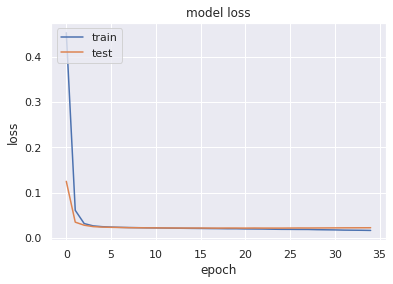

Our out of folds mean log loss score is 0.01667825282578825
start fold 0
Epoch 1/80
160/160 [==============================] - 4s 22ms/step - loss: 0.4505 - binary_crossentropy: 0.4499 - val_loss: 0.1093 - val_binary_crossentropy: 0.1075
Epoch 2/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0603 - binary_crossentropy: 0.0579 - val_loss: 0.0360 - val_binary_crossentropy: 0.0331
Epoch 3/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0313 - binary_crossentropy: 0.0280 - val_loss: 0.0274 - val_binary_crossentropy: 0.0239
Epoch 4/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0263 - binary_crossentropy: 0.0226 - val_loss: 0.0246 - val_binary_crossentropy: 0.0207
Epoch 5/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0245 - binary_crossentropy: 0.0206 - val_loss: 0.0236 - val_binary_crossentropy: 0.0195
Epoch 6/80
160/160 [==============================] - 3s 17ms/step - loss: 0.0238 - binary_crossentrop

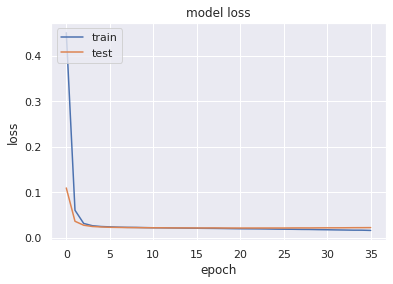

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.4524 - binary_crossentropy: 0.4518 - val_loss: 0.1328 - val_binary_crossentropy: 0.1313
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0608 - binary_crossentropy: 0.0584 - val_loss: 0.0357 - val_binary_crossentropy: 0.0327
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0317 - binary_crossentropy: 0.0285 - val_loss: 0.0279 - val_binary_crossentropy: 0.0244
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0265 - binary_crossentropy: 0.0229 - val_loss: 0.0250 - val_binary_crossentropy: 0.0213
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0246 - binary_crossentropy: 0.0206 - val_loss: 0.0238 - val_binary_crossentropy: 0.0198
Epoch 6/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0228 - val_binary_crossentropy: 0.018

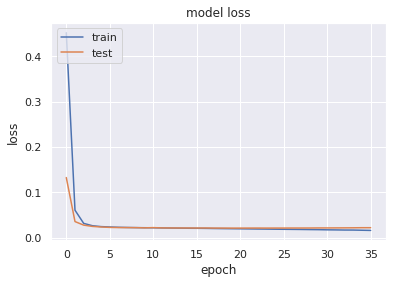

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.4526 - binary_crossentropy: 0.4520 - val_loss: 0.1231 - val_binary_crossentropy: 0.1214
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0607 - binary_crossentropy: 0.0583 - val_loss: 0.0376 - val_binary_crossentropy: 0.0348
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0315 - binary_crossentropy: 0.0282 - val_loss: 0.0274 - val_binary_crossentropy: 0.0240
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0264 - binary_crossentropy: 0.0227 - val_loss: 0.0245 - val_binary_crossentropy: 0.0206
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0246 - binary_crossentropy: 0.0206 - val_loss: 0.0236 - val_binary_crossentropy: 0.0195
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0228 - val_binary_crossentropy: 0.01

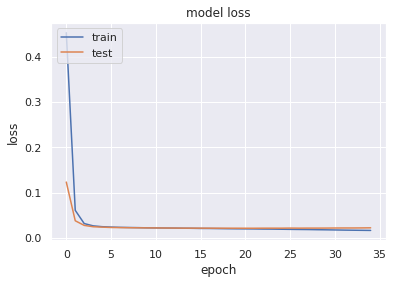

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.4527 - binary_crossentropy: 0.4521 - val_loss: 0.1223 - val_binary_crossentropy: 0.1206
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0608 - binary_crossentropy: 0.0584 - val_loss: 0.0365 - val_binary_crossentropy: 0.0336
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0315 - binary_crossentropy: 0.0282 - val_loss: 0.0273 - val_binary_crossentropy: 0.0238
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0244 - val_binary_crossentropy: 0.0206
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0235 - val_binary_crossentropy: 0.0195
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0238 - binary_crossentropy: 0.0197 - val_loss: 0.0230 - val_binary_crossentropy: 0.01

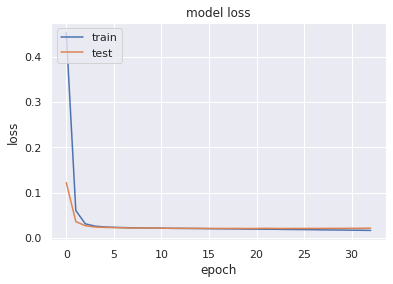

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4512 - binary_crossentropy: 0.4506 - val_loss: 0.1263 - val_binary_crossentropy: 0.1247
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0603 - binary_crossentropy: 0.0579 - val_loss: 0.0346 - val_binary_crossentropy: 0.0316
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0313 - binary_crossentropy: 0.0281 - val_loss: 0.0274 - val_binary_crossentropy: 0.0240
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0263 - binary_crossentropy: 0.0226 - val_loss: 0.0255 - val_binary_crossentropy: 0.0218
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0236 - val_binary_crossentropy: 0.0196
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0230 - val_binary_crossentropy: 0.01

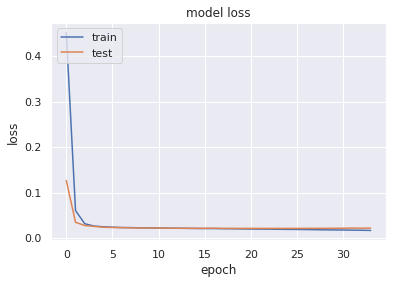

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.4505 - binary_crossentropy: 0.4499 - val_loss: 0.1250 - val_binary_crossentropy: 0.1233
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0598 - binary_crossentropy: 0.0573 - val_loss: 0.0366 - val_binary_crossentropy: 0.0337
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0314 - binary_crossentropy: 0.0281 - val_loss: 0.0268 - val_binary_crossentropy: 0.0233
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0247 - val_binary_crossentropy: 0.0210
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0246 - binary_crossentropy: 0.0206 - val_loss: 0.0236 - val_binary_crossentropy: 0.0196
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0236 - binary_crossentropy: 0.0195 - val_loss: 0.0229 - val_binary_crossentropy: 0.01

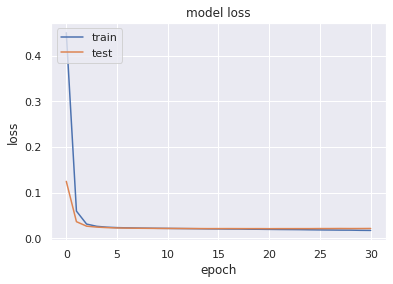

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.4504 - binary_crossentropy: 0.4498 - val_loss: 0.1293 - val_binary_crossentropy: 0.1276
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0604 - binary_crossentropy: 0.0580 - val_loss: 0.0356 - val_binary_crossentropy: 0.0327
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0318 - binary_crossentropy: 0.0286 - val_loss: 0.0271 - val_binary_crossentropy: 0.0235
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0265 - binary_crossentropy: 0.0229 - val_loss: 0.0251 - val_binary_crossentropy: 0.0213
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0247 - binary_crossentropy: 0.0208 - val_loss: 0.0237 - val_binary_crossentropy: 0.0197
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0228 - val_binary_crossentropy: 0.01

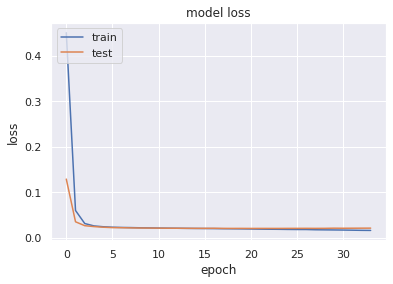

start fold 7
Epoch 1/80
160/160 [==============================] - 3s 17ms/step - loss: 0.4523 - binary_crossentropy: 0.4517 - val_loss: 0.1185 - val_binary_crossentropy: 0.1169
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0602 - binary_crossentropy: 0.0578 - val_loss: 0.0356 - val_binary_crossentropy: 0.0327
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0314 - binary_crossentropy: 0.0281 - val_loss: 0.0273 - val_binary_crossentropy: 0.0238
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0249 - val_binary_crossentropy: 0.0211
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0247 - binary_crossentropy: 0.0208 - val_loss: 0.0234 - val_binary_crossentropy: 0.0194
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0195 - val_loss: 0.0231 - val_binary_crossentropy: 0.01

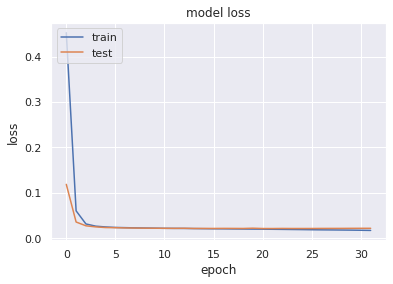

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4532 - binary_crossentropy: 0.4526 - val_loss: 0.1259 - val_binary_crossentropy: 0.1243
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0601 - binary_crossentropy: 0.0576 - val_loss: 0.0365 - val_binary_crossentropy: 0.0336
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0311 - binary_crossentropy: 0.0278 - val_loss: 0.0270 - val_binary_crossentropy: 0.0235
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0262 - binary_crossentropy: 0.0225 - val_loss: 0.0246 - val_binary_crossentropy: 0.0207
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0245 - binary_crossentropy: 0.0206 - val_loss: 0.0234 - val_binary_crossentropy: 0.0193
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0195 - val_loss: 0.0229 - val_binary_crossentropy: 0.01

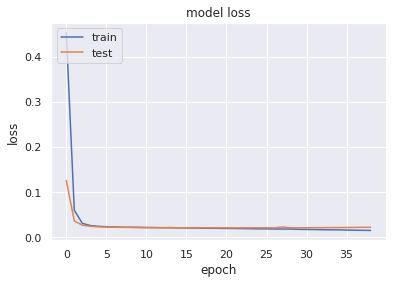

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.4511 - binary_crossentropy: 0.4505 - val_loss: 0.1208 - val_binary_crossentropy: 0.1191
Epoch 2/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0609 - binary_crossentropy: 0.0585 - val_loss: 0.0360 - val_binary_crossentropy: 0.0330
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0314 - binary_crossentropy: 0.0282 - val_loss: 0.0274 - val_binary_crossentropy: 0.0240
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0264 - binary_crossentropy: 0.0228 - val_loss: 0.0249 - val_binary_crossentropy: 0.0211
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0247 - binary_crossentropy: 0.0207 - val_loss: 0.0236 - val_binary_crossentropy: 0.0196
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0231 - val_binary_crossentropy: 0.01

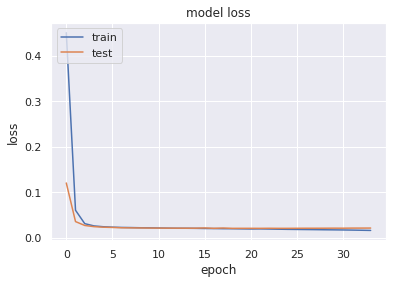

Our out of folds mean log loss score is 0.016691878777214415
start fold 0
Epoch 1/80
160/160 [==============================] - 3s 18ms/step - loss: 0.4529 - binary_crossentropy: 0.4523 - val_loss: 0.1164 - val_binary_crossentropy: 0.1147
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0610 - binary_crossentropy: 0.0586 - val_loss: 0.0365 - val_binary_crossentropy: 0.0336
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0314 - binary_crossentropy: 0.0282 - val_loss: 0.0279 - val_binary_crossentropy: 0.0245
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0264 - binary_crossentropy: 0.0228 - val_loss: 0.0248 - val_binary_crossentropy: 0.0210
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0247 - binary_crossentropy: 0.0208 - val_loss: 0.0235 - val_binary_crossentropy: 0.0194
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0238 - binary_crossentro

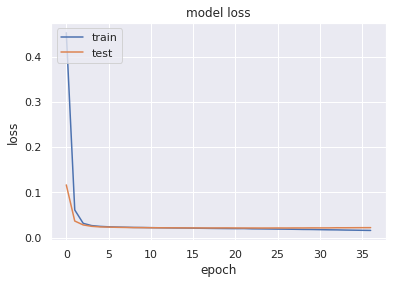

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.4533 - binary_crossentropy: 0.4527 - val_loss: 0.1312 - val_binary_crossentropy: 0.1295
Epoch 2/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0614 - binary_crossentropy: 0.0590 - val_loss: 0.0376 - val_binary_crossentropy: 0.0347
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0316 - binary_crossentropy: 0.0284 - val_loss: 0.0276 - val_binary_crossentropy: 0.0241
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0264 - binary_crossentropy: 0.0228 - val_loss: 0.0250 - val_binary_crossentropy: 0.0212
Epoch 5/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0247 - binary_crossentropy: 0.0207 - val_loss: 0.0237 - val_binary_crossentropy: 0.0196
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0231 - val_binary_crossentropy: 0.01

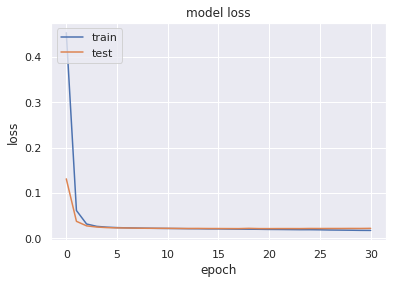

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.4525 - binary_crossentropy: 0.4519 - val_loss: 0.1373 - val_binary_crossentropy: 0.1357
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0604 - binary_crossentropy: 0.0580 - val_loss: 0.0362 - val_binary_crossentropy: 0.0333
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0315 - binary_crossentropy: 0.0282 - val_loss: 0.0271 - val_binary_crossentropy: 0.0236
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0266 - binary_crossentropy: 0.0229 - val_loss: 0.0246 - val_binary_crossentropy: 0.0207
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0247 - binary_crossentropy: 0.0207 - val_loss: 0.0242 - val_binary_crossentropy: 0.0202
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0230 - val_binary_crossentropy: 0.01

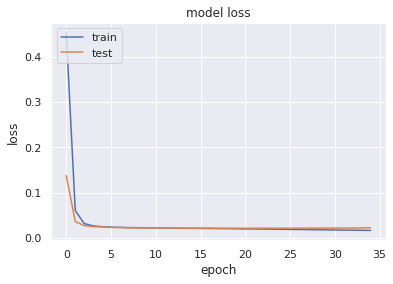

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4527 - binary_crossentropy: 0.4522 - val_loss: 0.1208 - val_binary_crossentropy: 0.1192
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0605 - binary_crossentropy: 0.0581 - val_loss: 0.0366 - val_binary_crossentropy: 0.0337
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0316 - binary_crossentropy: 0.0283 - val_loss: 0.0269 - val_binary_crossentropy: 0.0233
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0249 - val_binary_crossentropy: 0.0211
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0248 - binary_crossentropy: 0.0208 - val_loss: 0.0238 - val_binary_crossentropy: 0.0198
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0238 - binary_crossentropy: 0.0197 - val_loss: 0.0230 - val_binary_crossentropy: 0.01

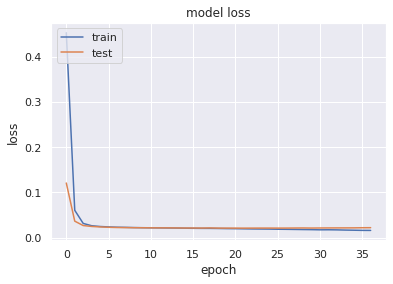

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4504 - binary_crossentropy: 0.4498 - val_loss: 0.1179 - val_binary_crossentropy: 0.1162
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0602 - binary_crossentropy: 0.0578 - val_loss: 0.0362 - val_binary_crossentropy: 0.0333
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0315 - binary_crossentropy: 0.0282 - val_loss: 0.0269 - val_binary_crossentropy: 0.0234
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0249 - val_binary_crossentropy: 0.0211
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0235 - val_binary_crossentropy: 0.0195
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0230 - val_binary_crossentropy: 0.018

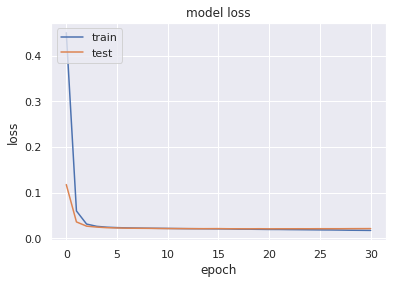

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.4513 - binary_crossentropy: 0.4507 - val_loss: 0.1331 - val_binary_crossentropy: 0.1315
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0605 - binary_crossentropy: 0.0581 - val_loss: 0.0363 - val_binary_crossentropy: 0.0333
Epoch 3/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0315 - binary_crossentropy: 0.0282 - val_loss: 0.0275 - val_binary_crossentropy: 0.0240
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0245 - val_binary_crossentropy: 0.0206
Epoch 5/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0246 - binary_crossentropy: 0.0206 - val_loss: 0.0233 - val_binary_crossentropy: 0.0192
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0228 - val_binary_crossentropy: 0.0186


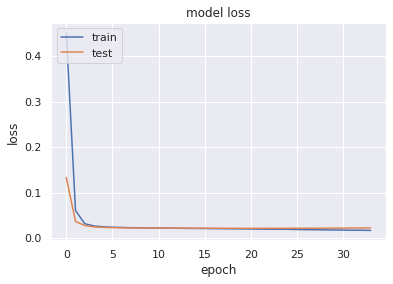

start fold 6
Epoch 1/80
160/160 [==============================] - 3s 19ms/step - loss: 0.4529 - binary_crossentropy: 0.4524 - val_loss: 0.1145 - val_binary_crossentropy: 0.1128
Epoch 2/80
160/160 [==============================] - 3s 16ms/step - loss: 0.0609 - binary_crossentropy: 0.0585 - val_loss: 0.0362 - val_binary_crossentropy: 0.0333
Epoch 3/80
160/160 [==============================] - 3s 16ms/step - loss: 0.0314 - binary_crossentropy: 0.0281 - val_loss: 0.0269 - val_binary_crossentropy: 0.0233
Epoch 4/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0246 - val_binary_crossentropy: 0.0208
Epoch 5/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0235 - val_binary_crossentropy: 0.0195
Epoch 6/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0236 - binary_crossentropy: 0.0195 - val_loss: 0.0229 - val_binary_crossentropy: 0.01

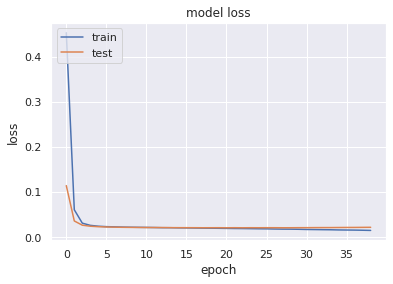

start fold 7
Epoch 1/80
160/160 [==============================] - 4s 23ms/step - loss: 0.4527 - binary_crossentropy: 0.4521 - val_loss: 0.1159 - val_binary_crossentropy: 0.1142
Epoch 2/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0604 - binary_crossentropy: 0.0580 - val_loss: 0.0366 - val_binary_crossentropy: 0.0337
Epoch 3/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0315 - binary_crossentropy: 0.0283 - val_loss: 0.0273 - val_binary_crossentropy: 0.0238
Epoch 4/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0249 - val_binary_crossentropy: 0.0211
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0247 - binary_crossentropy: 0.0207 - val_loss: 0.0236 - val_binary_crossentropy: 0.0195
Epoch 6/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0230 - val_binary_crossentropy: 0.01

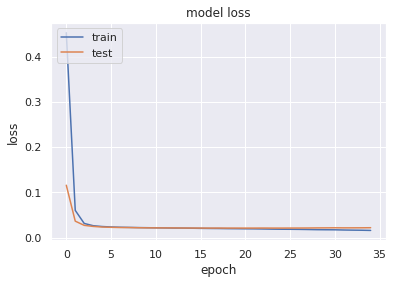

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.4515 - binary_crossentropy: 0.4509 - val_loss: 0.1148 - val_binary_crossentropy: 0.1131
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0605 - binary_crossentropy: 0.0581 - val_loss: 0.0363 - val_binary_crossentropy: 0.0333
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0315 - binary_crossentropy: 0.0282 - val_loss: 0.0272 - val_binary_crossentropy: 0.0237
Epoch 4/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0265 - binary_crossentropy: 0.0228 - val_loss: 0.0247 - val_binary_crossentropy: 0.0209
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0235 - val_binary_crossentropy: 0.0195
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0196 - val_loss: 0.0229 - val_binary_crossentropy: 0.01

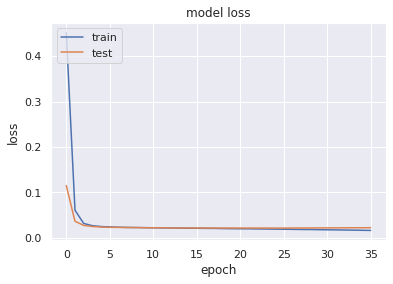

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.4532 - binary_crossentropy: 0.4526 - val_loss: 0.1261 - val_binary_crossentropy: 0.1245
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0603 - binary_crossentropy: 0.0579 - val_loss: 0.0359 - val_binary_crossentropy: 0.0330
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0314 - binary_crossentropy: 0.0282 - val_loss: 0.0268 - val_binary_crossentropy: 0.0232
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0264 - binary_crossentropy: 0.0227 - val_loss: 0.0245 - val_binary_crossentropy: 0.0206
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0246 - binary_crossentropy: 0.0207 - val_loss: 0.0235 - val_binary_crossentropy: 0.0194
Epoch 6/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0237 - binary_crossentropy: 0.0195 - val_loss: 0.0228 - val_binary_crossentropy: 0.018

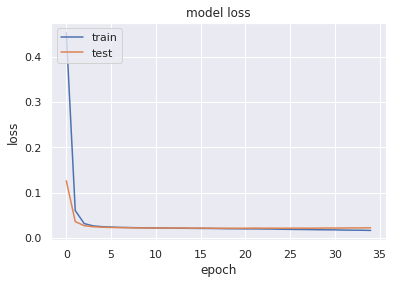

Our out of folds mean log loss score is 0.01677329017080852
CPU times: user 1h 29min 2s, sys: 7min 15s, total: 1h 36min 17s
Wall time: 1h 19min 26s


In [30]:
%%time
for SEED in SEEDS3:
    test_pred, oof_pred = train_and_evaluate(train, test, train_targets, features, start_predictors, SEED=SEED, MODEL = '3l')

start fold 0
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.5862 - binary_crossentropy: 0.5859 - val_loss: 0.2838 - val_binary_crossentropy: 0.2830
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1339 - binary_crossentropy: 0.1321 - val_loss: 0.0599 - val_binary_crossentropy: 0.0575
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0454 - binary_crossentropy: 0.0426 - val_loss: 0.0339 - val_binary_crossentropy: 0.0308
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0321 - binary_crossentropy: 0.0287 - val_loss: 0.0285 - val_binary_crossentropy: 0.0249
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0281 - binary_crossentropy: 0.0244 - val_loss: 0.0262 - val_binary_crossentropy: 0.0224
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0249 - val_binary_crossentropy: 0.0208
Ep

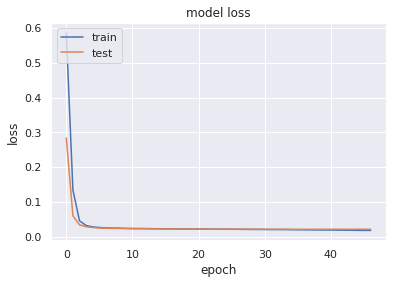

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5829 - binary_crossentropy: 0.5827 - val_loss: 0.2753 - val_binary_crossentropy: 0.2744
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1312 - binary_crossentropy: 0.1294 - val_loss: 0.0570 - val_binary_crossentropy: 0.0546
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0447 - binary_crossentropy: 0.0419 - val_loss: 0.0345 - val_binary_crossentropy: 0.0314
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0318 - binary_crossentropy: 0.0285 - val_loss: 0.0280 - val_binary_crossentropy: 0.0245
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0281 - binary_crossentropy: 0.0244 - val_loss: 0.0261 - val_binary_crossentropy: 0.0223
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0247 - val_binary_crossentropy: 0.0207
Ep

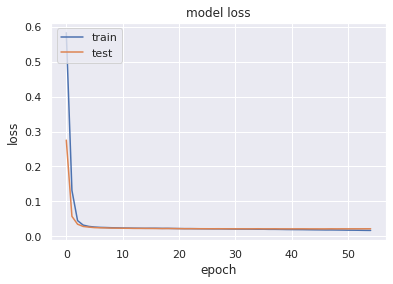

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.5744 - binary_crossentropy: 0.5741 - val_loss: 0.2793 - val_binary_crossentropy: 0.2783
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1297 - binary_crossentropy: 0.1280 - val_loss: 0.0562 - val_binary_crossentropy: 0.0538
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0446 - binary_crossentropy: 0.0418 - val_loss: 0.0330 - val_binary_crossentropy: 0.0298
Epoch 4/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0322 - binary_crossentropy: 0.0289 - val_loss: 0.0282 - val_binary_crossentropy: 0.0246
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0281 - binary_crossentropy: 0.0244 - val_loss: 0.0259 - val_binary_crossentropy: 0.0220
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0262 - binary_crossentropy: 0.0222 - val_loss: 0.0249 - val_binary_crossentropy: 0.0208


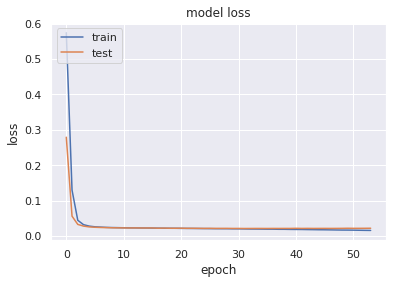

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.5789 - binary_crossentropy: 0.5787 - val_loss: 0.2808 - val_binary_crossentropy: 0.2799
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1300 - binary_crossentropy: 0.1283 - val_loss: 0.0570 - val_binary_crossentropy: 0.0546
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0447 - binary_crossentropy: 0.0419 - val_loss: 0.0337 - val_binary_crossentropy: 0.0306
Epoch 4/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0318 - binary_crossentropy: 0.0285 - val_loss: 0.0278 - val_binary_crossentropy: 0.0243
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0280 - binary_crossentropy: 0.0243 - val_loss: 0.0259 - val_binary_crossentropy: 0.0222
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0263 - binary_crossentropy: 0.0223 - val_loss: 0.0247 - val_binary_crossentropy: 0.0207
Ep

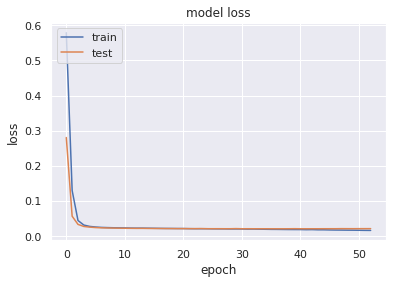

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5830 - binary_crossentropy: 0.5827 - val_loss: 0.2813 - val_binary_crossentropy: 0.2804
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1325 - binary_crossentropy: 0.1308 - val_loss: 0.0570 - val_binary_crossentropy: 0.0547
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0455 - binary_crossentropy: 0.0427 - val_loss: 0.0329 - val_binary_crossentropy: 0.0297
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0324 - binary_crossentropy: 0.0291 - val_loss: 0.0281 - val_binary_crossentropy: 0.0246
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0280 - binary_crossentropy: 0.0243 - val_loss: 0.0258 - val_binary_crossentropy: 0.0220
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0265 - binary_crossentropy: 0.0226 - val_loss: 0.0254 - val_binary_crossentropy: 0.0214
Ep

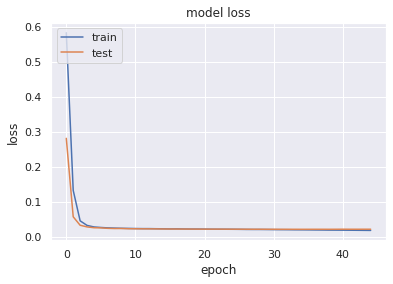

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5773 - binary_crossentropy: 0.5771 - val_loss: 0.2802 - val_binary_crossentropy: 0.2793
Epoch 2/80
160/160 [==============================] - 1s 7ms/step - loss: 0.1312 - binary_crossentropy: 0.1295 - val_loss: 0.0580 - val_binary_crossentropy: 0.0556
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0453 - binary_crossentropy: 0.0425 - val_loss: 0.0335 - val_binary_crossentropy: 0.0304
Epoch 4/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0320 - binary_crossentropy: 0.0287 - val_loss: 0.0281 - val_binary_crossentropy: 0.0246
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0280 - binary_crossentropy: 0.0244 - val_loss: 0.0259 - val_binary_crossentropy: 0.0221
Epoch 6/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0263 - binary_crossentropy: 0.0223 - val_loss: 0.0246 - val_binary_crossentropy: 0.0206
Ep

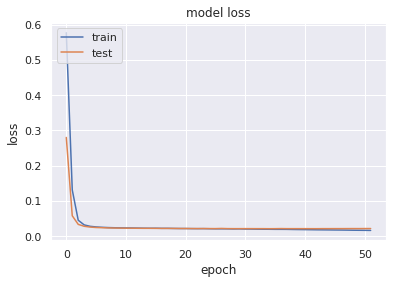

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.5789 - binary_crossentropy: 0.5786 - val_loss: 0.2819 - val_binary_crossentropy: 0.2810
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.1319 - binary_crossentropy: 0.1302 - val_loss: 0.0587 - val_binary_crossentropy: 0.0563
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0448 - binary_crossentropy: 0.0420 - val_loss: 0.0338 - val_binary_crossentropy: 0.0307
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0324 - binary_crossentropy: 0.0290 - val_loss: 0.0280 - val_binary_crossentropy: 0.0245
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0281 - binary_crossentropy: 0.0245 - val_loss: 0.0261 - val_binary_crossentropy: 0.0223
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0261 - binary_crossentropy: 0.0222 - val_loss: 0.0248 - val_binary_crossentropy: 0.0208
Ep

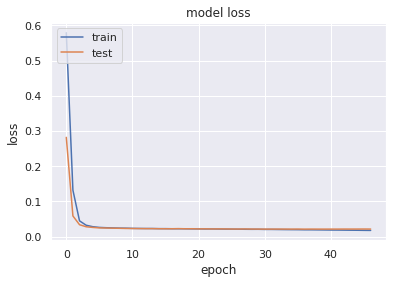

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.5803 - binary_crossentropy: 0.5800 - val_loss: 0.2888 - val_binary_crossentropy: 0.2880
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.1301 - binary_crossentropy: 0.1284 - val_loss: 0.0561 - val_binary_crossentropy: 0.0537
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0451 - binary_crossentropy: 0.0423 - val_loss: 0.0348 - val_binary_crossentropy: 0.0317
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0321 - binary_crossentropy: 0.0287 - val_loss: 0.0281 - val_binary_crossentropy: 0.0246
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0280 - binary_crossentropy: 0.0243 - val_loss: 0.0261 - val_binary_crossentropy: 0.0223
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0264 - binary_crossentropy: 0.0225 - val_loss: 0.0250 - val_binary_crossentropy: 0.0209
Ep

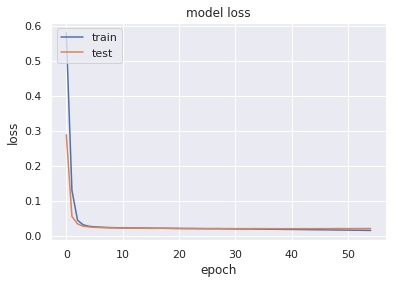

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5814 - binary_crossentropy: 0.5812 - val_loss: 0.2860 - val_binary_crossentropy: 0.2851
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1318 - binary_crossentropy: 0.1301 - val_loss: 0.0594 - val_binary_crossentropy: 0.0571
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0450 - binary_crossentropy: 0.0422 - val_loss: 0.0347 - val_binary_crossentropy: 0.0316
Epoch 4/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0321 - binary_crossentropy: 0.0288 - val_loss: 0.0278 - val_binary_crossentropy: 0.0242
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0283 - binary_crossentropy: 0.0246 - val_loss: 0.0257 - val_binary_crossentropy: 0.0219
Epoch 6/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0248 - val_binary_crossentropy: 0.0209
Ep

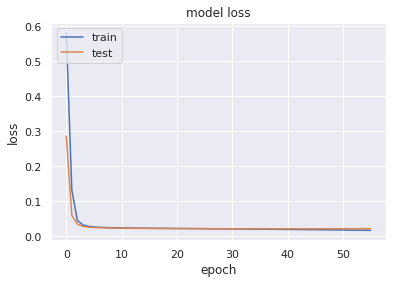

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5775 - binary_crossentropy: 0.5772 - val_loss: 0.2855 - val_binary_crossentropy: 0.2846
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.1306 - binary_crossentropy: 0.1288 - val_loss: 0.0573 - val_binary_crossentropy: 0.0549
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0447 - binary_crossentropy: 0.0419 - val_loss: 0.0346 - val_binary_crossentropy: 0.0315
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0323 - binary_crossentropy: 0.0289 - val_loss: 0.0279 - val_binary_crossentropy: 0.0243
Epoch 5/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0282 - binary_crossentropy: 0.0245 - val_loss: 0.0256 - val_binary_crossentropy: 0.0218
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0265 - binary_crossentropy: 0.0225 - val_loss: 0.0251 - val_binary_crossentropy: 0.0211
Ep

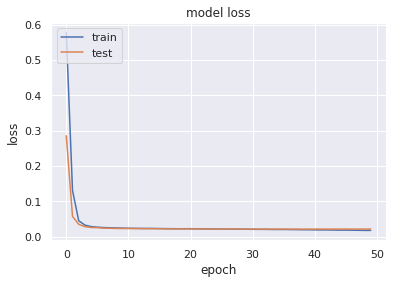

Our out of folds mean log loss score is 0.016427616801008384
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.5816 - binary_crossentropy: 0.5813 - val_loss: 0.2858 - val_binary_crossentropy: 0.2849
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1317 - binary_crossentropy: 0.1299 - val_loss: 0.0562 - val_binary_crossentropy: 0.0538
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0449 - binary_crossentropy: 0.0421 - val_loss: 0.0337 - val_binary_crossentropy: 0.0306
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0322 - binary_crossentropy: 0.0289 - val_loss: 0.0278 - val_binary_crossentropy: 0.0242
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0281 - binary_crossentropy: 0.0244 - val_loss: 0.0261 - val_binary_crossentropy: 0.0223
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0264 - binary_crossentropy: 0

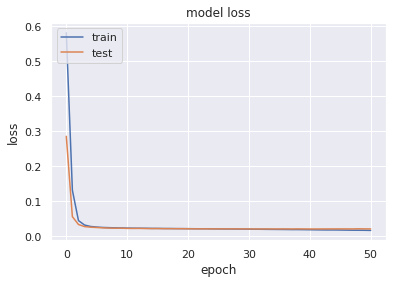

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5796 - binary_crossentropy: 0.5793 - val_loss: 0.2814 - val_binary_crossentropy: 0.2805
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.1305 - binary_crossentropy: 0.1287 - val_loss: 0.0553 - val_binary_crossentropy: 0.0529
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0449 - binary_crossentropy: 0.0421 - val_loss: 0.0338 - val_binary_crossentropy: 0.0307
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0323 - binary_crossentropy: 0.0289 - val_loss: 0.0281 - val_binary_crossentropy: 0.0246
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0282 - binary_crossentropy: 0.0246 - val_loss: 0.0263 - val_binary_crossentropy: 0.0225
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0250 - val_binary_crossentropy: 0.0210


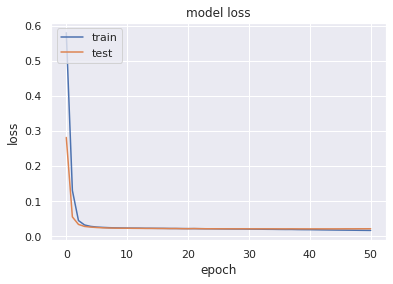

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5807 - binary_crossentropy: 0.5804 - val_loss: 0.2867 - val_binary_crossentropy: 0.2859
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1314 - binary_crossentropy: 0.1297 - val_loss: 0.0568 - val_binary_crossentropy: 0.0544
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0449 - binary_crossentropy: 0.0421 - val_loss: 0.0335 - val_binary_crossentropy: 0.0304
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0325 - binary_crossentropy: 0.0292 - val_loss: 0.0282 - val_binary_crossentropy: 0.0247
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0280 - binary_crossentropy: 0.0244 - val_loss: 0.0261 - val_binary_crossentropy: 0.0223
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0264 - binary_crossentropy: 0.0225 - val_loss: 0.0249 - val_binary_crossentropy: 0.0209
E

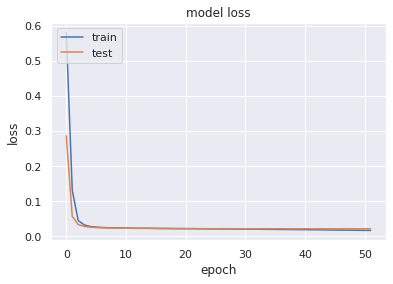

start fold 3
Epoch 1/80
160/160 [==============================] - 3s 16ms/step - loss: 0.5806 - binary_crossentropy: 0.5803 - val_loss: 0.2802 - val_binary_crossentropy: 0.2793
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.1331 - binary_crossentropy: 0.1314 - val_loss: 0.0597 - val_binary_crossentropy: 0.0574
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0449 - binary_crossentropy: 0.0421 - val_loss: 0.0329 - val_binary_crossentropy: 0.0298
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0325 - binary_crossentropy: 0.0291 - val_loss: 0.0276 - val_binary_crossentropy: 0.0240
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0282 - binary_crossentropy: 0.0245 - val_loss: 0.0260 - val_binary_crossentropy: 0.0222
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0264 - binary_crossentropy: 0.0225 - val_loss: 0.0245 - val_binary_crossentropy: 0.02

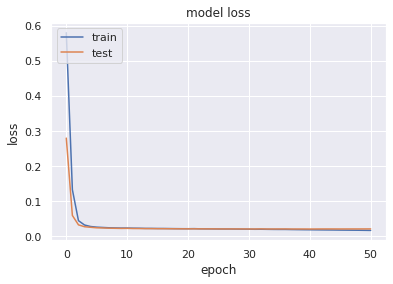

start fold 4
Epoch 1/80
160/160 [==============================] - 3s 17ms/step - loss: 0.5803 - binary_crossentropy: 0.5801 - val_loss: 0.2827 - val_binary_crossentropy: 0.2819
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.1314 - binary_crossentropy: 0.1296 - val_loss: 0.0557 - val_binary_crossentropy: 0.0532
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0448 - binary_crossentropy: 0.0420 - val_loss: 0.0334 - val_binary_crossentropy: 0.0303
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0321 - binary_crossentropy: 0.0288 - val_loss: 0.0278 - val_binary_crossentropy: 0.0243
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0281 - binary_crossentropy: 0.0244 - val_loss: 0.0258 - val_binary_crossentropy: 0.0220
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0262 - binary_crossentropy: 0.0223 - val_loss: 0.0246 - val_binary_crossentropy: 0.02

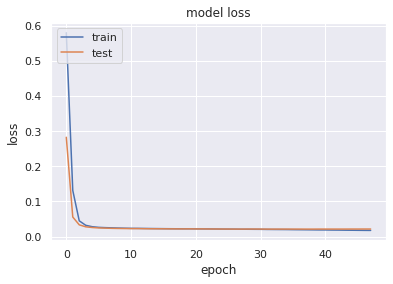

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5808 - binary_crossentropy: 0.5805 - val_loss: 0.2734 - val_binary_crossentropy: 0.2725
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.1305 - binary_crossentropy: 0.1288 - val_loss: 0.0605 - val_binary_crossentropy: 0.0581
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0446 - binary_crossentropy: 0.0418 - val_loss: 0.0337 - val_binary_crossentropy: 0.0305
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0318 - binary_crossentropy: 0.0285 - val_loss: 0.0282 - val_binary_crossentropy: 0.0246
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0281 - binary_crossentropy: 0.0244 - val_loss: 0.0262 - val_binary_crossentropy: 0.0224
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0262 - binary_crossentropy: 0.0223 - val_loss: 0.0250 - val_binary_crossentropy: 0.0210
E

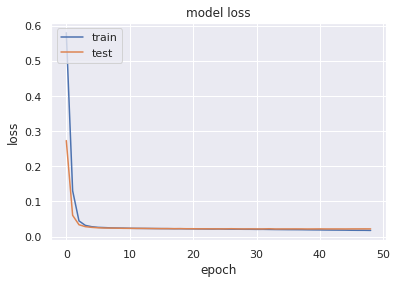

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.5821 - binary_crossentropy: 0.5818 - val_loss: 0.2808 - val_binary_crossentropy: 0.2799
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1314 - binary_crossentropy: 0.1297 - val_loss: 0.0599 - val_binary_crossentropy: 0.0575
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0457 - binary_crossentropy: 0.0429 - val_loss: 0.0336 - val_binary_crossentropy: 0.0305
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0320 - binary_crossentropy: 0.0287 - val_loss: 0.0282 - val_binary_crossentropy: 0.0247
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0281 - binary_crossentropy: 0.0244 - val_loss: 0.0257 - val_binary_crossentropy: 0.0219
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0248 - val_binary_crossentropy: 0.0208
Ep

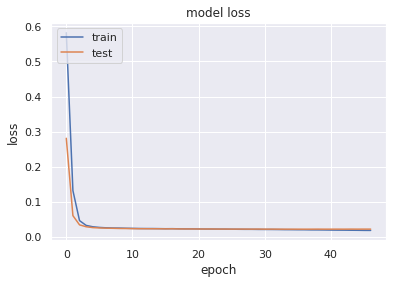

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5832 - binary_crossentropy: 0.5829 - val_loss: 0.2842 - val_binary_crossentropy: 0.2834
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1320 - binary_crossentropy: 0.1303 - val_loss: 0.0564 - val_binary_crossentropy: 0.0540
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0447 - binary_crossentropy: 0.0419 - val_loss: 0.0333 - val_binary_crossentropy: 0.0302
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0323 - binary_crossentropy: 0.0290 - val_loss: 0.0289 - val_binary_crossentropy: 0.0254
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0281 - binary_crossentropy: 0.0244 - val_loss: 0.0258 - val_binary_crossentropy: 0.0220
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0247 - val_binary_crossentropy: 0.0206
Ep

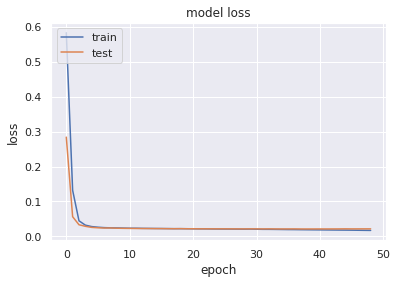

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.5818 - binary_crossentropy: 0.5815 - val_loss: 0.2894 - val_binary_crossentropy: 0.2886
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1321 - binary_crossentropy: 0.1303 - val_loss: 0.0554 - val_binary_crossentropy: 0.0530
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0450 - binary_crossentropy: 0.0422 - val_loss: 0.0338 - val_binary_crossentropy: 0.0307
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0324 - binary_crossentropy: 0.0290 - val_loss: 0.0281 - val_binary_crossentropy: 0.0246
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0284 - binary_crossentropy: 0.0247 - val_loss: 0.0261 - val_binary_crossentropy: 0.0223
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0265 - binary_crossentropy: 0.0226 - val_loss: 0.0248 - val_binary_crossentropy: 0.0208
Ep

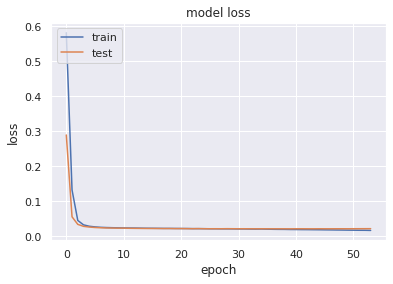

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5811 - binary_crossentropy: 0.5808 - val_loss: 0.2833 - val_binary_crossentropy: 0.2824
Epoch 2/80
160/160 [==============================] - 1s 7ms/step - loss: 0.1316 - binary_crossentropy: 0.1298 - val_loss: 0.0572 - val_binary_crossentropy: 0.0548
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0448 - binary_crossentropy: 0.0420 - val_loss: 0.0337 - val_binary_crossentropy: 0.0305
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0321 - binary_crossentropy: 0.0287 - val_loss: 0.0285 - val_binary_crossentropy: 0.0250
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0283 - binary_crossentropy: 0.0247 - val_loss: 0.0263 - val_binary_crossentropy: 0.0225
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0266 - binary_crossentropy: 0.0227 - val_loss: 0.0252 - val_binary_crossentropy: 0.0212
Ep

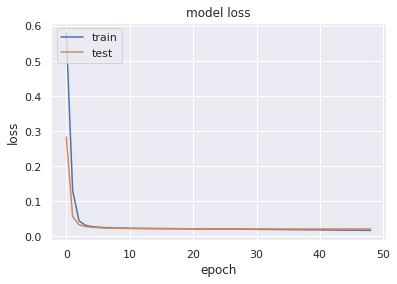

Our out of folds mean log loss score is 0.016407402952464942
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5791 - binary_crossentropy: 0.5788 - val_loss: 0.2867 - val_binary_crossentropy: 0.2858
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1296 - binary_crossentropy: 0.1279 - val_loss: 0.0567 - val_binary_crossentropy: 0.0544
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0441 - binary_crossentropy: 0.0413 - val_loss: 0.0339 - val_binary_crossentropy: 0.0308
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0316 - binary_crossentropy: 0.0283 - val_loss: 0.0277 - val_binary_crossentropy: 0.0242
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0280 - binary_crossentropy: 0.0243 - val_loss: 0.0258 - val_binary_crossentropy: 0.0220
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0263 - binary_crossentropy: 

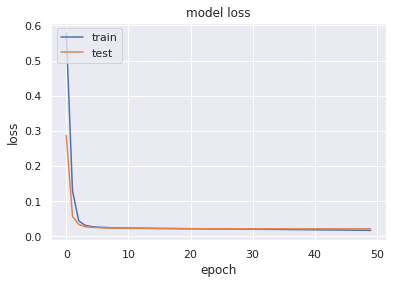

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.5786 - binary_crossentropy: 0.5783 - val_loss: 0.2867 - val_binary_crossentropy: 0.2858
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1319 - binary_crossentropy: 0.1302 - val_loss: 0.0578 - val_binary_crossentropy: 0.0554
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0446 - binary_crossentropy: 0.0418 - val_loss: 0.0338 - val_binary_crossentropy: 0.0308
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0321 - binary_crossentropy: 0.0288 - val_loss: 0.0284 - val_binary_crossentropy: 0.0249
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0280 - binary_crossentropy: 0.0244 - val_loss: 0.0259 - val_binary_crossentropy: 0.0220
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0262 - binary_crossentropy: 0.0223 - val_loss: 0.0248 - val_binary_crossentropy: 0.0208
E

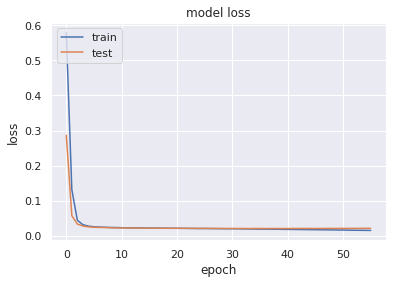

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.5806 - binary_crossentropy: 0.5803 - val_loss: 0.2850 - val_binary_crossentropy: 0.2841
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.1325 - binary_crossentropy: 0.1308 - val_loss: 0.0569 - val_binary_crossentropy: 0.0545
Epoch 3/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0451 - binary_crossentropy: 0.0423 - val_loss: 0.0340 - val_binary_crossentropy: 0.0309
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0322 - binary_crossentropy: 0.0289 - val_loss: 0.0281 - val_binary_crossentropy: 0.0245
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0283 - binary_crossentropy: 0.0246 - val_loss: 0.0264 - val_binary_crossentropy: 0.0226
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0262 - binary_crossentropy: 0.0223 - val_loss: 0.0250 - val_binary_crossentropy: 0.0210
E

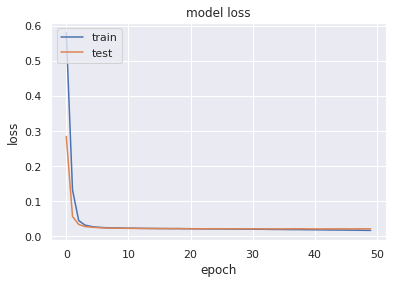

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5836 - binary_crossentropy: 0.5834 - val_loss: 0.2890 - val_binary_crossentropy: 0.2881
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1320 - binary_crossentropy: 0.1302 - val_loss: 0.0570 - val_binary_crossentropy: 0.0546
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0448 - binary_crossentropy: 0.0420 - val_loss: 0.0340 - val_binary_crossentropy: 0.0309
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0322 - binary_crossentropy: 0.0289 - val_loss: 0.0287 - val_binary_crossentropy: 0.0253
Epoch 5/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0283 - binary_crossentropy: 0.0246 - val_loss: 0.0260 - val_binary_crossentropy: 0.0222
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0265 - binary_crossentropy: 0.0226 - val_loss: 0.0248 - val_binary_crossentropy: 0.0208
E

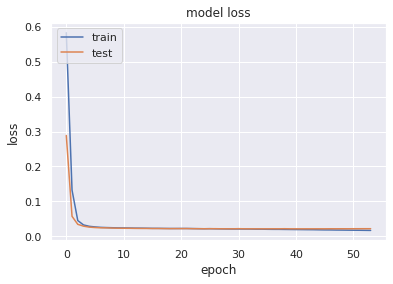

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5843 - binary_crossentropy: 0.5840 - val_loss: 0.2928 - val_binary_crossentropy: 0.2920
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1323 - binary_crossentropy: 0.1305 - val_loss: 0.0569 - val_binary_crossentropy: 0.0545
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0449 - binary_crossentropy: 0.0421 - val_loss: 0.0333 - val_binary_crossentropy: 0.0301
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0321 - binary_crossentropy: 0.0288 - val_loss: 0.0279 - val_binary_crossentropy: 0.0244
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0281 - binary_crossentropy: 0.0244 - val_loss: 0.0259 - val_binary_crossentropy: 0.0221
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0264 - binary_crossentropy: 0.0225 - val_loss: 0.0247 - val_binary_crossentropy: 0.0207
Ep

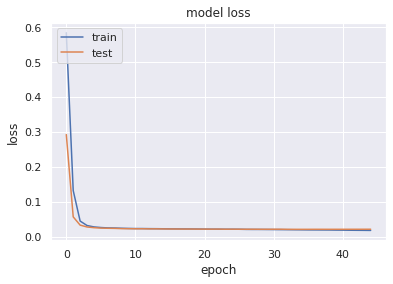

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.5785 - binary_crossentropy: 0.5782 - val_loss: 0.2821 - val_binary_crossentropy: 0.2812
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1308 - binary_crossentropy: 0.1291 - val_loss: 0.0568 - val_binary_crossentropy: 0.0544
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0449 - binary_crossentropy: 0.0421 - val_loss: 0.0333 - val_binary_crossentropy: 0.0302
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0322 - binary_crossentropy: 0.0288 - val_loss: 0.0287 - val_binary_crossentropy: 0.0252
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0281 - binary_crossentropy: 0.0244 - val_loss: 0.0257 - val_binary_crossentropy: 0.0219
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0262 - binary_crossentropy: 0.0222 - val_loss: 0.0244 - val_binary_crossentropy: 0.0204
Ep

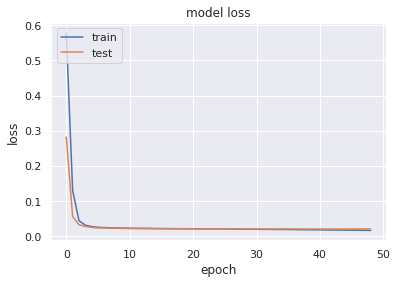

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5830 - binary_crossentropy: 0.5828 - val_loss: 0.2884 - val_binary_crossentropy: 0.2875
Epoch 2/80
160/160 [==============================] - 1s 7ms/step - loss: 0.1314 - binary_crossentropy: 0.1297 - val_loss: 0.0591 - val_binary_crossentropy: 0.0567
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0445 - binary_crossentropy: 0.0417 - val_loss: 0.0342 - val_binary_crossentropy: 0.0311
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0321 - binary_crossentropy: 0.0288 - val_loss: 0.0287 - val_binary_crossentropy: 0.0252
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0280 - binary_crossentropy: 0.0243 - val_loss: 0.0259 - val_binary_crossentropy: 0.0221
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0248 - val_binary_crossentropy: 0.0208
Ep

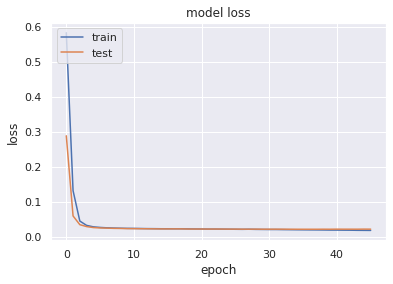

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5818 - binary_crossentropy: 0.5816 - val_loss: 0.2828 - val_binary_crossentropy: 0.2818
Epoch 2/80
160/160 [==============================] - 1s 7ms/step - loss: 0.1328 - binary_crossentropy: 0.1310 - val_loss: 0.0586 - val_binary_crossentropy: 0.0562
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0452 - binary_crossentropy: 0.0425 - val_loss: 0.0357 - val_binary_crossentropy: 0.0326
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0325 - binary_crossentropy: 0.0292 - val_loss: 0.0288 - val_binary_crossentropy: 0.0252
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0282 - binary_crossentropy: 0.0245 - val_loss: 0.0266 - val_binary_crossentropy: 0.0228
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0264 - binary_crossentropy: 0.0224 - val_loss: 0.0250 - val_binary_crossentropy: 0.0210
E

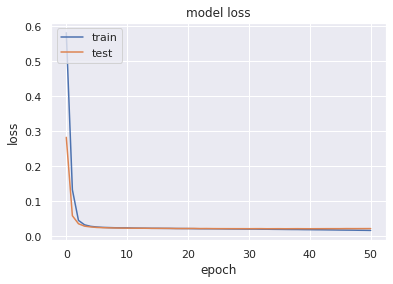

start fold 8
Epoch 1/80
160/160 [==============================] - 3s 18ms/step - loss: 0.5817 - binary_crossentropy: 0.5814 - val_loss: 0.2838 - val_binary_crossentropy: 0.2830
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.1317 - binary_crossentropy: 0.1299 - val_loss: 0.0569 - val_binary_crossentropy: 0.0545
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0452 - binary_crossentropy: 0.0424 - val_loss: 0.0339 - val_binary_crossentropy: 0.0308
Epoch 4/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0322 - binary_crossentropy: 0.0289 - val_loss: 0.0284 - val_binary_crossentropy: 0.0249
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0285 - binary_crossentropy: 0.0248 - val_loss: 0.0259 - val_binary_crossentropy: 0.0220
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0266 - binary_crossentropy: 0.0226 - val_loss: 0.0247 - val_binary_crossentropy: 0.02

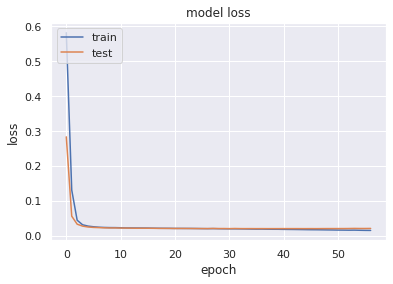

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 16ms/step - loss: 0.5809 - binary_crossentropy: 0.5806 - val_loss: 0.2863 - val_binary_crossentropy: 0.2855
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.1318 - binary_crossentropy: 0.1300 - val_loss: 0.0544 - val_binary_crossentropy: 0.0520
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0445 - binary_crossentropy: 0.0417 - val_loss: 0.0337 - val_binary_crossentropy: 0.0306
Epoch 4/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0323 - binary_crossentropy: 0.0290 - val_loss: 0.0287 - val_binary_crossentropy: 0.0252
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0281 - binary_crossentropy: 0.0244 - val_loss: 0.0261 - val_binary_crossentropy: 0.0223
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0269 - binary_crossentropy: 0.0230 - val_loss: 0.0251 - val_binary_crossentropy: 0.02

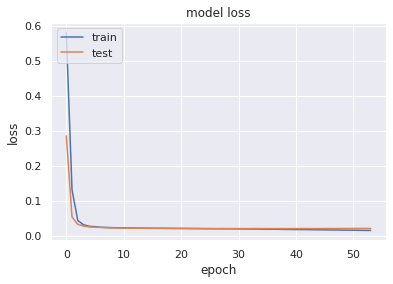

Our out of folds mean log loss score is 0.016488337095880684
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.5797 - binary_crossentropy: 0.5794 - val_loss: 0.2806 - val_binary_crossentropy: 0.2797
Epoch 2/80
160/160 [==============================] - 1s 7ms/step - loss: 0.1310 - binary_crossentropy: 0.1293 - val_loss: 0.0551 - val_binary_crossentropy: 0.0527
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0450 - binary_crossentropy: 0.0422 - val_loss: 0.0334 - val_binary_crossentropy: 0.0303
Epoch 4/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0322 - binary_crossentropy: 0.0288 - val_loss: 0.0282 - val_binary_crossentropy: 0.0246
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0283 - binary_crossentropy: 0.0246 - val_loss: 0.0260 - val_binary_crossentropy: 0.0221
Epoch 6/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0264 - binary_crossentropy: 0

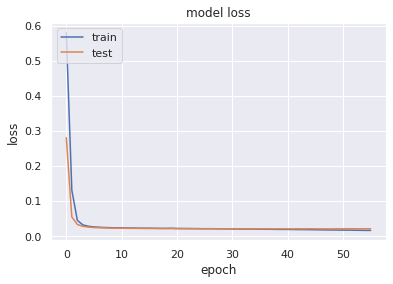

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.5803 - binary_crossentropy: 0.5800 - val_loss: 0.2817 - val_binary_crossentropy: 0.2808
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.1308 - binary_crossentropy: 0.1291 - val_loss: 0.0565 - val_binary_crossentropy: 0.0541
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0451 - binary_crossentropy: 0.0423 - val_loss: 0.0334 - val_binary_crossentropy: 0.0302
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0321 - binary_crossentropy: 0.0287 - val_loss: 0.0286 - val_binary_crossentropy: 0.0251
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0282 - binary_crossentropy: 0.0245 - val_loss: 0.0259 - val_binary_crossentropy: 0.0221
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0264 - binary_crossentropy: 0.0224 - val_loss: 0.0249 - val_binary_crossentropy: 0.0209
E

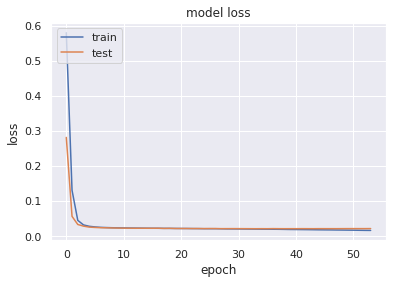

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.5788 - binary_crossentropy: 0.5785 - val_loss: 0.2793 - val_binary_crossentropy: 0.2784
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1304 - binary_crossentropy: 0.1286 - val_loss: 0.0566 - val_binary_crossentropy: 0.0542
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0448 - binary_crossentropy: 0.0420 - val_loss: 0.0332 - val_binary_crossentropy: 0.0300
Epoch 4/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0319 - binary_crossentropy: 0.0286 - val_loss: 0.0285 - val_binary_crossentropy: 0.0250
Epoch 5/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0284 - binary_crossentropy: 0.0247 - val_loss: 0.0265 - val_binary_crossentropy: 0.0227
Epoch 6/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0264 - binary_crossentropy: 0.0225 - val_loss: 0.0251 - val_binary_crossentropy: 0.0211
Ep

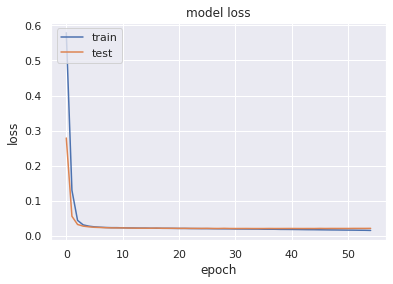

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5806 - binary_crossentropy: 0.5804 - val_loss: 0.2794 - val_binary_crossentropy: 0.2785
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1326 - binary_crossentropy: 0.1309 - val_loss: 0.0583 - val_binary_crossentropy: 0.0560
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0450 - binary_crossentropy: 0.0422 - val_loss: 0.0352 - val_binary_crossentropy: 0.0322
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0320 - binary_crossentropy: 0.0286 - val_loss: 0.0283 - val_binary_crossentropy: 0.0248
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0282 - binary_crossentropy: 0.0245 - val_loss: 0.0264 - val_binary_crossentropy: 0.0226
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0265 - binary_crossentropy: 0.0226 - val_loss: 0.0247 - val_binary_crossentropy: 0.0207
Ep

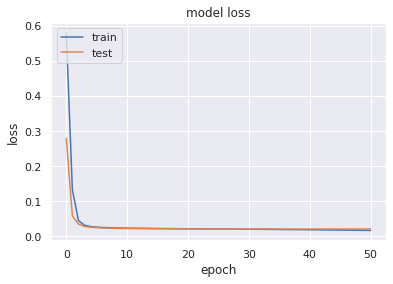

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.5795 - binary_crossentropy: 0.5792 - val_loss: 0.2926 - val_binary_crossentropy: 0.2917
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1321 - binary_crossentropy: 0.1303 - val_loss: 0.0560 - val_binary_crossentropy: 0.0536
Epoch 3/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0453 - binary_crossentropy: 0.0425 - val_loss: 0.0341 - val_binary_crossentropy: 0.0310
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0319 - binary_crossentropy: 0.0286 - val_loss: 0.0281 - val_binary_crossentropy: 0.0245
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0281 - binary_crossentropy: 0.0245 - val_loss: 0.0258 - val_binary_crossentropy: 0.0220
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0264 - binary_crossentropy: 0.0224 - val_loss: 0.0248 - val_binary_crossentropy: 0.0207
Ep

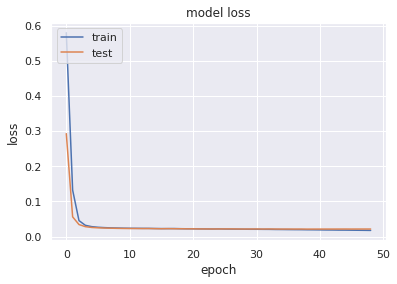

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5811 - binary_crossentropy: 0.5808 - val_loss: 0.2758 - val_binary_crossentropy: 0.2749
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.1317 - binary_crossentropy: 0.1299 - val_loss: 0.0549 - val_binary_crossentropy: 0.0525
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0445 - binary_crossentropy: 0.0417 - val_loss: 0.0338 - val_binary_crossentropy: 0.0307
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0320 - binary_crossentropy: 0.0286 - val_loss: 0.0287 - val_binary_crossentropy: 0.0252
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0282 - binary_crossentropy: 0.0245 - val_loss: 0.0264 - val_binary_crossentropy: 0.0226
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0264 - binary_crossentropy: 0.0225 - val_loss: 0.0248 - val_binary_crossentropy: 0.0207

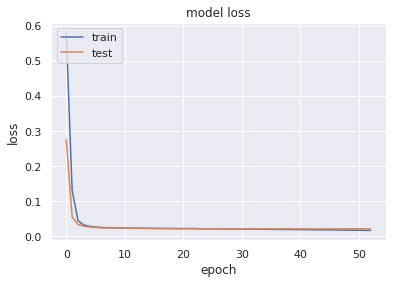

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.5815 - binary_crossentropy: 0.5812 - val_loss: 0.2856 - val_binary_crossentropy: 0.2847
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1318 - binary_crossentropy: 0.1300 - val_loss: 0.0576 - val_binary_crossentropy: 0.0552
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0452 - binary_crossentropy: 0.0424 - val_loss: 0.0333 - val_binary_crossentropy: 0.0301
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0326 - binary_crossentropy: 0.0292 - val_loss: 0.0283 - val_binary_crossentropy: 0.0247
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0284 - binary_crossentropy: 0.0248 - val_loss: 0.0267 - val_binary_crossentropy: 0.0230
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0264 - binary_crossentropy: 0.0225 - val_loss: 0.0246 - val_binary_crossentropy: 0.0205
Ep

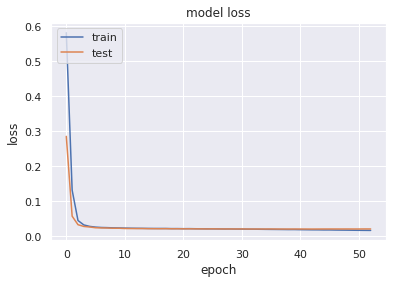

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.5806 - binary_crossentropy: 0.5803 - val_loss: 0.2859 - val_binary_crossentropy: 0.2851
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1320 - binary_crossentropy: 0.1303 - val_loss: 0.0593 - val_binary_crossentropy: 0.0569
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0447 - binary_crossentropy: 0.0419 - val_loss: 0.0340 - val_binary_crossentropy: 0.0310
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0320 - binary_crossentropy: 0.0287 - val_loss: 0.0285 - val_binary_crossentropy: 0.0250
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0279 - binary_crossentropy: 0.0242 - val_loss: 0.0261 - val_binary_crossentropy: 0.0223
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0261 - binary_crossentropy: 0.0222 - val_loss: 0.0252 - val_binary_crossentropy: 0.0212
Ep

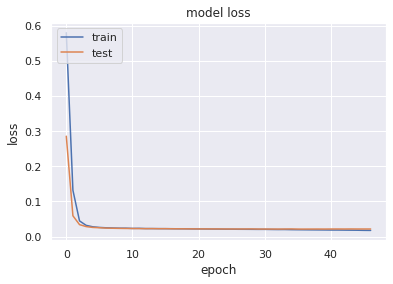

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5828 - binary_crossentropy: 0.5825 - val_loss: 0.2790 - val_binary_crossentropy: 0.2781
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1307 - binary_crossentropy: 0.1290 - val_loss: 0.0576 - val_binary_crossentropy: 0.0552
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0452 - binary_crossentropy: 0.0424 - val_loss: 0.0344 - val_binary_crossentropy: 0.0313
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0320 - binary_crossentropy: 0.0287 - val_loss: 0.0283 - val_binary_crossentropy: 0.0248
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0282 - binary_crossentropy: 0.0245 - val_loss: 0.0263 - val_binary_crossentropy: 0.0226
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0266 - binary_crossentropy: 0.0226 - val_loss: 0.0248 - val_binary_crossentropy: 0.0208
E

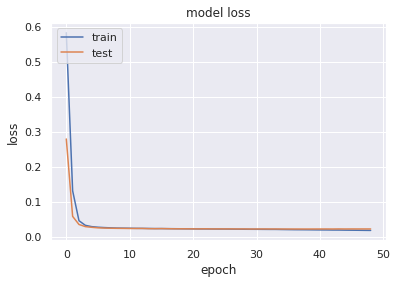

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.5781 - binary_crossentropy: 0.5778 - val_loss: 0.2804 - val_binary_crossentropy: 0.2795
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1301 - binary_crossentropy: 0.1283 - val_loss: 0.0591 - val_binary_crossentropy: 0.0567
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0444 - binary_crossentropy: 0.0416 - val_loss: 0.0339 - val_binary_crossentropy: 0.0308
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0320 - binary_crossentropy: 0.0287 - val_loss: 0.0282 - val_binary_crossentropy: 0.0247
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0282 - binary_crossentropy: 0.0245 - val_loss: 0.0260 - val_binary_crossentropy: 0.0222
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0265 - binary_crossentropy: 0.0226 - val_loss: 0.0248 - val_binary_crossentropy: 0.0208
Ep

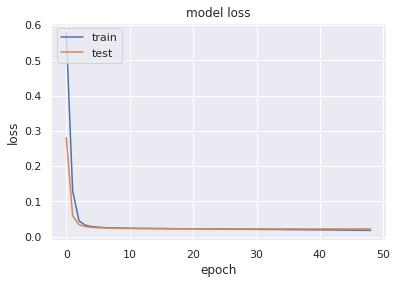

Our out of folds mean log loss score is 0.016398902112545344
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.5799 - binary_crossentropy: 0.5797 - val_loss: 0.2779 - val_binary_crossentropy: 0.2770
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.1292 - binary_crossentropy: 0.1274 - val_loss: 0.0580 - val_binary_crossentropy: 0.0557
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0444 - binary_crossentropy: 0.0416 - val_loss: 0.0344 - val_binary_crossentropy: 0.0313
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0321 - binary_crossentropy: 0.0287 - val_loss: 0.0279 - val_binary_crossentropy: 0.0244
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0284 - binary_crossentropy: 0.0247 - val_loss: 0.0259 - val_binary_crossentropy: 0.0221
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0263 - binary_crossentropy: 

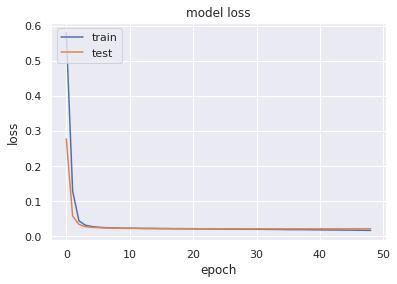

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5787 - binary_crossentropy: 0.5785 - val_loss: 0.2737 - val_binary_crossentropy: 0.2728
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1322 - binary_crossentropy: 0.1304 - val_loss: 0.0574 - val_binary_crossentropy: 0.0550
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0447 - binary_crossentropy: 0.0419 - val_loss: 0.0347 - val_binary_crossentropy: 0.0316
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0323 - binary_crossentropy: 0.0289 - val_loss: 0.0283 - val_binary_crossentropy: 0.0248
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0282 - binary_crossentropy: 0.0245 - val_loss: 0.0266 - val_binary_crossentropy: 0.0228
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0251 - val_binary_crossentropy: 0.0211
E

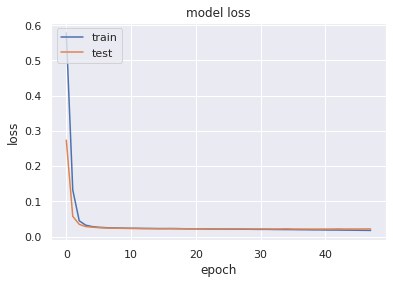

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5801 - binary_crossentropy: 0.5798 - val_loss: 0.2834 - val_binary_crossentropy: 0.2825
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1320 - binary_crossentropy: 0.1302 - val_loss: 0.0594 - val_binary_crossentropy: 0.0571
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0452 - binary_crossentropy: 0.0424 - val_loss: 0.0345 - val_binary_crossentropy: 0.0314
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0323 - binary_crossentropy: 0.0289 - val_loss: 0.0286 - val_binary_crossentropy: 0.0251
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0282 - binary_crossentropy: 0.0245 - val_loss: 0.0259 - val_binary_crossentropy: 0.0220
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0250 - val_binary_crossentropy: 0.0210
Ep

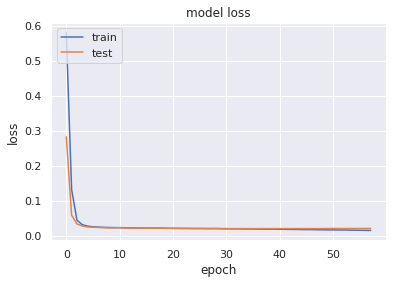

start fold 3
Epoch 1/80
160/160 [==============================] - 3s 17ms/step - loss: 0.5818 - binary_crossentropy: 0.5816 - val_loss: 0.2891 - val_binary_crossentropy: 0.2882
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.1321 - binary_crossentropy: 0.1304 - val_loss: 0.0585 - val_binary_crossentropy: 0.0561
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0448 - binary_crossentropy: 0.0420 - val_loss: 0.0335 - val_binary_crossentropy: 0.0304
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0323 - binary_crossentropy: 0.0289 - val_loss: 0.0286 - val_binary_crossentropy: 0.0250
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0289 - binary_crossentropy: 0.0252 - val_loss: 0.0260 - val_binary_crossentropy: 0.0222
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0266 - binary_crossentropy: 0.0227 - val_loss: 0.0247 - val_binary_crossentropy: 0.02

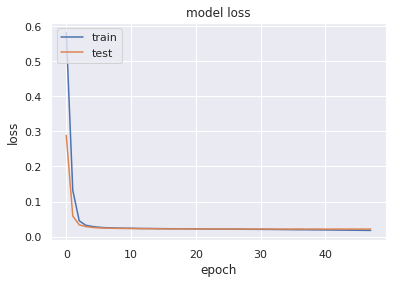

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.5846 - binary_crossentropy: 0.5843 - val_loss: 0.2883 - val_binary_crossentropy: 0.2874
Epoch 2/80
160/160 [==============================] - 2s 15ms/step - loss: 0.1331 - binary_crossentropy: 0.1314 - val_loss: 0.0575 - val_binary_crossentropy: 0.0551
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0450 - binary_crossentropy: 0.0423 - val_loss: 0.0349 - val_binary_crossentropy: 0.0318
Epoch 4/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0322 - binary_crossentropy: 0.0288 - val_loss: 0.0287 - val_binary_crossentropy: 0.0252
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0284 - binary_crossentropy: 0.0247 - val_loss: 0.0261 - val_binary_crossentropy: 0.0224
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0262 - binary_crossentropy: 0.0223 - val_loss: 0.0249 - val_binary_crossentropy: 0.02

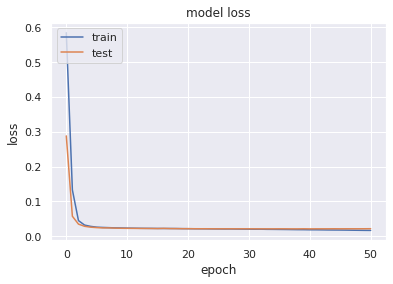

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.5799 - binary_crossentropy: 0.5797 - val_loss: 0.2887 - val_binary_crossentropy: 0.2879
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1317 - binary_crossentropy: 0.1299 - val_loss: 0.0569 - val_binary_crossentropy: 0.0545
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0450 - binary_crossentropy: 0.0422 - val_loss: 0.0339 - val_binary_crossentropy: 0.0308
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0318 - binary_crossentropy: 0.0285 - val_loss: 0.0281 - val_binary_crossentropy: 0.0245
Epoch 5/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0282 - binary_crossentropy: 0.0246 - val_loss: 0.0266 - val_binary_crossentropy: 0.0228
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0264 - binary_crossentropy: 0.0225 - val_loss: 0.0249 - val_binary_crossentropy: 0.0209


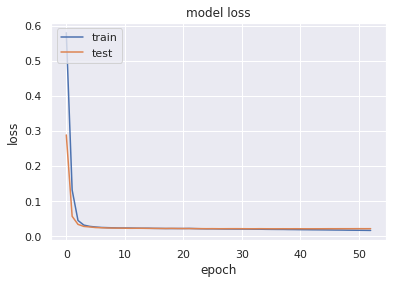

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.5822 - binary_crossentropy: 0.5819 - val_loss: 0.2840 - val_binary_crossentropy: 0.2831
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.1321 - binary_crossentropy: 0.1304 - val_loss: 0.0590 - val_binary_crossentropy: 0.0567
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0447 - binary_crossentropy: 0.0419 - val_loss: 0.0342 - val_binary_crossentropy: 0.0311
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0325 - binary_crossentropy: 0.0292 - val_loss: 0.0285 - val_binary_crossentropy: 0.0249
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0283 - binary_crossentropy: 0.0246 - val_loss: 0.0261 - val_binary_crossentropy: 0.0223
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0248 - val_binary_crossentropy: 0.0208
Ep

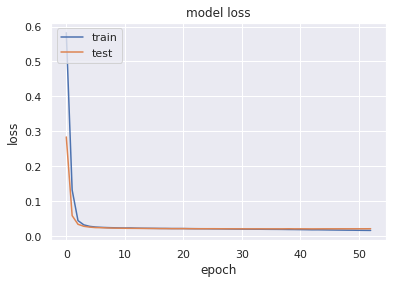

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.5785 - binary_crossentropy: 0.5782 - val_loss: 0.2817 - val_binary_crossentropy: 0.2808
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.1314 - binary_crossentropy: 0.1296 - val_loss: 0.0577 - val_binary_crossentropy: 0.0553
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0448 - binary_crossentropy: 0.0420 - val_loss: 0.0334 - val_binary_crossentropy: 0.0303
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0324 - binary_crossentropy: 0.0291 - val_loss: 0.0280 - val_binary_crossentropy: 0.0245
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0287 - binary_crossentropy: 0.0250 - val_loss: 0.0260 - val_binary_crossentropy: 0.0222
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0247 - val_binary_crossentropy: 0.0206


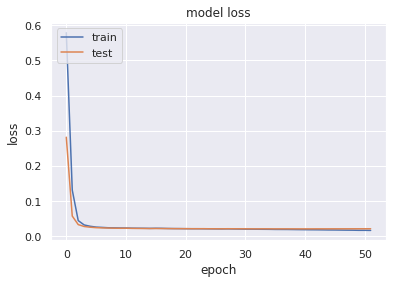

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.5793 - binary_crossentropy: 0.5790 - val_loss: 0.2885 - val_binary_crossentropy: 0.2877
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1318 - binary_crossentropy: 0.1301 - val_loss: 0.0574 - val_binary_crossentropy: 0.0550
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0448 - binary_crossentropy: 0.0420 - val_loss: 0.0344 - val_binary_crossentropy: 0.0313
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0322 - binary_crossentropy: 0.0288 - val_loss: 0.0285 - val_binary_crossentropy: 0.0249
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0281 - binary_crossentropy: 0.0245 - val_loss: 0.0260 - val_binary_crossentropy: 0.0222
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0262 - binary_crossentropy: 0.0223 - val_loss: 0.0248 - val_binary_crossentropy: 0.0208
Ep

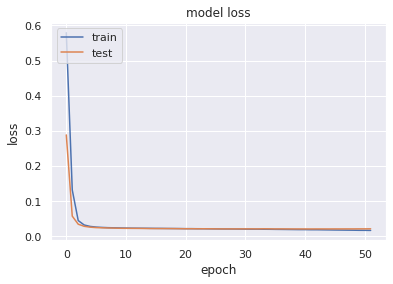

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5805 - binary_crossentropy: 0.5803 - val_loss: 0.2787 - val_binary_crossentropy: 0.2778
Epoch 2/80
160/160 [==============================] - 1s 7ms/step - loss: 0.1309 - binary_crossentropy: 0.1291 - val_loss: 0.0560 - val_binary_crossentropy: 0.0536
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0450 - binary_crossentropy: 0.0422 - val_loss: 0.0339 - val_binary_crossentropy: 0.0309
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0322 - binary_crossentropy: 0.0288 - val_loss: 0.0284 - val_binary_crossentropy: 0.0249
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0280 - binary_crossentropy: 0.0243 - val_loss: 0.0260 - val_binary_crossentropy: 0.0222
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0265 - binary_crossentropy: 0.0226 - val_loss: 0.0245 - val_binary_crossentropy: 0.0205
Ep

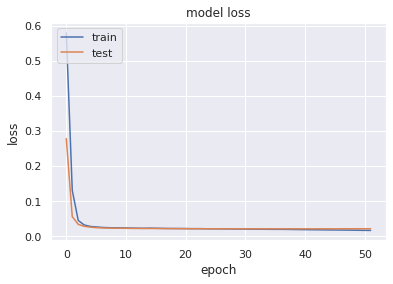

Our out of folds mean log loss score is 0.016464631212911803
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5814 - binary_crossentropy: 0.5811 - val_loss: 0.2853 - val_binary_crossentropy: 0.2844
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1328 - binary_crossentropy: 0.1310 - val_loss: 0.0610 - val_binary_crossentropy: 0.0586
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0452 - binary_crossentropy: 0.0425 - val_loss: 0.0339 - val_binary_crossentropy: 0.0308
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0322 - binary_crossentropy: 0.0288 - val_loss: 0.0286 - val_binary_crossentropy: 0.0250
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0280 - binary_crossentropy: 0.0244 - val_loss: 0.0264 - val_binary_crossentropy: 0.0226
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0262 - binary_crossentropy: 

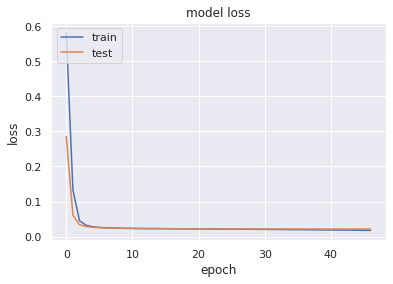

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.5817 - binary_crossentropy: 0.5814 - val_loss: 0.2787 - val_binary_crossentropy: 0.2778
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.1315 - binary_crossentropy: 0.1298 - val_loss: 0.0579 - val_binary_crossentropy: 0.0555
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0448 - binary_crossentropy: 0.0420 - val_loss: 0.0339 - val_binary_crossentropy: 0.0309
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0326 - binary_crossentropy: 0.0292 - val_loss: 0.0280 - val_binary_crossentropy: 0.0245
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0281 - binary_crossentropy: 0.0244 - val_loss: 0.0265 - val_binary_crossentropy: 0.0228
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0264 - binary_crossentropy: 0.0225 - val_loss: 0.0253 - val_binary_crossentropy: 0.0214
E

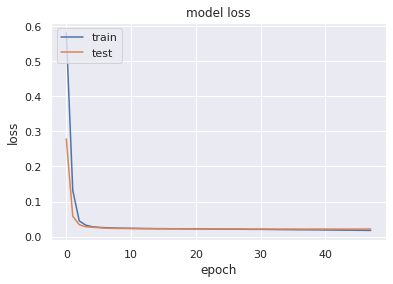

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5797 - binary_crossentropy: 0.5794 - val_loss: 0.2826 - val_binary_crossentropy: 0.2817
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1316 - binary_crossentropy: 0.1298 - val_loss: 0.0560 - val_binary_crossentropy: 0.0535
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0449 - binary_crossentropy: 0.0421 - val_loss: 0.0346 - val_binary_crossentropy: 0.0315
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0321 - binary_crossentropy: 0.0287 - val_loss: 0.0286 - val_binary_crossentropy: 0.0251
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0286 - binary_crossentropy: 0.0249 - val_loss: 0.0266 - val_binary_crossentropy: 0.0228
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0265 - binary_crossentropy: 0.0225 - val_loss: 0.0253 - val_binary_crossentropy: 0.0213
Ep

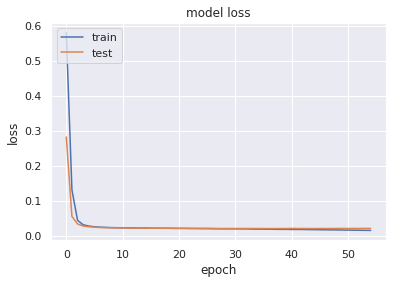

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.5807 - binary_crossentropy: 0.5804 - val_loss: 0.2799 - val_binary_crossentropy: 0.2790
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1312 - binary_crossentropy: 0.1295 - val_loss: 0.0575 - val_binary_crossentropy: 0.0551
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0450 - binary_crossentropy: 0.0422 - val_loss: 0.0332 - val_binary_crossentropy: 0.0301
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0324 - binary_crossentropy: 0.0290 - val_loss: 0.0280 - val_binary_crossentropy: 0.0244
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0282 - binary_crossentropy: 0.0245 - val_loss: 0.0259 - val_binary_crossentropy: 0.0220
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0265 - binary_crossentropy: 0.0226 - val_loss: 0.0248 - val_binary_crossentropy: 0.0208
Ep

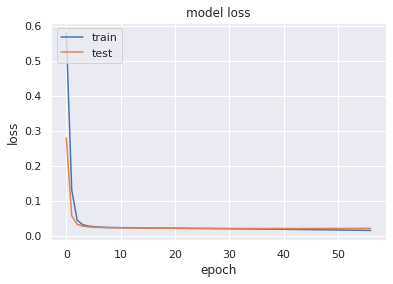

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5789 - binary_crossentropy: 0.5786 - val_loss: 0.2797 - val_binary_crossentropy: 0.2788
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1320 - binary_crossentropy: 0.1303 - val_loss: 0.0573 - val_binary_crossentropy: 0.0549
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0452 - binary_crossentropy: 0.0424 - val_loss: 0.0343 - val_binary_crossentropy: 0.0312
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0321 - binary_crossentropy: 0.0288 - val_loss: 0.0283 - val_binary_crossentropy: 0.0247
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0285 - binary_crossentropy: 0.0248 - val_loss: 0.0258 - val_binary_crossentropy: 0.0219
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0265 - binary_crossentropy: 0.0225 - val_loss: 0.0246 - val_binary_crossentropy: 0.0206


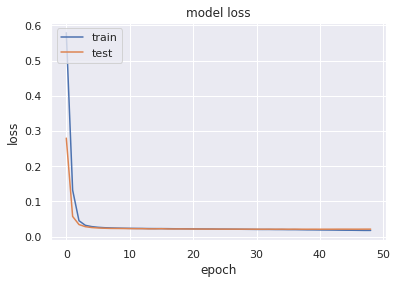

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.5795 - binary_crossentropy: 0.5792 - val_loss: 0.2830 - val_binary_crossentropy: 0.2822
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1314 - binary_crossentropy: 0.1296 - val_loss: 0.0569 - val_binary_crossentropy: 0.0545
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0447 - binary_crossentropy: 0.0419 - val_loss: 0.0337 - val_binary_crossentropy: 0.0306
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0324 - binary_crossentropy: 0.0291 - val_loss: 0.0289 - val_binary_crossentropy: 0.0254
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0281 - binary_crossentropy: 0.0244 - val_loss: 0.0266 - val_binary_crossentropy: 0.0228
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0264 - binary_crossentropy: 0.0225 - val_loss: 0.0249 - val_binary_crossentropy: 0.0210
Ep

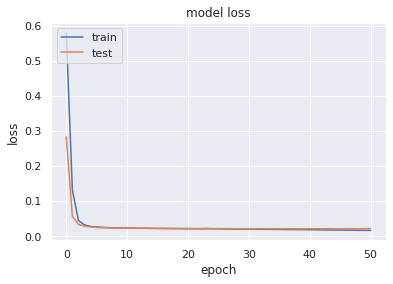

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.5800 - binary_crossentropy: 0.5797 - val_loss: 0.2893 - val_binary_crossentropy: 0.2884
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1324 - binary_crossentropy: 0.1306 - val_loss: 0.0565 - val_binary_crossentropy: 0.0541
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0445 - binary_crossentropy: 0.0417 - val_loss: 0.0339 - val_binary_crossentropy: 0.0308
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0317 - binary_crossentropy: 0.0284 - val_loss: 0.0281 - val_binary_crossentropy: 0.0245
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0280 - binary_crossentropy: 0.0243 - val_loss: 0.0258 - val_binary_crossentropy: 0.0220
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0264 - binary_crossentropy: 0.0225 - val_loss: 0.0247 - val_binary_crossentropy: 0.0207
E

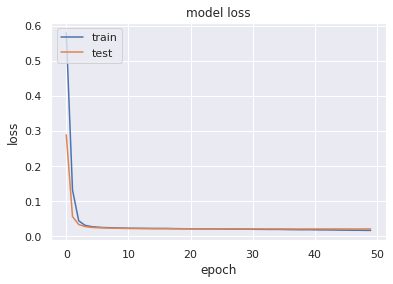

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.5805 - binary_crossentropy: 0.5803 - val_loss: 0.2819 - val_binary_crossentropy: 0.2810
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.1312 - binary_crossentropy: 0.1295 - val_loss: 0.0576 - val_binary_crossentropy: 0.0551
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0444 - binary_crossentropy: 0.0416 - val_loss: 0.0338 - val_binary_crossentropy: 0.0307
Epoch 4/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0324 - binary_crossentropy: 0.0291 - val_loss: 0.0278 - val_binary_crossentropy: 0.0242
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0283 - binary_crossentropy: 0.0246 - val_loss: 0.0258 - val_binary_crossentropy: 0.0220
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0264 - binary_crossentropy: 0.0225 - val_loss: 0.0246 - val_binary_crossentropy: 0.02

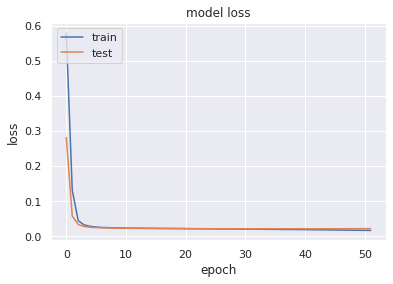

start fold 8
Epoch 1/80
160/160 [==============================] - 3s 17ms/step - loss: 0.5802 - binary_crossentropy: 0.5799 - val_loss: 0.2766 - val_binary_crossentropy: 0.2757
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.1314 - binary_crossentropy: 0.1297 - val_loss: 0.0582 - val_binary_crossentropy: 0.0558
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0452 - binary_crossentropy: 0.0424 - val_loss: 0.0332 - val_binary_crossentropy: 0.0301
Epoch 4/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0326 - binary_crossentropy: 0.0293 - val_loss: 0.0279 - val_binary_crossentropy: 0.0243
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0284 - binary_crossentropy: 0.0247 - val_loss: 0.0257 - val_binary_crossentropy: 0.0219
Epoch 6/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0263 - binary_crossentropy: 0.0223 - val_loss: 0.0244 - val_binary_crossentropy: 0.02

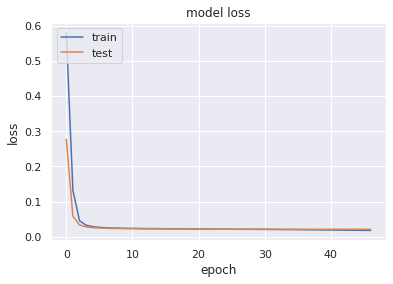

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.5790 - binary_crossentropy: 0.5787 - val_loss: 0.2867 - val_binary_crossentropy: 0.2858
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.1311 - binary_crossentropy: 0.1294 - val_loss: 0.0556 - val_binary_crossentropy: 0.0532
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0452 - binary_crossentropy: 0.0424 - val_loss: 0.0331 - val_binary_crossentropy: 0.0300
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0322 - binary_crossentropy: 0.0289 - val_loss: 0.0276 - val_binary_crossentropy: 0.0241
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0281 - binary_crossentropy: 0.0244 - val_loss: 0.0260 - val_binary_crossentropy: 0.0222
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0247 - val_binary_crossentropy: 0.0207
E

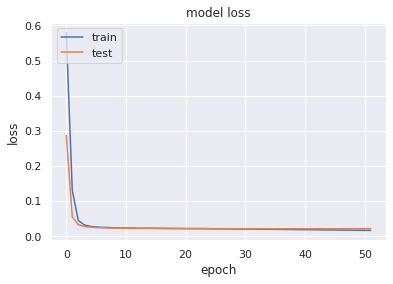

Our out of folds mean log loss score is 0.016414221858077484
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.5829 - binary_crossentropy: 0.5827 - val_loss: 0.2790 - val_binary_crossentropy: 0.2781
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1322 - binary_crossentropy: 0.1304 - val_loss: 0.0589 - val_binary_crossentropy: 0.0565
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0457 - binary_crossentropy: 0.0430 - val_loss: 0.0339 - val_binary_crossentropy: 0.0308
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0322 - binary_crossentropy: 0.0289 - val_loss: 0.0290 - val_binary_crossentropy: 0.0255
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0282 - binary_crossentropy: 0.0246 - val_loss: 0.0264 - val_binary_crossentropy: 0.0226
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0264 - binary_crossentropy: 

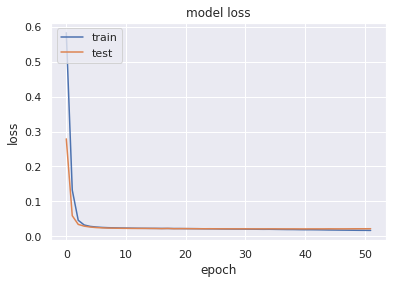

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.5797 - binary_crossentropy: 0.5794 - val_loss: 0.2765 - val_binary_crossentropy: 0.2756
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1303 - binary_crossentropy: 0.1285 - val_loss: 0.0582 - val_binary_crossentropy: 0.0559
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0448 - binary_crossentropy: 0.0420 - val_loss: 0.0341 - val_binary_crossentropy: 0.0310
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0320 - binary_crossentropy: 0.0286 - val_loss: 0.0282 - val_binary_crossentropy: 0.0247
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0280 - binary_crossentropy: 0.0243 - val_loss: 0.0259 - val_binary_crossentropy: 0.0221
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0248 - val_binary_crossentropy: 0.0208
Ep

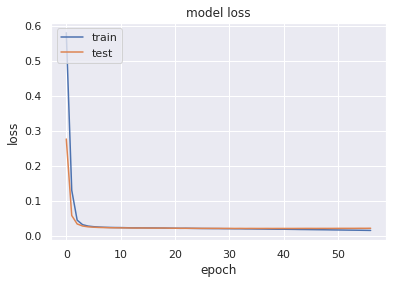

start fold 2
Epoch 1/80
160/160 [==============================] - 3s 18ms/step - loss: 0.5854 - binary_crossentropy: 0.5851 - val_loss: 0.2861 - val_binary_crossentropy: 0.2853
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.1329 - binary_crossentropy: 0.1311 - val_loss: 0.0567 - val_binary_crossentropy: 0.0543
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0448 - binary_crossentropy: 0.0420 - val_loss: 0.0347 - val_binary_crossentropy: 0.0316
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0323 - binary_crossentropy: 0.0290 - val_loss: 0.0285 - val_binary_crossentropy: 0.0249
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0282 - binary_crossentropy: 0.0245 - val_loss: 0.0257 - val_binary_crossentropy: 0.0218
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0249 - val_binary_crossentropy: 0.0209
Ep

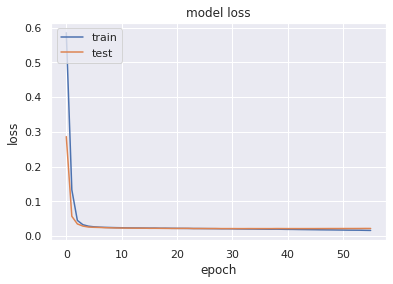

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5826 - binary_crossentropy: 0.5824 - val_loss: 0.2947 - val_binary_crossentropy: 0.2939
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1315 - binary_crossentropy: 0.1298 - val_loss: 0.0585 - val_binary_crossentropy: 0.0562
Epoch 3/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0449 - binary_crossentropy: 0.0421 - val_loss: 0.0332 - val_binary_crossentropy: 0.0300
Epoch 4/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0322 - binary_crossentropy: 0.0288 - val_loss: 0.0285 - val_binary_crossentropy: 0.0250
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0280 - binary_crossentropy: 0.0243 - val_loss: 0.0261 - val_binary_crossentropy: 0.0223
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0262 - binary_crossentropy: 0.0223 - val_loss: 0.0249 - val_binary_crossentropy: 0.0209
Ep

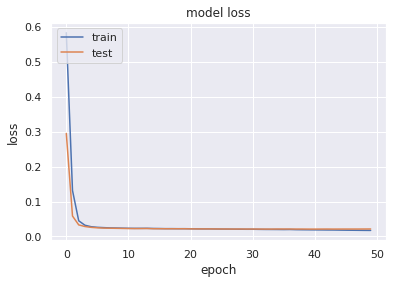

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.5835 - binary_crossentropy: 0.5832 - val_loss: 0.2783 - val_binary_crossentropy: 0.2774
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1315 - binary_crossentropy: 0.1298 - val_loss: 0.0595 - val_binary_crossentropy: 0.0571
Epoch 3/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0450 - binary_crossentropy: 0.0422 - val_loss: 0.0347 - val_binary_crossentropy: 0.0316
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0322 - binary_crossentropy: 0.0288 - val_loss: 0.0299 - val_binary_crossentropy: 0.0264
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0281 - binary_crossentropy: 0.0244 - val_loss: 0.0264 - val_binary_crossentropy: 0.0226
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0249 - val_binary_crossentropy: 0.0210
Ep

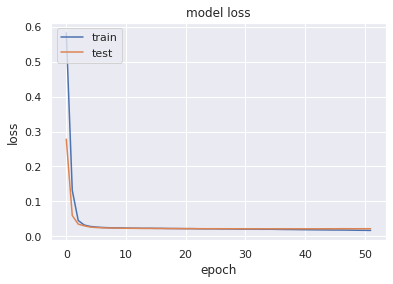

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5809 - binary_crossentropy: 0.5806 - val_loss: 0.2822 - val_binary_crossentropy: 0.2814
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.1320 - binary_crossentropy: 0.1302 - val_loss: 0.0570 - val_binary_crossentropy: 0.0546
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0448 - binary_crossentropy: 0.0420 - val_loss: 0.0332 - val_binary_crossentropy: 0.0300
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0321 - binary_crossentropy: 0.0288 - val_loss: 0.0282 - val_binary_crossentropy: 0.0247
Epoch 5/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0282 - binary_crossentropy: 0.0245 - val_loss: 0.0261 - val_binary_crossentropy: 0.0222
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0249 - val_binary_crossentropy: 0.0210
E

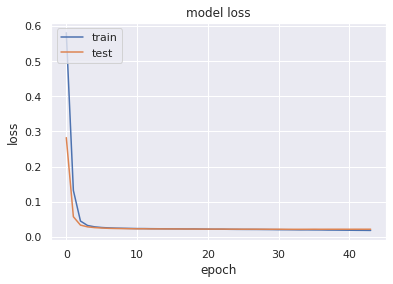

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5789 - binary_crossentropy: 0.5786 - val_loss: 0.2816 - val_binary_crossentropy: 0.2807
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1306 - binary_crossentropy: 0.1289 - val_loss: 0.0566 - val_binary_crossentropy: 0.0542
Epoch 3/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0446 - binary_crossentropy: 0.0418 - val_loss: 0.0332 - val_binary_crossentropy: 0.0301
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0320 - binary_crossentropy: 0.0286 - val_loss: 0.0300 - val_binary_crossentropy: 0.0266
Epoch 5/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0283 - binary_crossentropy: 0.0246 - val_loss: 0.0260 - val_binary_crossentropy: 0.0223
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0247 - val_binary_crossentropy: 0.0206
Ep

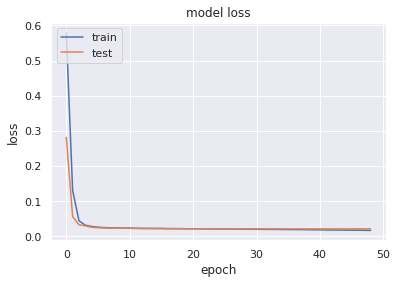

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.5766 - binary_crossentropy: 0.5763 - val_loss: 0.2808 - val_binary_crossentropy: 0.2799
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.1308 - binary_crossentropy: 0.1290 - val_loss: 0.0577 - val_binary_crossentropy: 0.0553
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0453 - binary_crossentropy: 0.0425 - val_loss: 0.0337 - val_binary_crossentropy: 0.0306
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0323 - binary_crossentropy: 0.0290 - val_loss: 0.0281 - val_binary_crossentropy: 0.0245
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0282 - binary_crossentropy: 0.0245 - val_loss: 0.0262 - val_binary_crossentropy: 0.0224
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0265 - binary_crossentropy: 0.0226 - val_loss: 0.0248 - val_binary_crossentropy: 0.0207
E

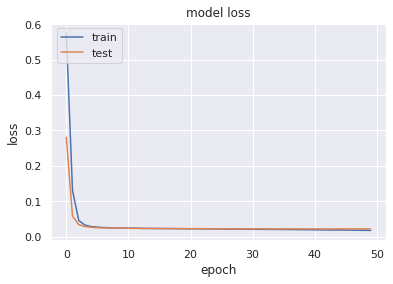

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5761 - binary_crossentropy: 0.5758 - val_loss: 0.2876 - val_binary_crossentropy: 0.2867
Epoch 2/80
160/160 [==============================] - 1s 7ms/step - loss: 0.1327 - binary_crossentropy: 0.1310 - val_loss: 0.0603 - val_binary_crossentropy: 0.0579
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0450 - binary_crossentropy: 0.0422 - val_loss: 0.0341 - val_binary_crossentropy: 0.0310
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0329 - binary_crossentropy: 0.0296 - val_loss: 0.0287 - val_binary_crossentropy: 0.0252
Epoch 5/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0282 - binary_crossentropy: 0.0245 - val_loss: 0.0261 - val_binary_crossentropy: 0.0223
Epoch 6/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0263 - binary_crossentropy: 0.0224 - val_loss: 0.0249 - val_binary_crossentropy: 0.0210
Ep

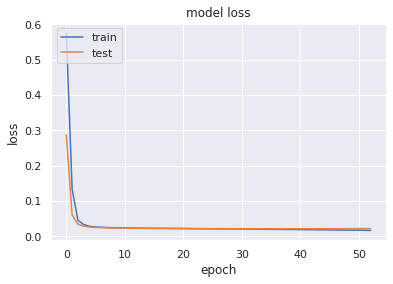

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.5802 - binary_crossentropy: 0.5799 - val_loss: 0.2892 - val_binary_crossentropy: 0.2883
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.1318 - binary_crossentropy: 0.1301 - val_loss: 0.0587 - val_binary_crossentropy: 0.0564
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0450 - binary_crossentropy: 0.0422 - val_loss: 0.0346 - val_binary_crossentropy: 0.0315
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0321 - binary_crossentropy: 0.0288 - val_loss: 0.0293 - val_binary_crossentropy: 0.0259
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0284 - binary_crossentropy: 0.0247 - val_loss: 0.0268 - val_binary_crossentropy: 0.0230
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0265 - binary_crossentropy: 0.0226 - val_loss: 0.0246 - val_binary_crossentropy: 0.0206
Ep

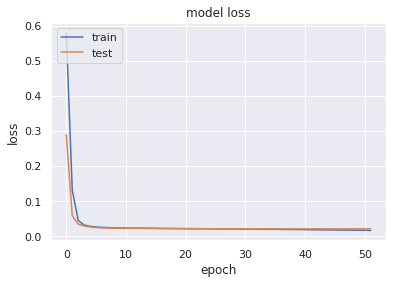

Our out of folds mean log loss score is 0.01644782423494588
CPU times: user 1h 42min 39s, sys: 9min 13s, total: 1h 51min 52s
Wall time: 1h 30min 8s


In [31]:
%%time
for SEED in SEEDS2:
    test_pred, oof_pred = train_and_evaluate(train, test, train_targets, features, start_predictors, SEED=SEED, MODEL = '2l')

start fold 0
Epoch 1/80
160/160 [==============================] - 2s 9ms/step - loss: 0.3342 - binary_crossentropy: 0.3331 - val_loss: 0.0430 - val_binary_crossentropy: 0.0404
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0250 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0227 - val_binary_crossentropy: 0.0186
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0220 - val_binary_crossentropy: 0.0176
Epoch 5/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0217 - val_binary_crossentropy: 0.0171
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0210 - binary_crossentropy: 0.0164 - val_loss: 0.0217 - val_binary_crossentropy: 0.0171
Epo

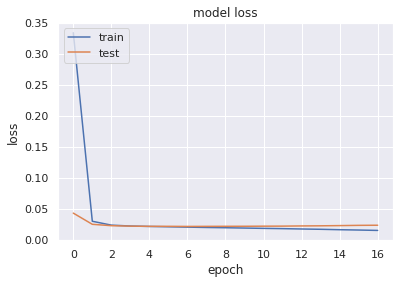

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3332 - binary_crossentropy: 0.3321 - val_loss: 0.0419 - val_binary_crossentropy: 0.0392
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0297 - binary_crossentropy: 0.0264 - val_loss: 0.0247 - val_binary_crossentropy: 0.0210
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0196 - val_loss: 0.0228 - val_binary_crossentropy: 0.0187
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0220 - val_binary_crossentropy: 0.0176
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0218 - val_binary_crossentropy: 0.0173
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0215 - val_binary_crossentropy: 0.0168
E

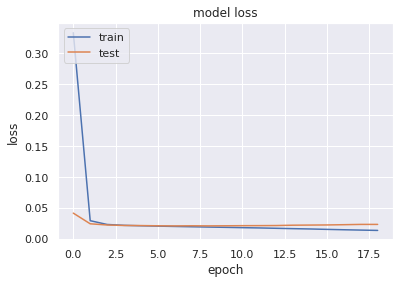

start fold 2
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.3345 - binary_crossentropy: 0.3334 - val_loss: 0.0413 - val_binary_crossentropy: 0.0386
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0254 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0230 - val_binary_crossentropy: 0.0189
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0180 - val_loss: 0.0224 - val_binary_crossentropy: 0.0181
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0219 - val_binary_crossentropy: 0.0173
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0216 - val_binary_crossentropy: 0.0169
Epo

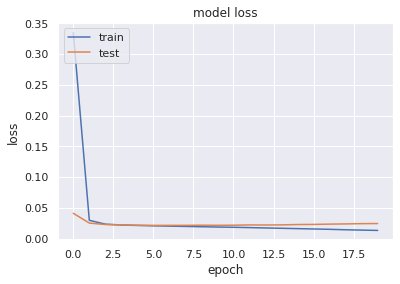

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 9ms/step - loss: 0.3340 - binary_crossentropy: 0.3329 - val_loss: 0.0406 - val_binary_crossentropy: 0.0379
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0297 - binary_crossentropy: 0.0264 - val_loss: 0.0249 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0196 - val_loss: 0.0231 - val_binary_crossentropy: 0.0190
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0221 - val_binary_crossentropy: 0.0178
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0220 - val_binary_crossentropy: 0.0175
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0218 - val_binary_crossentropy: 0.0172
Ep

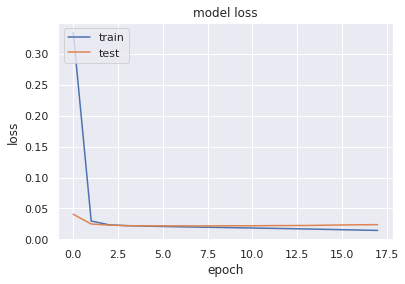

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 9ms/step - loss: 0.3351 - binary_crossentropy: 0.3340 - val_loss: 0.0412 - val_binary_crossentropy: 0.0385
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0301 - binary_crossentropy: 0.0268 - val_loss: 0.0255 - val_binary_crossentropy: 0.0218
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0198 - val_loss: 0.0229 - val_binary_crossentropy: 0.0188
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0220 - val_binary_crossentropy: 0.0176
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0222 - val_binary_crossentropy: 0.0178
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0215 - val_binary_crossentropy: 0.0170
Epo

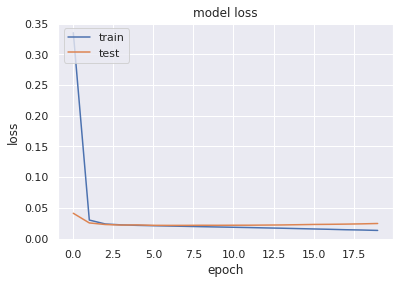

start fold 5
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.3336 - binary_crossentropy: 0.3325 - val_loss: 0.0410 - val_binary_crossentropy: 0.0383
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0248 - val_binary_crossentropy: 0.0211
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0227 - val_binary_crossentropy: 0.0186
Epoch 4/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0222 - binary_crossentropy: 0.0180 - val_loss: 0.0222 - val_binary_crossentropy: 0.0178
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0214 - binary_crossentropy: 0.0170 - val_loss: 0.0217 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0215 - val_binary_crossentropy: 0.0169
E

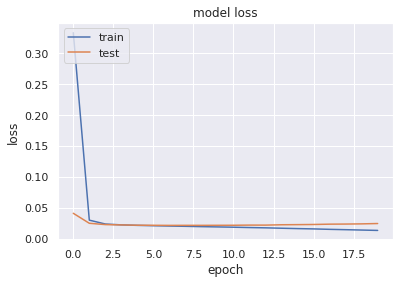

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 9ms/step - loss: 0.3326 - binary_crossentropy: 0.3315 - val_loss: 0.0433 - val_binary_crossentropy: 0.0406
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0253 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0229 - val_binary_crossentropy: 0.0188
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0218 - val_binary_crossentropy: 0.0175
Epoch 5/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0215 - binary_crossentropy: 0.0171 - val_loss: 0.0216 - val_binary_crossentropy: 0.0169
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0213 - val_binary_crossentropy: 0.0166
Epo

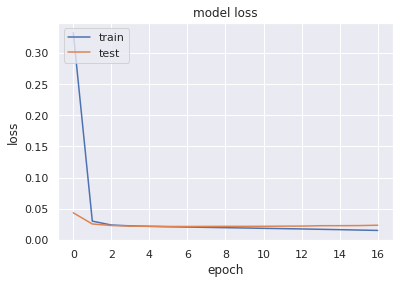

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.3344 - binary_crossentropy: 0.3333 - val_loss: 0.0422 - val_binary_crossentropy: 0.0395
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0255 - val_binary_crossentropy: 0.0218
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0231 - val_binary_crossentropy: 0.0191
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0221 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0221 - val_binary_crossentropy: 0.0175
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0218 - val_binary_crossentropy: 0.0171
E

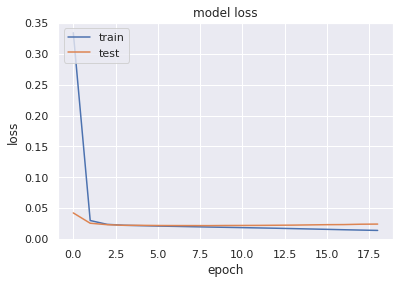

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3332 - binary_crossentropy: 0.3321 - val_loss: 0.0397 - val_binary_crossentropy: 0.0369
Epoch 2/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0253 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0228 - val_binary_crossentropy: 0.0188
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0221 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0218 - val_binary_crossentropy: 0.0173
Epoch 6/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0217 - val_binary_crossentropy: 0.0170
Ep

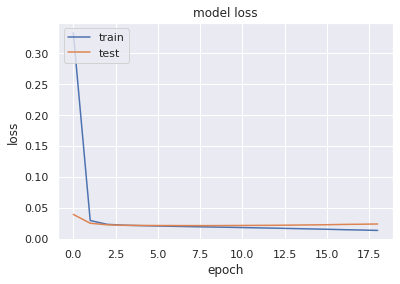

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 9ms/step - loss: 0.3360 - binary_crossentropy: 0.3349 - val_loss: 0.0452 - val_binary_crossentropy: 0.0426
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0300 - binary_crossentropy: 0.0267 - val_loss: 0.0254 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0232 - val_binary_crossentropy: 0.0191
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0223 - val_binary_crossentropy: 0.0179
Epoch 5/80
160/160 [==============================] - 2s 14ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0218 - val_binary_crossentropy: 0.0171
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0216 - val_binary_crossentropy: 0.0169


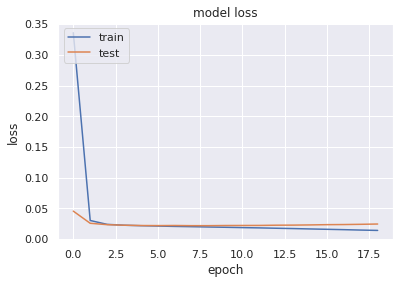

Our out of folds mean log loss score is 0.018483410998601298
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3339 - binary_crossentropy: 0.3328 - val_loss: 0.0399 - val_binary_crossentropy: 0.0372
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0250 - val_binary_crossentropy: 0.0213
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0227 - val_binary_crossentropy: 0.0186
Epoch 4/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0219 - val_binary_crossentropy: 0.0175
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0216 - binary_crossentropy: 0.0171 - val_loss: 0.0215 - val_binary_crossentropy: 0.0170
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0210 - binary_crossentropy: 0

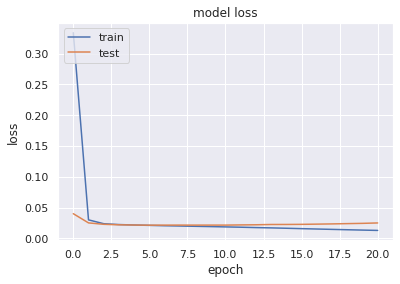

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.3341 - binary_crossentropy: 0.3330 - val_loss: 0.0423 - val_binary_crossentropy: 0.0396
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0254 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0229 - val_binary_crossentropy: 0.0188
Epoch 4/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0222 - val_binary_crossentropy: 0.0178
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0219 - val_binary_crossentropy: 0.0173
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0217 - val_binary_crossentropy: 0.0172


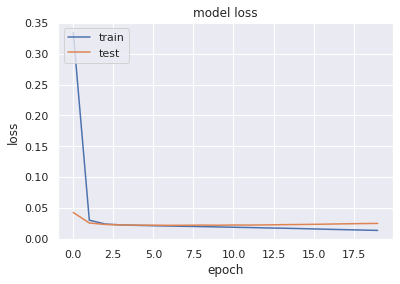

start fold 2
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.3322 - binary_crossentropy: 0.3311 - val_loss: 0.0391 - val_binary_crossentropy: 0.0363
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0296 - binary_crossentropy: 0.0263 - val_loss: 0.0247 - val_binary_crossentropy: 0.0209
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0235 - binary_crossentropy: 0.0196 - val_loss: 0.0231 - val_binary_crossentropy: 0.0191
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0221 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0214 - binary_crossentropy: 0.0170 - val_loss: 0.0219 - val_binary_crossentropy: 0.0175
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0216 - val_binary_crossentropy: 0.0169
Epo

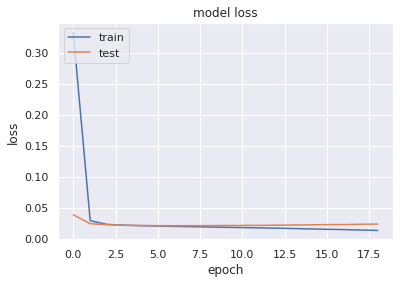

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3347 - binary_crossentropy: 0.3336 - val_loss: 0.0421 - val_binary_crossentropy: 0.0394
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0253 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0236 - binary_crossentropy: 0.0196 - val_loss: 0.0231 - val_binary_crossentropy: 0.0191
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0221 - val_binary_crossentropy: 0.0176
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0215 - binary_crossentropy: 0.0171 - val_loss: 0.0219 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0217 - val_binary_crossentropy: 0.0171


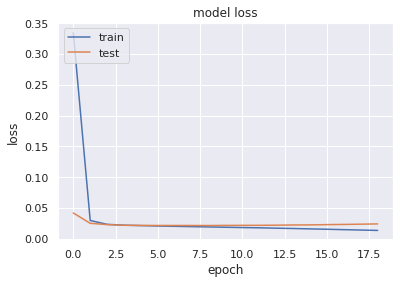

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3362 - binary_crossentropy: 0.3351 - val_loss: 0.0434 - val_binary_crossentropy: 0.0408
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0253 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0232 - val_binary_crossentropy: 0.0191
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0221 - val_binary_crossentropy: 0.0176
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0216 - val_binary_crossentropy: 0.0171
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0215 - val_binary_crossentropy: 0.0168
Ep

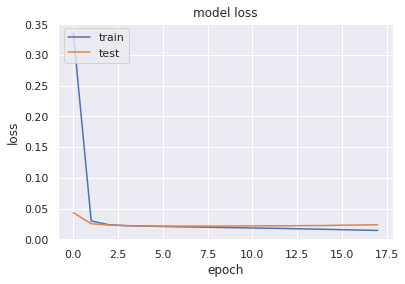

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.3331 - binary_crossentropy: 0.3320 - val_loss: 0.0463 - val_binary_crossentropy: 0.0437
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0253 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0229 - val_binary_crossentropy: 0.0187
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0222 - binary_crossentropy: 0.0180 - val_loss: 0.0224 - val_binary_crossentropy: 0.0181
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0220 - val_binary_crossentropy: 0.0175
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0218 - val_binary_crossentropy: 0.0171
E

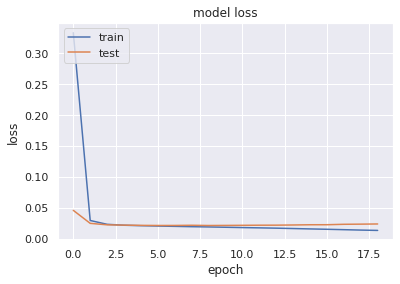

start fold 6
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.3338 - binary_crossentropy: 0.3327 - val_loss: 0.0410 - val_binary_crossentropy: 0.0382
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0254 - val_binary_crossentropy: 0.0218
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0227 - val_binary_crossentropy: 0.0186
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0222 - val_binary_crossentropy: 0.0179
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0217 - val_binary_crossentropy: 0.0171
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0216 - val_binary_crossentropy: 0.0169
Epo

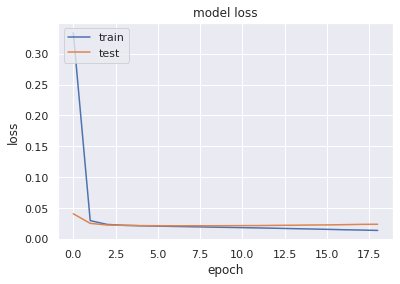

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3340 - binary_crossentropy: 0.3329 - val_loss: 0.0381 - val_binary_crossentropy: 0.0352
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0300 - binary_crossentropy: 0.0267 - val_loss: 0.0254 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0228 - val_binary_crossentropy: 0.0187
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0221 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0219 - val_binary_crossentropy: 0.0173
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0216 - val_binary_crossentropy: 0.0168


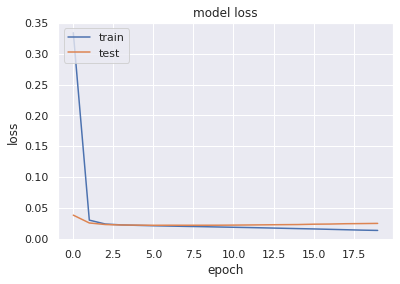

start fold 8
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.3346 - binary_crossentropy: 0.3335 - val_loss: 0.0429 - val_binary_crossentropy: 0.0402
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0297 - binary_crossentropy: 0.0264 - val_loss: 0.0251 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0196 - val_loss: 0.0228 - val_binary_crossentropy: 0.0186
Epoch 4/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0222 - val_binary_crossentropy: 0.0178
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0219 - val_binary_crossentropy: 0.0175
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0210 - binary_crossentropy: 0.0164 - val_loss: 0.0219 - val_binary_crossentropy: 0.0172
Epo

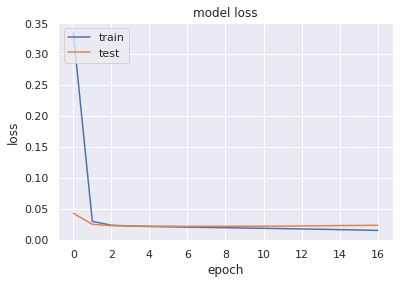

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3343 - binary_crossentropy: 0.3332 - val_loss: 0.0434 - val_binary_crossentropy: 0.0407
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0252 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0228 - val_binary_crossentropy: 0.0187
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0219 - val_binary_crossentropy: 0.0175
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0217 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0215 - val_binary_crossentropy: 0.0168
E

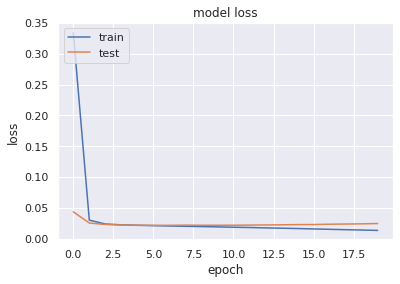

Our out of folds mean log loss score is 0.018683777026237955
start fold 0
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.3317 - binary_crossentropy: 0.3306 - val_loss: 0.0434 - val_binary_crossentropy: 0.0408
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0251 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0228 - val_binary_crossentropy: 0.0187
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0180 - val_loss: 0.0221 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0217 - val_binary_crossentropy: 0.0171
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0210 - binary_crossentropy: 0.

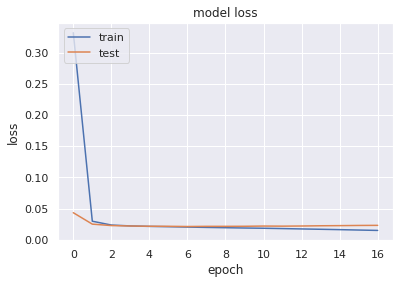

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3353 - binary_crossentropy: 0.3342 - val_loss: 0.0415 - val_binary_crossentropy: 0.0388
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0300 - binary_crossentropy: 0.0268 - val_loss: 0.0254 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0238 - binary_crossentropy: 0.0198 - val_loss: 0.0231 - val_binary_crossentropy: 0.0191
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0221 - val_binary_crossentropy: 0.0178
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0218 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0216 - val_binary_crossentropy: 0.0169
E

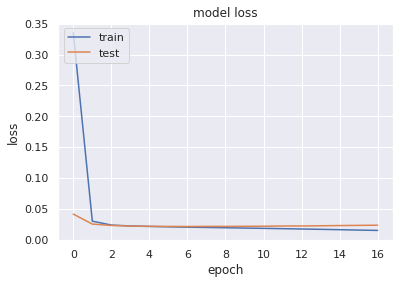

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3338 - binary_crossentropy: 0.3327 - val_loss: 0.0413 - val_binary_crossentropy: 0.0386
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0265 - val_loss: 0.0255 - val_binary_crossentropy: 0.0219
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0228 - val_binary_crossentropy: 0.0187
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0180 - val_loss: 0.0221 - val_binary_crossentropy: 0.0178
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0219 - val_binary_crossentropy: 0.0173
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0216 - val_binary_crossentropy: 0.0169


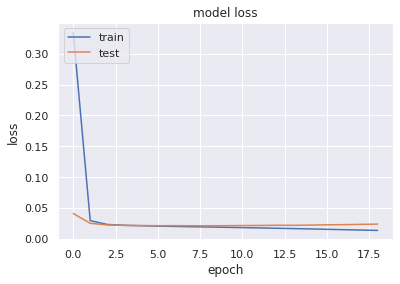

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.3321 - binary_crossentropy: 0.3310 - val_loss: 0.0454 - val_binary_crossentropy: 0.0428
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0254 - val_binary_crossentropy: 0.0218
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0236 - binary_crossentropy: 0.0196 - val_loss: 0.0230 - val_binary_crossentropy: 0.0189
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0222 - val_binary_crossentropy: 0.0178
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0219 - val_binary_crossentropy: 0.0175
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0216 - val_binary_crossentropy: 0.0169

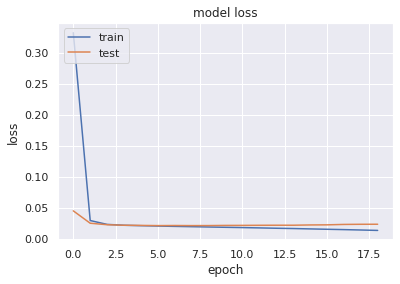

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 9ms/step - loss: 0.3321 - binary_crossentropy: 0.3310 - val_loss: 0.0411 - val_binary_crossentropy: 0.0384
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0251 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0232 - val_binary_crossentropy: 0.0192
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0221 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0219 - val_binary_crossentropy: 0.0173
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0216 - val_binary_crossentropy: 0.0169
Ep

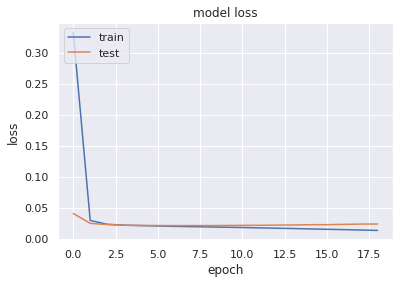

start fold 5
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.3356 - binary_crossentropy: 0.3345 - val_loss: 0.0411 - val_binary_crossentropy: 0.0384
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0300 - binary_crossentropy: 0.0267 - val_loss: 0.0253 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0228 - val_binary_crossentropy: 0.0187
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0180 - val_loss: 0.0220 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0217 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0215 - val_binary_crossentropy: 0.0168
E

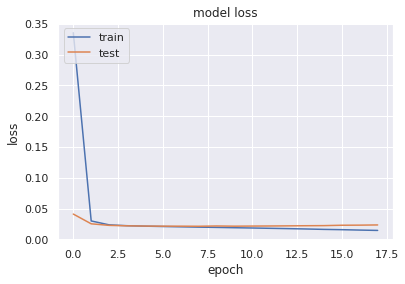

start fold 6
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.3330 - binary_crossentropy: 0.3319 - val_loss: 0.0425 - val_binary_crossentropy: 0.0398
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0300 - binary_crossentropy: 0.0267 - val_loss: 0.0251 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0230 - val_binary_crossentropy: 0.0189
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0220 - val_binary_crossentropy: 0.0176
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0171 - val_loss: 0.0217 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0218 - val_binary_crossentropy: 0.0171
Epo

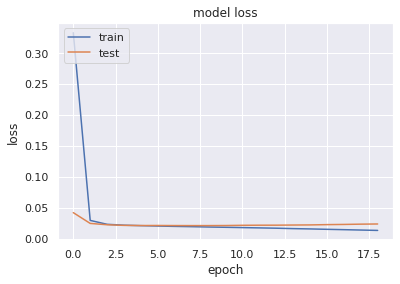

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3344 - binary_crossentropy: 0.3333 - val_loss: 0.0416 - val_binary_crossentropy: 0.0389
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0300 - binary_crossentropy: 0.0267 - val_loss: 0.0251 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0228 - val_binary_crossentropy: 0.0187
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0223 - val_binary_crossentropy: 0.0179
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0219 - val_binary_crossentropy: 0.0174
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0218 - val_binary_crossentropy: 0.0171

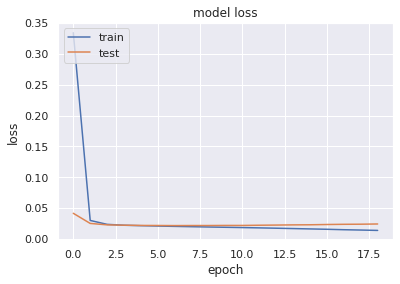

start fold 8
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.3349 - binary_crossentropy: 0.3338 - val_loss: 0.0430 - val_binary_crossentropy: 0.0403
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0300 - binary_crossentropy: 0.0267 - val_loss: 0.0253 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0232 - val_binary_crossentropy: 0.0191
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0221 - val_binary_crossentropy: 0.0176
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0216 - binary_crossentropy: 0.0171 - val_loss: 0.0217 - val_binary_crossentropy: 0.0171
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0210 - binary_crossentropy: 0.0165 - val_loss: 0.0217 - val_binary_crossentropy: 0.0172
Epo

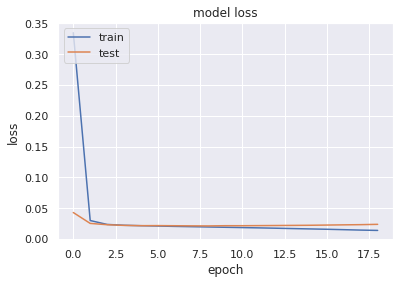

start fold 9
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.3332 - binary_crossentropy: 0.3321 - val_loss: 0.0405 - val_binary_crossentropy: 0.0378
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0249 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0236 - binary_crossentropy: 0.0196 - val_loss: 0.0225 - val_binary_crossentropy: 0.0185
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0218 - val_binary_crossentropy: 0.0174
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0215 - val_binary_crossentropy: 0.0169
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0209 - binary_crossentropy: 0.0164 - val_loss: 0.0214 - val_binary_crossentropy: 0.0167
E

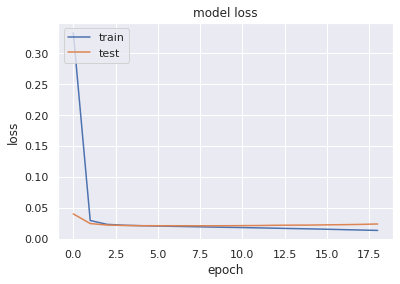

Our out of folds mean log loss score is 0.018358442961966585
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3347 - binary_crossentropy: 0.3336 - val_loss: 0.0441 - val_binary_crossentropy: 0.0415
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0250 - val_binary_crossentropy: 0.0213
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0227 - val_binary_crossentropy: 0.0186
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0220 - val_binary_crossentropy: 0.0176
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0171 - val_loss: 0.0217 - val_binary_crossentropy: 0.0171
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0210 - binary_crossentropy: 0

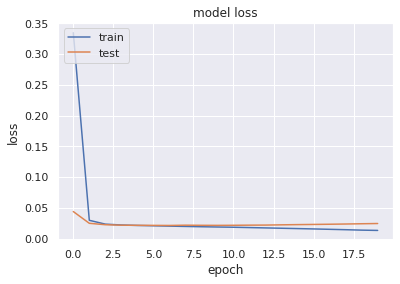

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 9ms/step - loss: 0.3352 - binary_crossentropy: 0.3341 - val_loss: 0.0425 - val_binary_crossentropy: 0.0398
Epoch 2/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0252 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0228 - val_binary_crossentropy: 0.0187
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0223 - val_binary_crossentropy: 0.0180
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0216 - val_binary_crossentropy: 0.0170
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0208 - binary_crossentropy: 0.0162 - val_loss: 0.0217 - val_binary_crossentropy: 0.0171
Epo

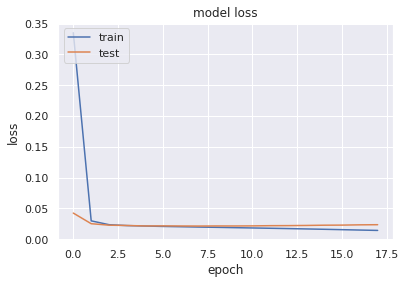

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3332 - binary_crossentropy: 0.3321 - val_loss: 0.0422 - val_binary_crossentropy: 0.0395
Epoch 2/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0252 - val_binary_crossentropy: 0.0215
Epoch 3/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0231 - val_binary_crossentropy: 0.0190
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0222 - binary_crossentropy: 0.0180 - val_loss: 0.0220 - val_binary_crossentropy: 0.0176
Epoch 5/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0218 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0218 - val_binary_crossentropy: 0.01

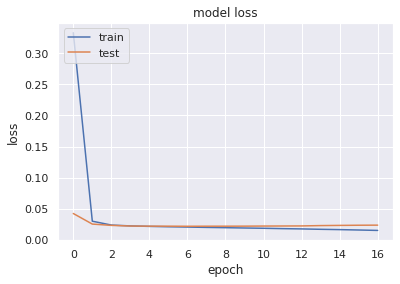

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.3350 - binary_crossentropy: 0.3339 - val_loss: 0.0420 - val_binary_crossentropy: 0.0393
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0300 - binary_crossentropy: 0.0267 - val_loss: 0.0252 - val_binary_crossentropy: 0.0215
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0237 - binary_crossentropy: 0.0198 - val_loss: 0.0229 - val_binary_crossentropy: 0.0188
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0223 - binary_crossentropy: 0.0181 - val_loss: 0.0221 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0215 - binary_crossentropy: 0.0171 - val_loss: 0.0218 - val_binary_crossentropy: 0.0173
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0210 - binary_crossentropy: 0.0164 - val_loss: 0.0215 - val_binary_crossentropy: 0.01

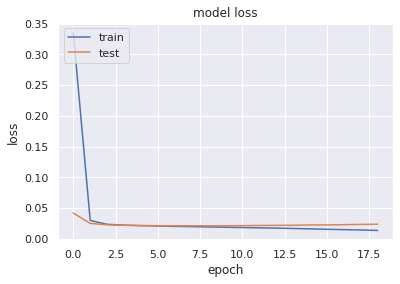

start fold 4
Epoch 1/80
160/160 [==============================] - 3s 20ms/step - loss: 0.3345 - binary_crossentropy: 0.3334 - val_loss: 0.0402 - val_binary_crossentropy: 0.0374
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0253 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 2s 15ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0229 - val_binary_crossentropy: 0.0188
Epoch 4/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0222 - val_binary_crossentropy: 0.0179
Epoch 5/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0215 - binary_crossentropy: 0.0171 - val_loss: 0.0219 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0217 - val_binary_crossentropy: 0.01

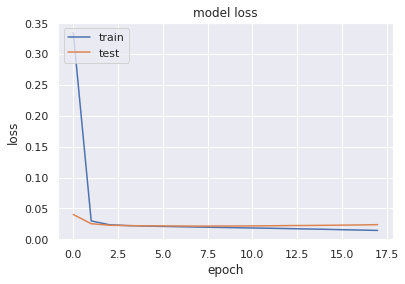

start fold 5
Epoch 1/80
160/160 [==============================] - 3s 17ms/step - loss: 0.3362 - binary_crossentropy: 0.3351 - val_loss: 0.0415 - val_binary_crossentropy: 0.0388
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0300 - binary_crossentropy: 0.0267 - val_loss: 0.0252 - val_binary_crossentropy: 0.0215
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0227 - val_binary_crossentropy: 0.0185
Epoch 4/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0222 - val_binary_crossentropy: 0.0178
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0219 - val_binary_crossentropy: 0.0173
Epoch 6/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0218 - val_binary_crossentropy: 0.01

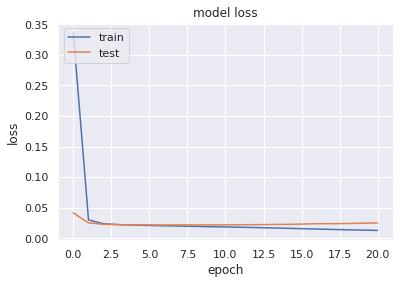

start fold 6
Epoch 1/80
160/160 [==============================] - 3s 17ms/step - loss: 0.3335 - binary_crossentropy: 0.3324 - val_loss: 0.0409 - val_binary_crossentropy: 0.0381
Epoch 2/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0252 - val_binary_crossentropy: 0.0215
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0229 - val_binary_crossentropy: 0.0187
Epoch 4/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0222 - binary_crossentropy: 0.0180 - val_loss: 0.0222 - val_binary_crossentropy: 0.0178
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0215 - binary_crossentropy: 0.0171 - val_loss: 0.0217 - val_binary_crossentropy: 0.0173
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0214 - val_binary_crossentropy: 0.01

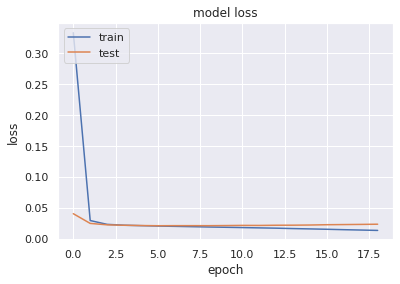

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3340 - binary_crossentropy: 0.3330 - val_loss: 0.0432 - val_binary_crossentropy: 0.0406
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0253 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0228 - val_binary_crossentropy: 0.0187
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0222 - val_binary_crossentropy: 0.0178
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0216 - binary_crossentropy: 0.0171 - val_loss: 0.0220 - val_binary_crossentropy: 0.0175
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0210 - binary_crossentropy: 0.0164 - val_loss: 0.0216 - val_binary_crossentropy: 0.0170
E

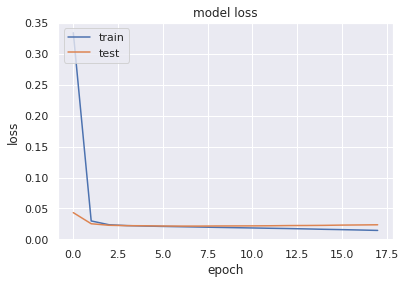

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3338 - binary_crossentropy: 0.3327 - val_loss: 0.0423 - val_binary_crossentropy: 0.0396
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0251 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0226 - val_binary_crossentropy: 0.0185
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0227 - val_binary_crossentropy: 0.0183
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0214 - binary_crossentropy: 0.0170 - val_loss: 0.0217 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0215 - val_binary_crossentropy: 0.0169
Ep

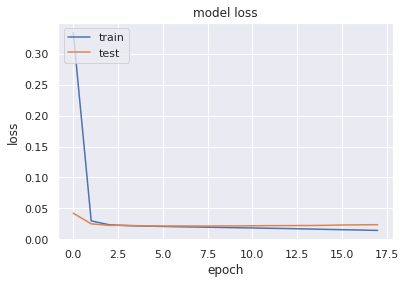

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.3354 - binary_crossentropy: 0.3343 - val_loss: 0.0396 - val_binary_crossentropy: 0.0368
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0300 - binary_crossentropy: 0.0267 - val_loss: 0.0255 - val_binary_crossentropy: 0.0219
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0231 - val_binary_crossentropy: 0.0190
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0221 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0171 - val_loss: 0.0217 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0215 - val_binary_crossentropy: 0.0168
Ep

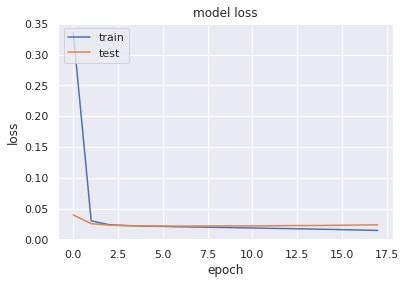

Our out of folds mean log loss score is 0.01844580479273813
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3344 - binary_crossentropy: 0.3333 - val_loss: 0.0442 - val_binary_crossentropy: 0.0416
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0251 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0236 - binary_crossentropy: 0.0196 - val_loss: 0.0227 - val_binary_crossentropy: 0.0186
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0221 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0214 - binary_crossentropy: 0.0170 - val_loss: 0.0220 - val_binary_crossentropy: 0.0174
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.

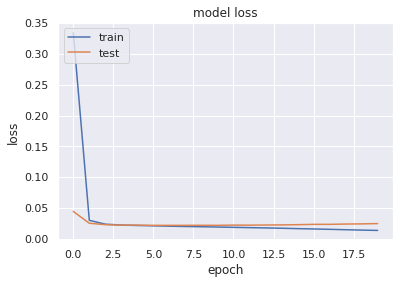

start fold 1
Epoch 1/80
160/160 [==============================] - 1s 9ms/step - loss: 0.3375 - binary_crossentropy: 0.3365 - val_loss: 0.0428 - val_binary_crossentropy: 0.0402
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0300 - binary_crossentropy: 0.0267 - val_loss: 0.0253 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0229 - val_binary_crossentropy: 0.0188
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0223 - val_binary_crossentropy: 0.0179
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0220 - val_binary_crossentropy: 0.0175
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0208 - binary_crossentropy: 0.0162 - val_loss: 0.0219 - val_binary_crossentropy: 0.0172
Epo

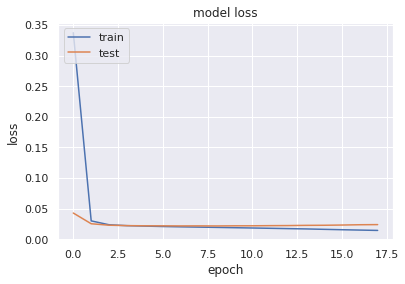

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 9ms/step - loss: 0.3346 - binary_crossentropy: 0.3335 - val_loss: 0.0425 - val_binary_crossentropy: 0.0398
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0251 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0196 - val_loss: 0.0228 - val_binary_crossentropy: 0.0187
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0180 - val_loss: 0.0221 - val_binary_crossentropy: 0.0176
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0214 - binary_crossentropy: 0.0170 - val_loss: 0.0219 - val_binary_crossentropy: 0.0174
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0216 - val_binary_crossentropy: 0.0169
Epo

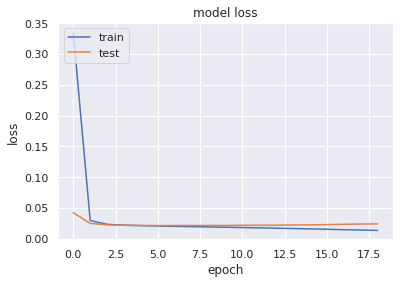

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3342 - binary_crossentropy: 0.3331 - val_loss: 0.0422 - val_binary_crossentropy: 0.0395
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0251 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0229 - val_binary_crossentropy: 0.0188
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0221 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0218 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0218 - val_binary_crossentropy: 0.0172
Ep

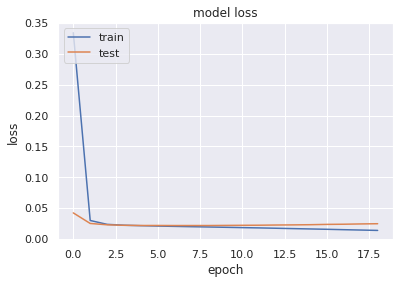

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 15ms/step - loss: 0.3323 - binary_crossentropy: 0.3312 - val_loss: 0.0417 - val_binary_crossentropy: 0.0390
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0250 - val_binary_crossentropy: 0.0213
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0229 - val_binary_crossentropy: 0.0188
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0221 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 1s 7ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0218 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0164 - val_loss: 0.0216 - val_binary_crossentropy: 0.0170
Ep

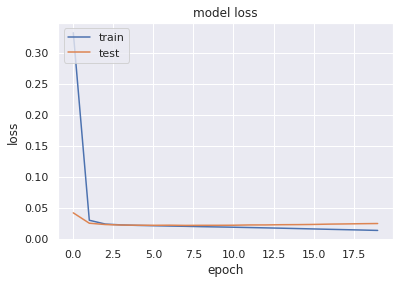

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.3331 - binary_crossentropy: 0.3320 - val_loss: 0.0443 - val_binary_crossentropy: 0.0417
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0250 - val_binary_crossentropy: 0.0213
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0227 - val_binary_crossentropy: 0.0186
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0220 - val_binary_crossentropy: 0.0175
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0171 - val_loss: 0.0216 - val_binary_crossentropy: 0.0171
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0210 - binary_crossentropy: 0.0164 - val_loss: 0.0214 - val_binary_crossentropy: 0.0167
Ep

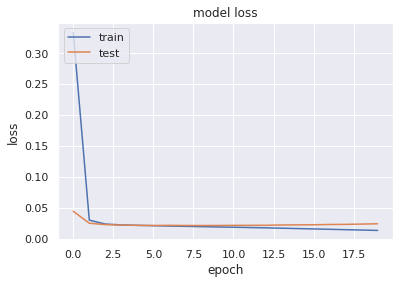

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3343 - binary_crossentropy: 0.3332 - val_loss: 0.0394 - val_binary_crossentropy: 0.0366
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0250 - val_binary_crossentropy: 0.0213
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0227 - val_binary_crossentropy: 0.0187
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0222 - val_binary_crossentropy: 0.0179
Epoch 5/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0214 - binary_crossentropy: 0.0170 - val_loss: 0.0219 - val_binary_crossentropy: 0.0173
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0216 - val_binary_crossentropy: 0.0170

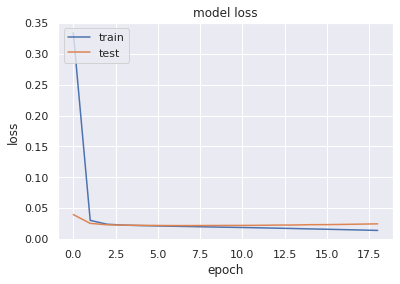

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3329 - binary_crossentropy: 0.3318 - val_loss: 0.0410 - val_binary_crossentropy: 0.0383
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0298 - binary_crossentropy: 0.0264 - val_loss: 0.0249 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0196 - val_loss: 0.0227 - val_binary_crossentropy: 0.0186
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0220 - val_binary_crossentropy: 0.0176
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0218 - val_binary_crossentropy: 0.0173
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0214 - val_binary_crossentropy: 0.0167
Ep

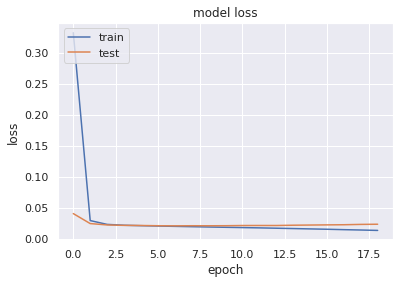

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.3339 - binary_crossentropy: 0.3328 - val_loss: 0.0426 - val_binary_crossentropy: 0.0399
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0254 - val_binary_crossentropy: 0.0217
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0230 - val_binary_crossentropy: 0.0189
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0221 - val_binary_crossentropy: 0.0176
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0220 - val_binary_crossentropy: 0.0175
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0219 - val_binary_crossentropy: 0.0173


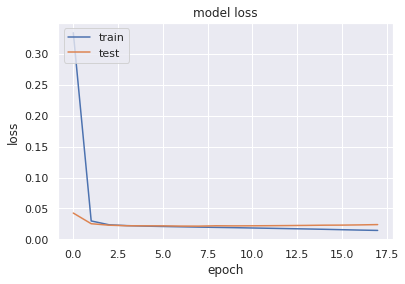

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 9ms/step - loss: 0.3342 - binary_crossentropy: 0.3331 - val_loss: 0.0377 - val_binary_crossentropy: 0.0348
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0251 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0229 - val_binary_crossentropy: 0.0189
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0220 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0214 - binary_crossentropy: 0.0170 - val_loss: 0.0217 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0215 - val_binary_crossentropy: 0.0168
Ep

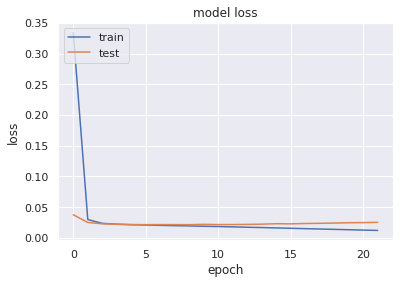

Our out of folds mean log loss score is 0.018764787675035175
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3345 - binary_crossentropy: 0.3335 - val_loss: 0.0374 - val_binary_crossentropy: 0.0345
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0300 - binary_crossentropy: 0.0267 - val_loss: 0.0258 - val_binary_crossentropy: 0.0222
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0229 - val_binary_crossentropy: 0.0188
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0221 - val_binary_crossentropy: 0.0178
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0216 - binary_crossentropy: 0.0171 - val_loss: 0.0219 - val_binary_crossentropy: 0.0173
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0210 - binary_crossentropy: 

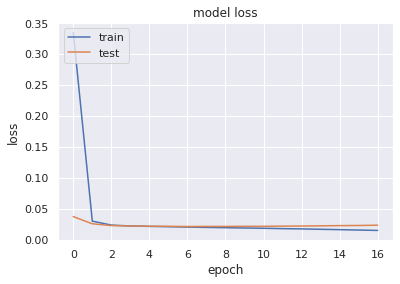

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3334 - binary_crossentropy: 0.3324 - val_loss: 0.0420 - val_binary_crossentropy: 0.0393
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0252 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0196 - val_loss: 0.0231 - val_binary_crossentropy: 0.0189
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0223 - val_binary_crossentropy: 0.0179
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0221 - val_binary_crossentropy: 0.0176
Epoch 6/80
160/160 [==============================] - 2s 9ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0218 - val_binary_crossentropy: 0.0171
E

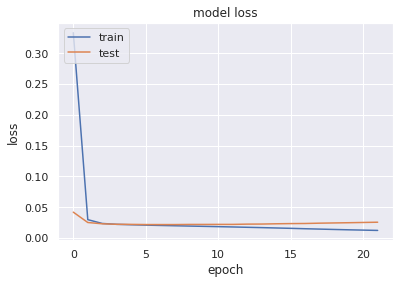

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3346 - binary_crossentropy: 0.3335 - val_loss: 0.0414 - val_binary_crossentropy: 0.0387
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0253 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0196 - val_loss: 0.0229 - val_binary_crossentropy: 0.0188
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0180 - val_loss: 0.0221 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0218 - val_binary_crossentropy: 0.0173
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0210 - binary_crossentropy: 0.0164 - val_loss: 0.0219 - val_binary_crossentropy: 0.0173
E

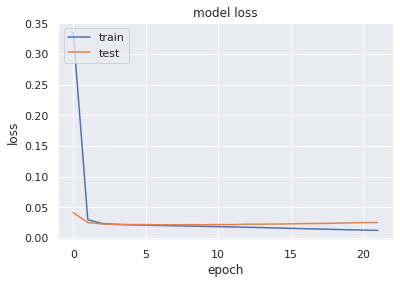

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 9ms/step - loss: 0.3333 - binary_crossentropy: 0.3322 - val_loss: 0.0403 - val_binary_crossentropy: 0.0376
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0297 - binary_crossentropy: 0.0264 - val_loss: 0.0251 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0196 - val_loss: 0.0231 - val_binary_crossentropy: 0.0189
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0220 - val_binary_crossentropy: 0.0176
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0214 - binary_crossentropy: 0.0169 - val_loss: 0.0218 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0208 - binary_crossentropy: 0.0162 - val_loss: 0.0217 - val_binary_crossentropy: 0.0170
Ep

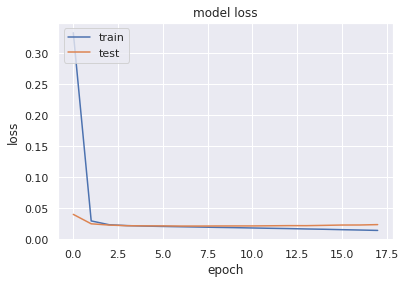

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3340 - binary_crossentropy: 0.3329 - val_loss: 0.0399 - val_binary_crossentropy: 0.0372
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0250 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0226 - val_binary_crossentropy: 0.0185
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0220 - val_binary_crossentropy: 0.0176
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0171 - val_loss: 0.0216 - val_binary_crossentropy: 0.0171
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0216 - val_binary_crossentropy: 0.0169
E

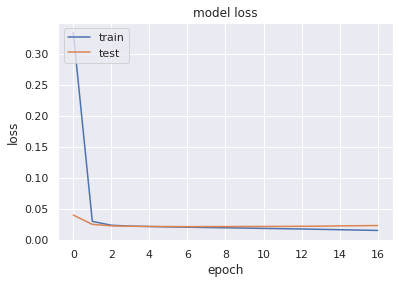

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3352 - binary_crossentropy: 0.3341 - val_loss: 0.0414 - val_binary_crossentropy: 0.0387
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0300 - binary_crossentropy: 0.0267 - val_loss: 0.0259 - val_binary_crossentropy: 0.0222
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0231 - val_binary_crossentropy: 0.0190
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0223 - val_binary_crossentropy: 0.0178
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0221 - val_binary_crossentropy: 0.0175
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0220 - val_binary_crossentropy: 0.0173


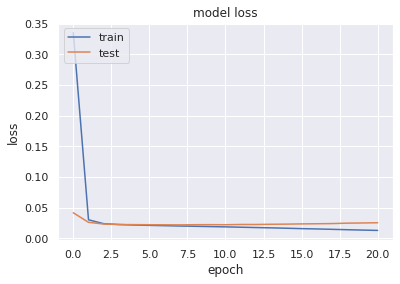

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 11ms/step - loss: 0.3335 - binary_crossentropy: 0.3324 - val_loss: 0.0433 - val_binary_crossentropy: 0.0407
Epoch 2/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0252 - val_binary_crossentropy: 0.0215
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0227 - val_binary_crossentropy: 0.0185
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0180 - val_loss: 0.0219 - val_binary_crossentropy: 0.0176
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0171 - val_loss: 0.0216 - val_binary_crossentropy: 0.0171
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0164 - val_loss: 0.0217 - val_binary_crossentropy: 0.0171
E

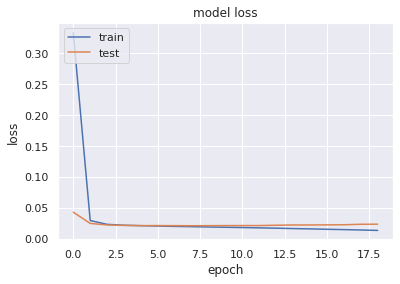

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3342 - binary_crossentropy: 0.3331 - val_loss: 0.0409 - val_binary_crossentropy: 0.0381
Epoch 2/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0300 - binary_crossentropy: 0.0267 - val_loss: 0.0256 - val_binary_crossentropy: 0.0219
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0198 - val_loss: 0.0231 - val_binary_crossentropy: 0.0190
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0221 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0218 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0218 - val_binary_crossentropy: 0.0172
E

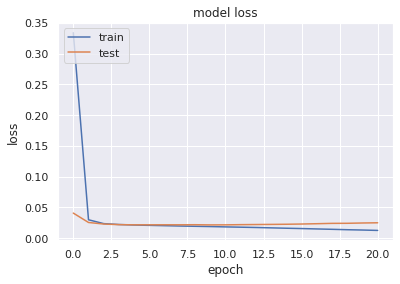

start fold 8
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3350 - binary_crossentropy: 0.3339 - val_loss: 0.0447 - val_binary_crossentropy: 0.0421
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0300 - binary_crossentropy: 0.0267 - val_loss: 0.0253 - val_binary_crossentropy: 0.0216
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0230 - val_binary_crossentropy: 0.0189
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0222 - val_binary_crossentropy: 0.0179
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0219 - val_binary_crossentropy: 0.0174
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0210 - binary_crossentropy: 0.0164 - val_loss: 0.0217 - val_binary_crossentropy: 0.0170
Ep

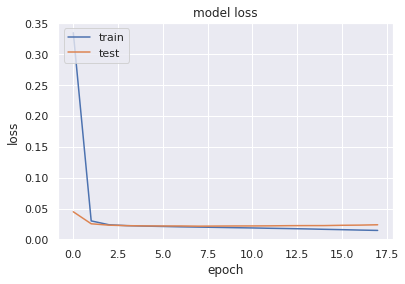

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3344 - binary_crossentropy: 0.3333 - val_loss: 0.0413 - val_binary_crossentropy: 0.0386
Epoch 2/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0300 - binary_crossentropy: 0.0267 - val_loss: 0.0252 - val_binary_crossentropy: 0.0215
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0225 - val_binary_crossentropy: 0.0183
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0180 - val_loss: 0.0220 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0215 - val_binary_crossentropy: 0.0170
Epoch 6/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0213 - val_binary_crossentropy: 0.0166


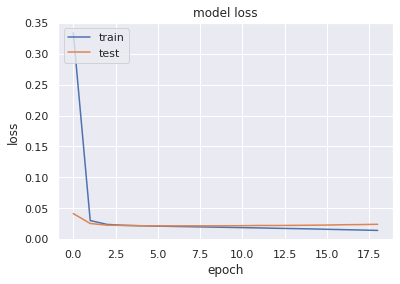

Our out of folds mean log loss score is 0.018739540009148663
start fold 0
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3325 - binary_crossentropy: 0.3314 - val_loss: 0.0400 - val_binary_crossentropy: 0.0372
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0297 - binary_crossentropy: 0.0264 - val_loss: 0.0252 - val_binary_crossentropy: 0.0215
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0235 - binary_crossentropy: 0.0196 - val_loss: 0.0230 - val_binary_crossentropy: 0.0189
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0179 - val_loss: 0.0221 - val_binary_crossentropy: 0.0178
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0217 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0

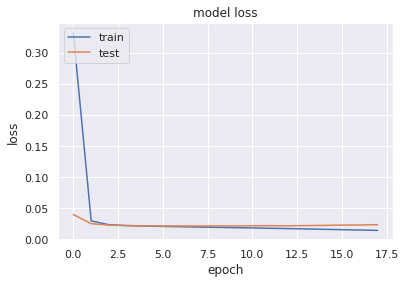

start fold 1
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3344 - binary_crossentropy: 0.3333 - val_loss: 0.0442 - val_binary_crossentropy: 0.0415
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0251 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0234 - val_binary_crossentropy: 0.0193
Epoch 4/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0222 - binary_crossentropy: 0.0180 - val_loss: 0.0223 - val_binary_crossentropy: 0.0180
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0220 - val_binary_crossentropy: 0.0175
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0218 - val_binary_crossentropy: 0.0171

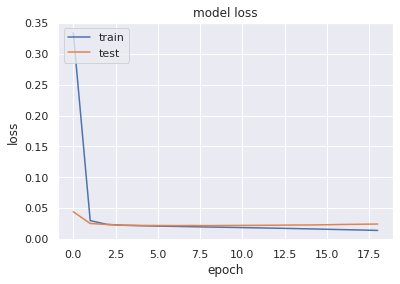

start fold 2
Epoch 1/80
160/160 [==============================] - 2s 9ms/step - loss: 0.3331 - binary_crossentropy: 0.3320 - val_loss: 0.0393 - val_binary_crossentropy: 0.0365
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0297 - binary_crossentropy: 0.0264 - val_loss: 0.0251 - val_binary_crossentropy: 0.0214
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0196 - val_loss: 0.0229 - val_binary_crossentropy: 0.0188
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0180 - val_loss: 0.0224 - val_binary_crossentropy: 0.0181
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0218 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0210 - binary_crossentropy: 0.0164 - val_loss: 0.0217 - val_binary_crossentropy: 0.0171
Ep

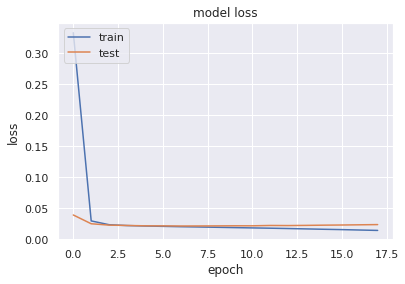

start fold 3
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3347 - binary_crossentropy: 0.3336 - val_loss: 0.0433 - val_binary_crossentropy: 0.0406
Epoch 2/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0250 - val_binary_crossentropy: 0.0213
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0235 - binary_crossentropy: 0.0196 - val_loss: 0.0230 - val_binary_crossentropy: 0.0189
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0222 - binary_crossentropy: 0.0180 - val_loss: 0.0222 - val_binary_crossentropy: 0.0178
Epoch 5/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0220 - val_binary_crossentropy: 0.0174
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0218 - val_binary_crossentropy: 0.0171


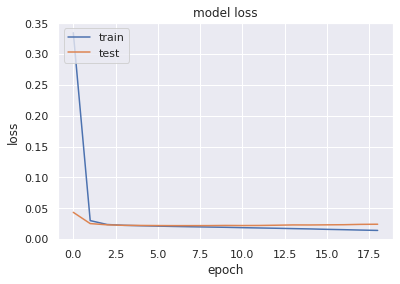

start fold 4
Epoch 1/80
160/160 [==============================] - 2s 9ms/step - loss: 0.3332 - binary_crossentropy: 0.3321 - val_loss: 0.0429 - val_binary_crossentropy: 0.0402
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0298 - binary_crossentropy: 0.0265 - val_loss: 0.0252 - val_binary_crossentropy: 0.0215
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0230 - val_binary_crossentropy: 0.0189
Epoch 4/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0221 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0214 - binary_crossentropy: 0.0170 - val_loss: 0.0216 - val_binary_crossentropy: 0.0171
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0214 - val_binary_crossentropy: 0.0167
Epo

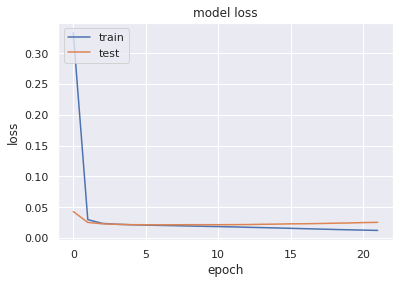

start fold 5
Epoch 1/80
160/160 [==============================] - 2s 13ms/step - loss: 0.3336 - binary_crossentropy: 0.3325 - val_loss: 0.0429 - val_binary_crossentropy: 0.0402
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0249 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0227 - val_binary_crossentropy: 0.0185
Epoch 4/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0219 - val_binary_crossentropy: 0.0174
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0219 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0214 - val_binary_crossentropy: 0.0167


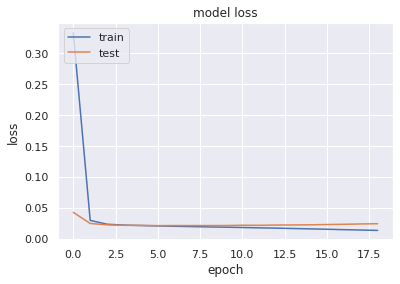

start fold 6
Epoch 1/80
160/160 [==============================] - 2s 10ms/step - loss: 0.3337 - binary_crossentropy: 0.3326 - val_loss: 0.0415 - val_binary_crossentropy: 0.0388
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0252 - val_binary_crossentropy: 0.0215
Epoch 3/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0228 - val_binary_crossentropy: 0.0187
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0222 - binary_crossentropy: 0.0180 - val_loss: 0.0219 - val_binary_crossentropy: 0.0175
Epoch 5/80
160/160 [==============================] - 1s 9ms/step - loss: 0.0214 - binary_crossentropy: 0.0170 - val_loss: 0.0217 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0163 - val_loss: 0.0215 - val_binary_crossentropy: 0.0168
Ep

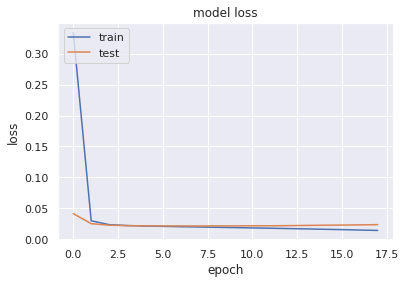

start fold 7
Epoch 1/80
160/160 [==============================] - 2s 12ms/step - loss: 0.3338 - binary_crossentropy: 0.3327 - val_loss: 0.0451 - val_binary_crossentropy: 0.0425
Epoch 2/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0251 - val_binary_crossentropy: 0.0213
Epoch 3/80
160/160 [==============================] - 2s 10ms/step - loss: 0.0237 - binary_crossentropy: 0.0197 - val_loss: 0.0228 - val_binary_crossentropy: 0.0186
Epoch 4/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0222 - val_binary_crossentropy: 0.0178
Epoch 5/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0216 - binary_crossentropy: 0.0171 - val_loss: 0.0219 - val_binary_crossentropy: 0.0174
Epoch 6/80
160/160 [==============================] - 1s 8ms/step - loss: 0.0209 - binary_crossentropy: 0.0164 - val_loss: 0.0217 - val_binary_crossentropy: 0.0170
E

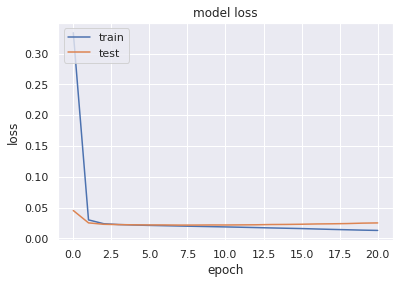

start fold 8
Epoch 1/80
160/160 [==============================] - 3s 16ms/step - loss: 0.3339 - binary_crossentropy: 0.3328 - val_loss: 0.0400 - val_binary_crossentropy: 0.0373
Epoch 2/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0298 - binary_crossentropy: 0.0264 - val_loss: 0.0249 - val_binary_crossentropy: 0.0212
Epoch 3/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0236 - binary_crossentropy: 0.0196 - val_loss: 0.0232 - val_binary_crossentropy: 0.0191
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0222 - binary_crossentropy: 0.0180 - val_loss: 0.0220 - val_binary_crossentropy: 0.0176
Epoch 5/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0217 - val_binary_crossentropy: 0.0172
Epoch 6/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0210 - binary_crossentropy: 0.0164 - val_loss: 0.0214 - val_binary_crossentropy: 0.01

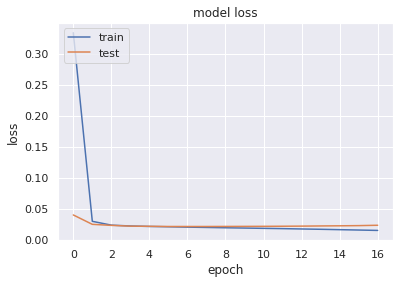

start fold 9
Epoch 1/80
160/160 [==============================] - 2s 14ms/step - loss: 0.3336 - binary_crossentropy: 0.3325 - val_loss: 0.0416 - val_binary_crossentropy: 0.0389
Epoch 2/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0299 - binary_crossentropy: 0.0266 - val_loss: 0.0255 - val_binary_crossentropy: 0.0218
Epoch 3/80
160/160 [==============================] - 2s 13ms/step - loss: 0.0236 - binary_crossentropy: 0.0197 - val_loss: 0.0229 - val_binary_crossentropy: 0.0188
Epoch 4/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0223 - binary_crossentropy: 0.0180 - val_loss: 0.0221 - val_binary_crossentropy: 0.0177
Epoch 5/80
160/160 [==============================] - 2s 12ms/step - loss: 0.0215 - binary_crossentropy: 0.0170 - val_loss: 0.0221 - val_binary_crossentropy: 0.0176
Epoch 6/80
160/160 [==============================] - 2s 11ms/step - loss: 0.0210 - binary_crossentropy: 0.0164 - val_loss: 0.0217 - val_binary_crossentropy: 0.01

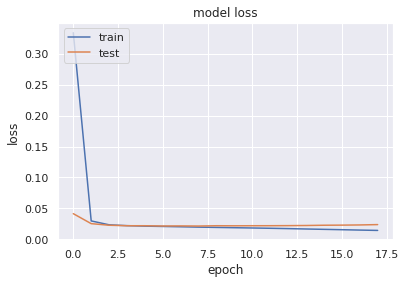

Our out of folds mean log loss score is 0.018591199252074746
CPU times: user 42min 46s, sys: 4min 5s, total: 46min 51s
Wall time: 37min 39s


In [32]:
%%time
for SEED in SEEDS1:
    test_pred, oof_pred = train_and_evaluate(train, test, train_targets, features, start_predictors, SEED=SEED, MODEL = 'rs')

## Make Submission 

In [33]:
# Inference time
test_pred_5l, oof_pred_5l = run_multiple_seeds(train, test, train_targets, features, start_predictors, SEEDS=SEEDS5, MODEL = '5l', PATH = '/kaggle/working')
test_pred_4l, oof_pred_4l = run_multiple_seeds(train, test, train_targets, features, start_predictors, SEEDS=SEEDS4, MODEL = '4l', PATH = '/kaggle/working')
test_pred_3l, oof_pred_3l = run_multiple_seeds(train, test, train_targets, features, start_predictors, SEEDS=SEEDS3, MODEL = '3l', PATH = '/kaggle/working')
test_pred_2l, oof_pred_2l = run_multiple_seeds(train, test, train_targets, features, start_predictors, SEEDS=SEEDS2, MODEL = '2l', PATH = '/kaggle/working')
test_pred_rs, oof_pred_rs = run_multiple_seeds(train, test, train_targets, features, start_predictors, SEEDS=SEEDS1, MODEL = 'rs', PATH = '/kaggle/working')



Using model 5l with seed 29 for inference
Trained with 1069 features
Our out of folds mean log loss score is 0.016779216297852038
--------------------------------------------------


Using model 5l with seed 30 for inference
Trained with 1069 features
Our out of folds mean log loss score is 0.016892926040674834
--------------------------------------------------


Using model 5l with seed 31 for inference
Trained with 1069 features
Our out of folds mean log loss score is 0.01681561217120392
--------------------------------------------------


Using model 5l with seed 32 for inference
Trained with 1069 features
Our out of folds mean log loss score is 0.016900396532058926
--------------------------------------------------


Using model 5l with seed 33 for inference
Trained with 1069 features
Our out of folds mean log loss score is 0.01677089344625973
--------------------------------------------------


Using model 5l with seed 34 for inference
Trained with 1069 features
Our out of folds m

In [34]:
# Blend 5l, 4l, 3l and l2 dnn model
oof_pred = np.average([oof_pred_5l, oof_pred_4l, oof_pred_3l, oof_pred_2l], axis = 0)
seed_log_loss = mean_log_loss(train_targets.values, oof_pred)
print(f'Our final out of folds log loss for our classic dnn blend is {seed_log_loss}')
test_pred = np.average([test_pred_5l, test_pred_4l, test_pred_3l, test_pred_2l], axis = 0)

# Blend the result of the previous model with the dnn resnet type model
oof_pred = np.average([oof_pred, oof_pred_rs], axis = 0)
seed_log_loss = mean_log_loss(train_targets.values, oof_pred)
print(f'Our final out of folds log loss for our classic dnn + dnn resnet type model is {seed_log_loss}')
test_pred = np.average([test_pred, test_pred_rs], axis = 0)

sample_submission = submission(test_pred)
sample_submission.head()

Our final out of folds log loss for our classic dnn blend is 0.015740965244900377
Our final out of folds log loss for our classic dnn + dnn resnet type model is 0.01569524242679387


sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_0004d9e33                     0.001112                0.001786   
1  id_001897cda                     0.000276                0.001171   
2  id_002429b5b                     0.000000                0.000000   
3  id_00276f245                     0.000759                0.000944   
4  id_0027f1083                     0.001976                0.001377   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0        0.001904                        0.014640   
1        0.001963                        0.002234   
2        0.000000                        0.000000   
3        0.002009                        0.008976   
4        0.004422                        0.015479   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                           0.017488                        0.003493   
1                           0.000941                        0.002514   
2                           0.000000                        0.000000   
3                           0.005243                        0.004972   
4                           0.024378                        0.001400   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                    0.001534                       0.004725   
1                    0.003945                       0.015672   
2                    0.000000                       0.000000   
3                    0.001868                       0.001799   
4                    0.007890                       0.001354   

   adenylyl_cyclase_activator  ...  tropomyosin_receptor_kinase_inhibitor  \
0                    0.000378  ...                               0.001518   
1                    0.012004  ...                               0.001258   
2                    0.000000  ...                               0.000000   
3                    0.000550  ...                               0.000982   
4                    0.000743  ...                               0.001555   

   trpv_agonist  trpv_antagonist  tubulin_inhibitor  \
0      0.002703         0.002553           0.000870   
1      0.000654         0.007453           0.000149   
2      0.000000         0.000000           0.000000   
3      0.000619         0.002897           0.013028   
4      0.000807         0.005074           0.001661   

   tyrosine_kinase_inhibitor  ubiquitin_specific_protease_inhibitor  \
0                   0.000344                               0.001601   
1                   0.004235                               0.001029   
2                   0.000000                               0.000000   
3                   0.004356                               0.000913   
4                   0.000782                               0.001552   

   vegfr_inhibitor  vitamin_b  vitamin_d_receptor_agonist  wnt_inhibitor  
0         0.000589   0.002636                    0.006791       0.001702  
1         0.000916   0.000765                    0.002959       0.006311  
2         0.000000   0.000000                    0.000000       0.000000  
3         0.000935   0.002114                    0.001004       0.005572  
4         0.002706   0.002333                    0.000199       0.000989  

[5 rows x 207 columns]